In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2020/PRUEBA B.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 8 questions
Page 1, Q1 - A: Detected box: x0=82.5, y0=135.5, x1=105.5, y1=148.2
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 121
Page 1, Q1, A: Yellow percentage: 0.0%


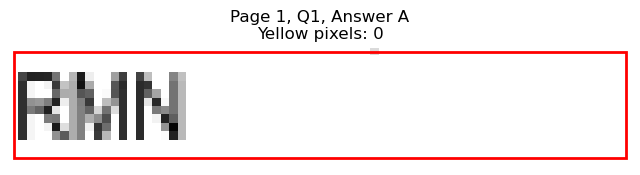

Page 1, Q1 - B: Detected box: x0=82.5, y0=148.2, x1=134.7, y1=160.9
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 291
Page 1, Q1, B: Yellow percentage: 0.0%


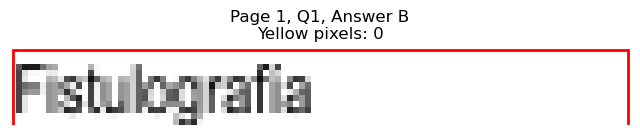

Page 1, Q1 - C: Detected box: x0=82.9, y0=160.8, x1=163.7, y1=173.5
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 426
Page 1, Q1, C: Yellow percentage: 0.0%


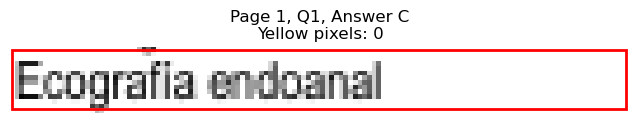

Page 1, Q1 - D: Detected box: x0=334.6, y0=135.5, x1=416.3, y1=148.2
Page 1, Q1, D: Yellow pixels: 1391
Page 1, Q1, D: Total non-white pixels: 1862
Page 1, Q1, D: Yellow percentage: 74.7%


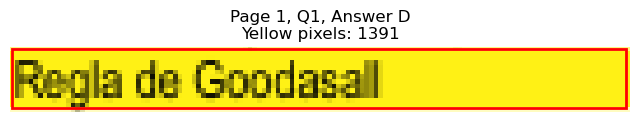

Page 1, Q1 - E: Detected box: x0=334.1, y0=148.2, x1=392.8, y1=160.9
Page 1, Q1, E: Yellow pixels: 0
Page 1, Q1, E: Total non-white pixels: 389
Page 1, Q1, E: Yellow percentage: 0.0%


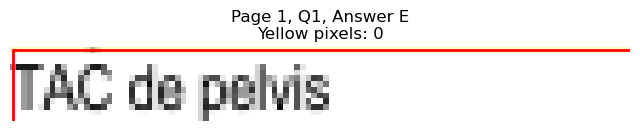


Page 1, Q1 - Selected Answer: D (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=82.5, y0=211.3, x1=128.7, y1=224.0
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 316
Page 1, Q2, A: Yellow percentage: 0.0%


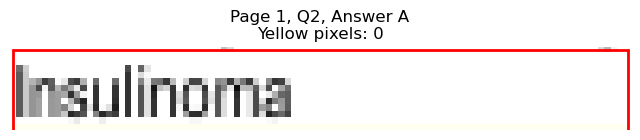

Page 1, Q2 - B: Detected box: x0=82.5, y0=223.9, x1=141.1, y1=236.6
Page 1, Q2, B: Yellow pixels: 1204
Page 1, Q2, B: Total non-white pixels: 1540
Page 1, Q2, B: Yellow percentage: 78.2%


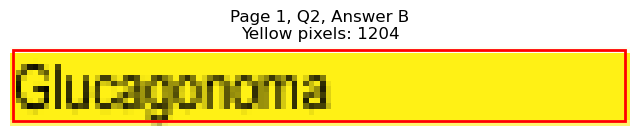

Page 1, Q2 - C: Detected box: x0=82.9, y0=236.5, x1=132.1, y1=249.2
Page 1, Q2, C: Yellow pixels: 100
Page 1, Q2, C: Total non-white pixels: 358
Page 1, Q2, C: Yellow percentage: 27.9%


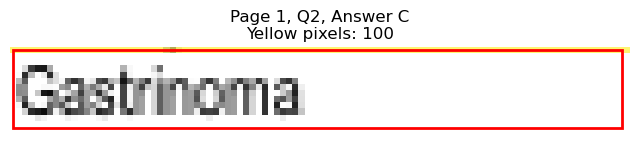

Page 1, Q2 - D: Detected box: x0=334.6, y0=211.3, x1=407.3, y1=224.0
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 376
Page 1, Q2, D: Yellow percentage: 0.0%


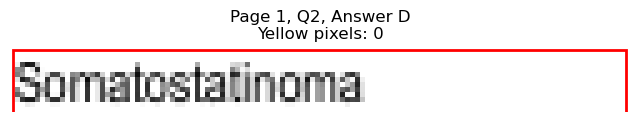

Page 1, Q2 - E: Detected box: x0=334.1, y0=223.9, x1=368.7, y1=236.6
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 160
Page 1, Q2, E: Yellow percentage: 0.0%


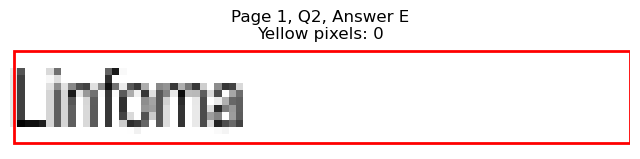


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=82.5, y0=299.7, x1=138.6, y1=312.3
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 309
Page 1, Q3, A: Yellow percentage: 0.0%


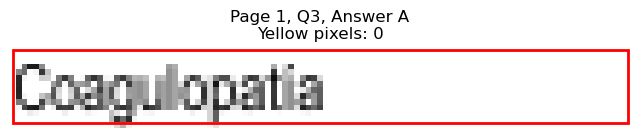

Page 1, Q3 - B: Detected box: x0=82.5, y0=312.3, x1=153.1, y1=324.9
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 357
Page 1, Q3, B: Yellow percentage: 0.0%


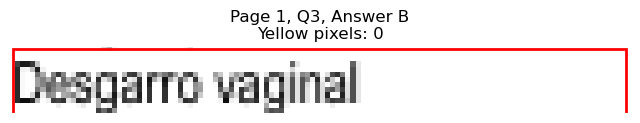

Page 1, Q3 - C: Detected box: x0=82.9, y0=324.9, x1=216.9, y1=337.5
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 685
Page 1, Q3, C: Yellow percentage: 0.0%


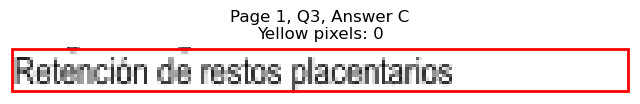

Page 1, Q3 - D: Detected box: x0=334.6, y0=299.7, x1=394.3, y1=312.3
Page 1, Q3, D: Yellow pixels: 111
Page 1, Q3, D: Total non-white pixels: 402
Page 1, Q3, D: Yellow percentage: 27.6%


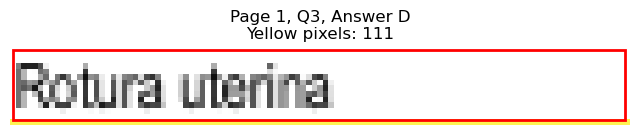

Page 1, Q3 - E: Detected box: x0=334.1, y0=312.3, x1=392.8, y1=324.9
Page 1, Q3, E: Yellow pixels: 1202
Page 1, Q3, E: Total non-white pixels: 1417
Page 1, Q3, E: Yellow percentage: 84.8%


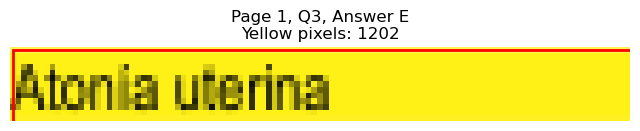


Page 1, Q3 - Selected Answer: E (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=82.5, y0=413.3, x1=134.1, y1=426.0
Page 1, Q4, A: Yellow pixels: 1140
Page 1, Q4, A: Total non-white pixels: 1339
Page 1, Q4, A: Yellow percentage: 85.1%


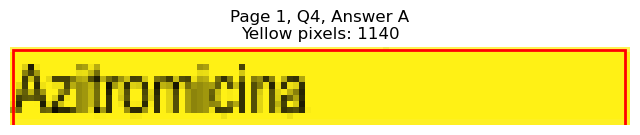

Page 1, Q4 - B: Detected box: x0=82.5, y0=425.9, x1=119.1, y1=438.6
Page 1, Q4, B: Yellow pixels: 88
Page 1, Q4, B: Total non-white pixels: 264
Page 1, Q4, B: Yellow percentage: 33.3%


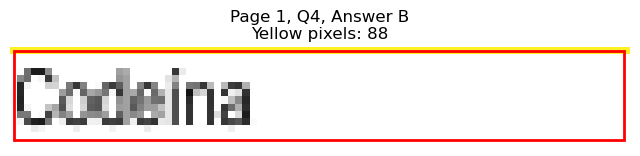

Page 1, Q4 - C: Detected box: x0=82.9, y0=438.5, x1=142.6, y1=451.2
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 306
Page 1, Q4, C: Yellow percentage: 0.0%


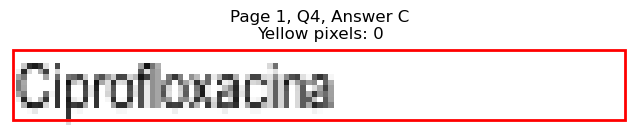

Page 1, Q4 - D: Detected box: x0=334.6, y0=413.3, x1=382.3, y1=426.0
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 259
Page 1, Q4, D: Yellow percentage: 0.0%


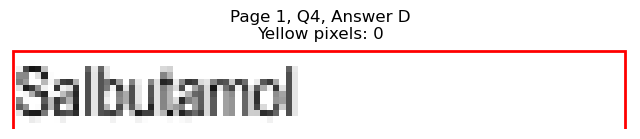

Page 1, Q4 - E: Detected box: x0=334.1, y0=425.9, x1=399.8, y1=438.6
Page 1, Q4, E: Yellow pixels: 0
Page 1, Q4, E: Total non-white pixels: 341
Page 1, Q4, E: Yellow percentage: 0.0%


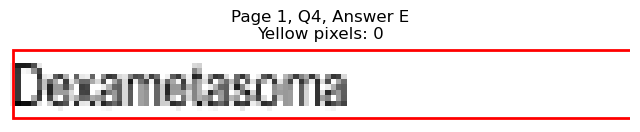


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=82.5, y0=501.7, x1=175.8, y1=514.3
Page 1, Q5, A: Yellow pixels: 1365
Page 1, Q5, A: Total non-white pixels: 2016
Page 1, Q5, A: Yellow percentage: 67.7%


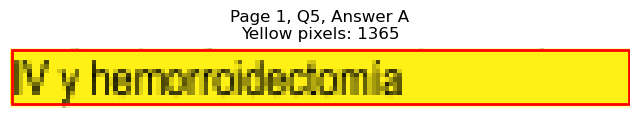

Page 1, Q5 - B: Detected box: x0=82.5, y0=514.3, x1=158.7, y1=526.9
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 524
Page 1, Q5, B: Yellow percentage: 0.0%


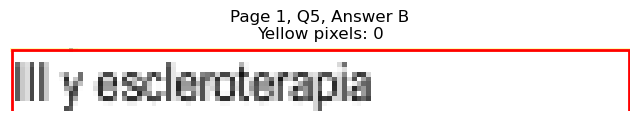

Page 1, Q5 - C: Detected box: x0=82.9, y0=526.9, x1=209.9, y1=539.5
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 622
Page 1, Q5, C: Yellow percentage: 0.0%


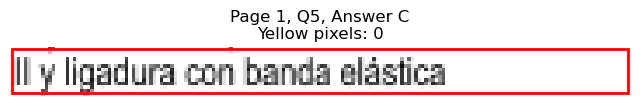

Page 1, Q5 - D: Detected box: x0=334.6, y0=501.7, x1=396.3, y1=514.3
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 296
Page 1, Q5, D: Yellow percentage: 0.0%


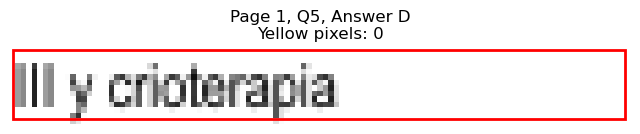

Page 1, Q5 - E: Detected box: x0=334.1, y0=514.3, x1=471.1, y1=526.9
Page 1, Q5, E: Yellow pixels: 0
Page 1, Q5, E: Total non-white pixels: 655
Page 1, Q5, E: Yellow percentage: 0.0%


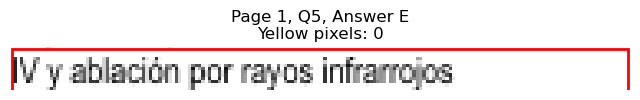


Page 1, Q5 - Selected Answer: A (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=82.5, y0=564.8, x1=115.1, y1=577.4
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 159
Page 1, Q6, A: Yellow percentage: 0.0%


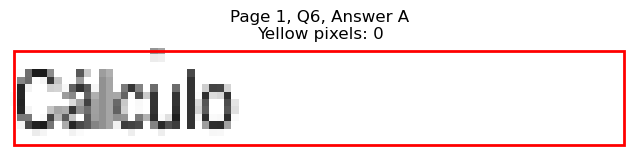

Page 1, Q6 - B: Detected box: x0=82.5, y0=577.4, x1=135.1, y1=590.0
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 262
Page 1, Q6, B: Yellow percentage: 0.0%


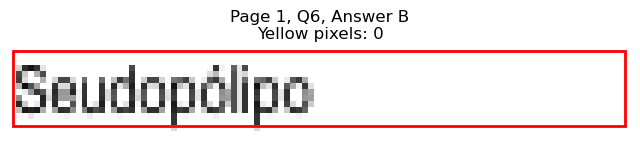

Page 1, Q6 - C: Detected box: x0=82.9, y0=590.0, x1=110.5, y1=602.6
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 156
Page 1, Q6, C: Yellow percentage: 0.0%


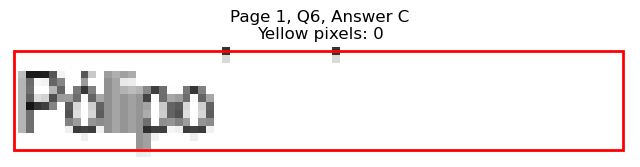

Page 1, Q6 - D: Detected box: x0=334.6, y0=564.8, x1=366.2, y1=577.4
Page 1, Q6, D: Yellow pixels: 875
Page 1, Q6, D: Total non-white pixels: 1162
Page 1, Q6, D: Yellow percentage: 75.3%


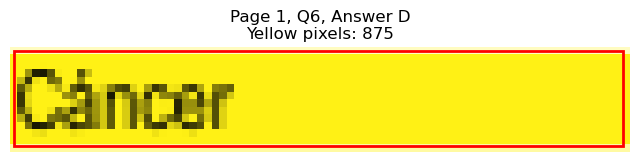

Page 1, Q6 - E: Detected box: x0=334.1, y0=577.4, x1=372.8, y1=590.0
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 281
Page 1, Q6, E: Yellow percentage: 0.0%


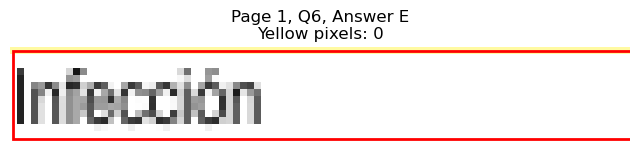


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=82.5, y0=653.1, x1=228.4, y1=665.8
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 754
Page 1, Q7, A: Yellow percentage: 0.0%


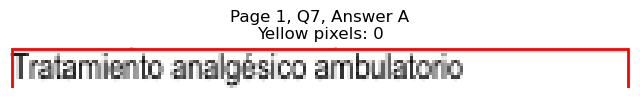

Page 1, Q7 - B: Detected box: x0=82.5, y0=665.7, x1=272.1, y1=678.4
Page 1, Q7, B: Yellow pixels: 192
Page 1, Q7, B: Total non-white pixels: 1130
Page 1, Q7, B: Yellow percentage: 17.0%


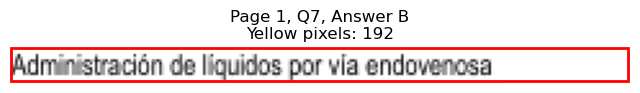

Page 1, Q7 - C: Detected box: x0=82.9, y0=678.3, x1=216.4, y1=691.0
Page 1, Q7, C: Yellow pixels: 1913
Page 1, Q7, C: Total non-white pixels: 2405
Page 1, Q7, C: Yellow percentage: 79.5%


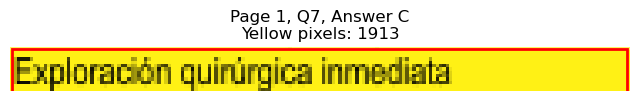

Page 1, Q7 - D: Detected box: x0=334.6, y0=653.1, x1=464.9, y1=665.8
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 631
Page 1, Q7, D: Yellow percentage: 0.0%


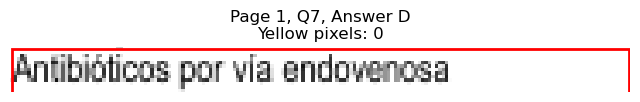

Page 1, Q7 - E: Detected box: x0=334.1, y0=665.7, x1=515.1, y1=678.4
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 885
Page 1, Q7, E: Yellow percentage: 0.0%


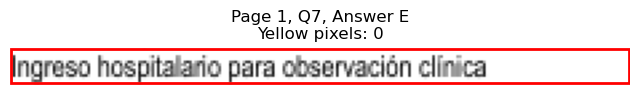


Page 1, Q7 - Selected Answer: C (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=82.5, y0=741.4, x1=146.2, y1=754.1
Page 1, Q8, A: Yellow pixels: 1275
Page 1, Q8, A: Total non-white pixels: 1610
Page 1, Q8, A: Yellow percentage: 79.2%


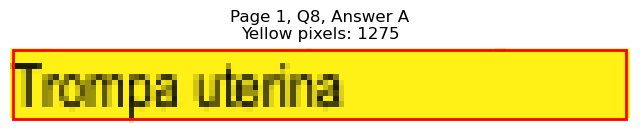

Page 1, Q8 - B: Detected box: x0=82.5, y0=754.0, x1=111.5, y1=766.7
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 217
Page 1, Q8, B: Yellow percentage: 0.0%


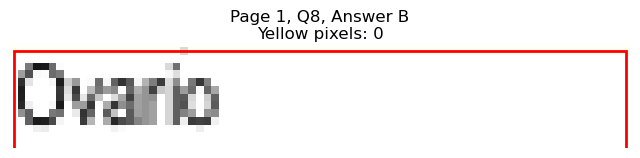

Page 1, Q8 - C: Detected box: x0=82.9, y0=766.8, x1=128.1, y1=779.4
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 211
Page 1, Q8, C: Yellow percentage: 0.0%


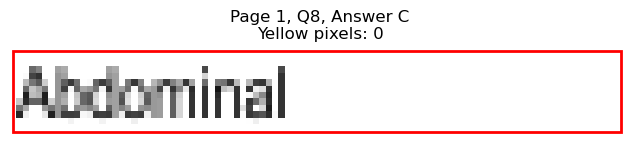

Page 1, Q8 - D: Detected box: x0=334.6, y0=741.4, x1=406.4, y1=754.1
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 344
Page 1, Q8, D: Yellow percentage: 0.0%


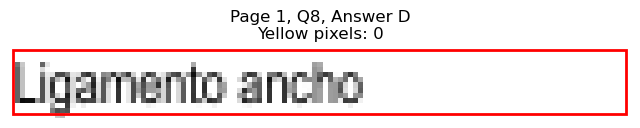

Page 1, Q8 - E: Detected box: x0=334.1, y0=754.0, x1=389.9, y1=766.7
Page 1, Q8, E: Yellow pixels: 0
Page 1, Q8, E: Total non-white pixels: 289
Page 1, Q8, E: Yellow percentage: 0.0%


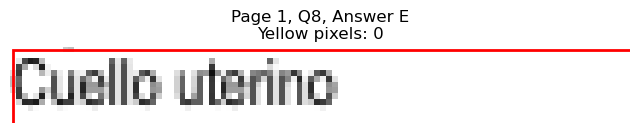


Page 1, Q8 - Selected Answer: A (based on yellow pixel count)





Page 2: Found 8 questions
Page 2, Q1 - A: Detected box: x0=82.5, y0=148.2, x1=166.2, y1=160.9
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 427
Page 2, Q1, A: Yellow percentage: 0.0%


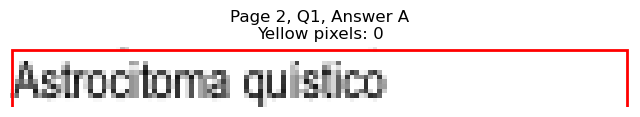

Page 2, Q1 - B: Detected box: x0=82.5, y0=160.8, x1=205.8, y1=173.5
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 631
Page 2, Q1, B: Yellow percentage: 0.0%


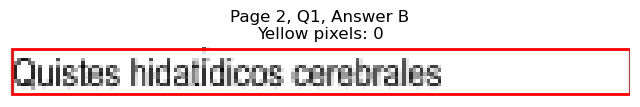

Page 2, Q1 - C: Detected box: x0=82.9, y0=173.4, x1=167.7, y1=186.1
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 434
Page 2, Q1, C: Yellow percentage: 0.0%


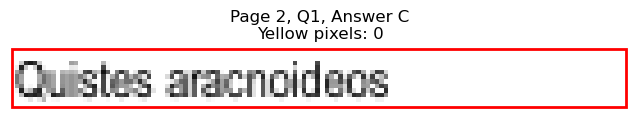

Page 2, Q1 - D: Detected box: x0=334.6, y0=148.2, x1=412.9, y1=160.9
Page 2, Q1, D: Yellow pixels: 1363
Page 2, Q1, D: Total non-white pixels: 1677
Page 2, Q1, D: Yellow percentage: 81.3%


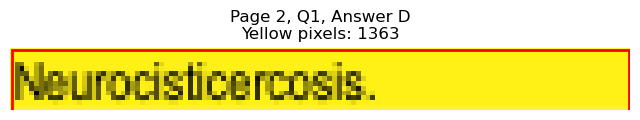

Page 2, Q1 - E: Detected box: x0=334.1, y0=160.8, x1=462.1, y1=173.5
Page 2, Q1, E: Yellow pixels: 179
Page 2, Q1, E: Total non-white pixels: 852
Page 2, Q1, E: Yellow percentage: 21.0%


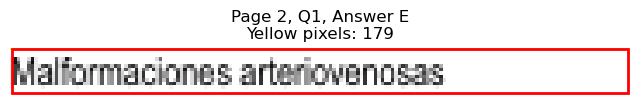


Page 2, Q1 - Selected Answer: D (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=82.5, y0=223.9, x1=178.2, y1=236.6
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 477
Page 2, Q2, A: Yellow percentage: 0.0%


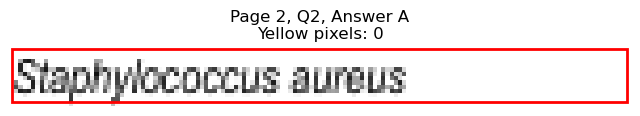

Page 2, Q2 - B: Detected box: x0=82.5, y0=236.5, x1=168.3, y1=249.2
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 458
Page 2, Q2, B: Yellow percentage: 0.0%


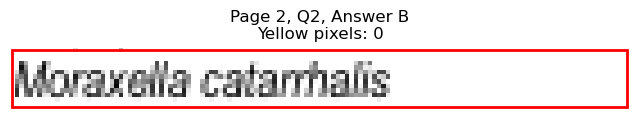

Page 2, Q2 - C: Detected box: x0=82.9, y0=249.1, x1=206.3, y1=261.8
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 626
Page 2, Q2, C: Yellow percentage: 0.0%


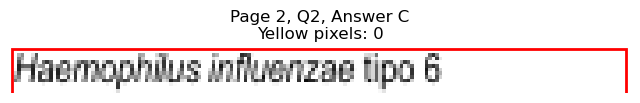

Page 2, Q2 - D: Detected box: x0=334.6, y0=223.9, x1=449.0, y1=236.6
Page 2, Q2, D: Yellow pixels: 165
Page 2, Q2, D: Total non-white pixels: 756
Page 2, Q2, D: Yellow percentage: 21.8%


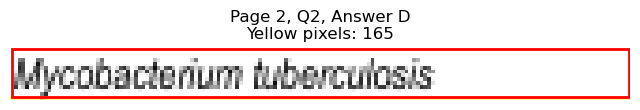

Page 2, Q2 - E: Detected box: x0=334.1, y0=236.5, x1=446.0, y1=249.2
Page 2, Q2, E: Yellow pixels: 1667
Page 2, Q2, E: Total non-white pixels: 2268
Page 2, Q2, E: Yellow percentage: 73.5%


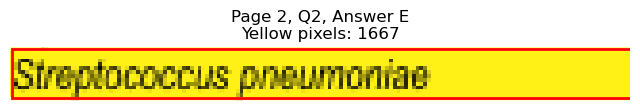


Page 2, Q2 - Selected Answer: E (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=82.5, y0=287.1, x1=126.1, y1=299.7
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 203
Page 2, Q3, A: Yellow percentage: 0.0%


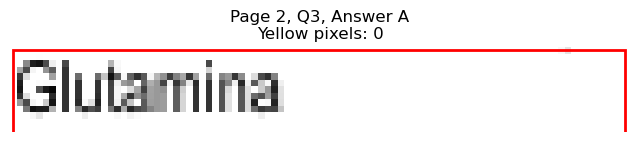

Page 2, Q3 - B: Detected box: x0=82.5, y0=299.7, x1=113.1, y1=312.3
Page 2, Q3, B: Yellow pixels: 82
Page 2, Q3, B: Total non-white pixels: 209
Page 2, Q3, B: Yellow percentage: 39.2%


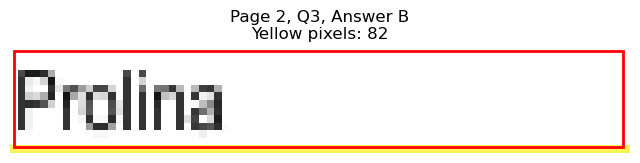

Page 2, Q3 - C: Detected box: x0=82.9, y0=312.3, x1=117.5, y1=324.9
Page 2, Q3, C: Yellow pixels: 983
Page 2, Q3, C: Total non-white pixels: 1118
Page 2, Q3, C: Yellow percentage: 87.9%


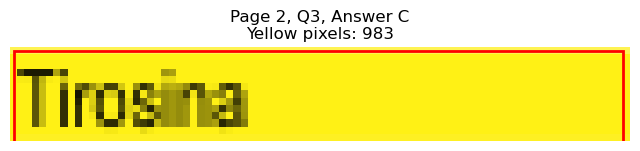

Page 2, Q3 - D: Detected box: x0=334.6, y0=287.1, x1=370.3, y1=299.7
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 186
Page 2, Q3, D: Yellow percentage: 0.0%


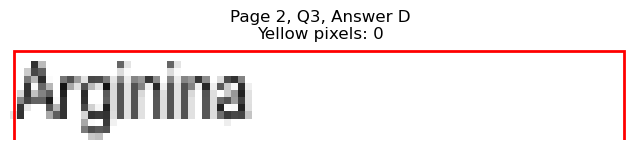

Page 2, Q3 - E: Detected box: x0=334.1, y0=299.7, x1=360.2, y1=312.3
Page 2, Q3, E: Yellow pixels: 0
Page 2, Q3, E: Total non-white pixels: 132
Page 2, Q3, E: Yellow percentage: 0.0%


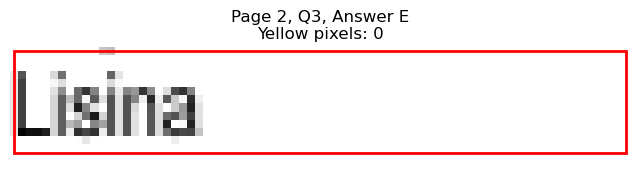


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=82.5, y0=362.8, x1=166.7, y1=375.5
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 415
Page 2, Q4, A: Yellow percentage: 0.0%


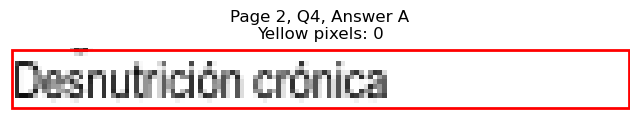

Page 2, Q4 - B: Detected box: x0=82.5, y0=375.4, x1=196.8, y1=388.1
Page 2, Q4, B: Yellow pixels: 165
Page 2, Q4, B: Total non-white pixels: 742
Page 2, Q4, B: Yellow percentage: 22.2%


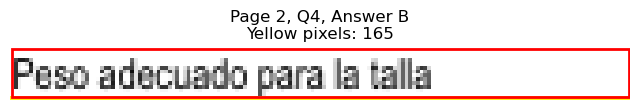

Page 2, Q4 - C: Detected box: x0=82.9, y0=388.0, x1=261.0, y1=400.7
Page 2, Q4, C: Yellow pixels: 1786
Page 2, Q4, C: Total non-white pixels: 2509
Page 2, Q4, C: Yellow percentage: 71.2%


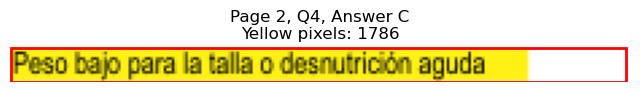

Page 2, Q4 - D: Detected box: x0=334.6, y0=362.8, x1=416.3, y1=375.5
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 432
Page 2, Q4, D: Yellow percentage: 0.0%


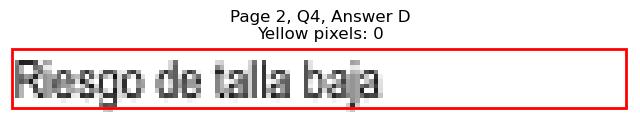

Page 2, Q4 - E: Detected box: x0=334.1, y0=375.4, x1=380.3, y1=388.1
Page 2, Q4, E: Yellow pixels: 0
Page 2, Q4, E: Total non-white pixels: 251
Page 2, Q4, E: Yellow percentage: 0.0%


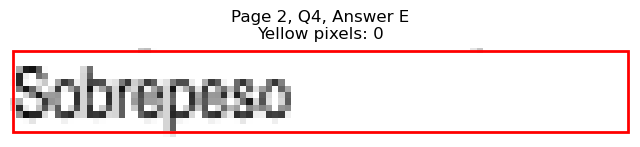


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=82.5, y0=425.9, x1=116.1, y1=438.6
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 163
Page 2, Q5, A: Yellow percentage: 0.0%


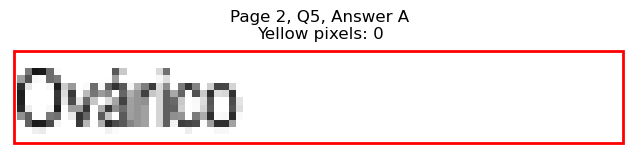

Page 2, Q5 - B: Detected box: x0=82.5, y0=438.5, x1=117.5, y1=451.2
Page 2, Q5, B: Yellow pixels: 86
Page 2, Q5, B: Total non-white pixels: 256
Page 2, Q5, B: Yellow percentage: 33.6%


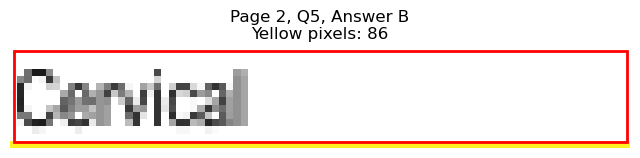

Page 2, Q5 - C: Detected box: x0=82.9, y0=451.1, x1=120.5, y1=463.8
Page 2, Q5, C: Yellow pixels: 1032
Page 2, Q5, C: Total non-white pixels: 1157
Page 2, Q5, C: Yellow percentage: 89.2%


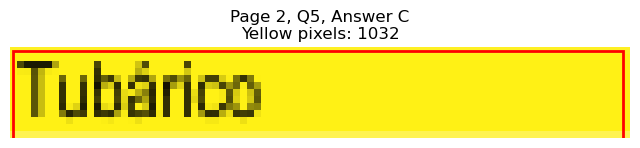

Page 2, Q5 - D: Detected box: x0=334.6, y0=425.9, x1=377.7, y1=438.6
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 229
Page 2, Q5, D: Yellow percentage: 0.0%


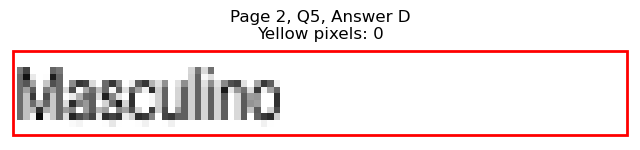

Page 2, Q5 - E: Detected box: x0=334.1, y0=438.5, x1=365.7, y1=451.2
Page 2, Q5, E: Yellow pixels: 0
Page 2, Q5, E: Total non-white pixels: 160
Page 2, Q5, E: Yellow percentage: 0.0%


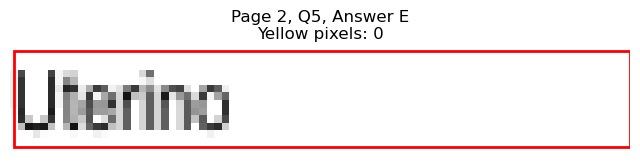


Page 2, Q5 - Selected Answer: C (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=82.5, y0=514.3, x1=171.3, y1=526.9
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 596
Page 2, Q6, A: Yellow percentage: 0.0%


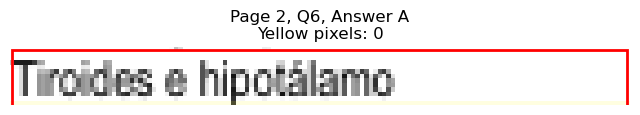

Page 2, Q6 - B: Detected box: x0=82.5, y0=526.9, x1=179.8, y1=539.5
Page 2, Q6, B: Yellow pixels: 1556
Page 2, Q6, B: Total non-white pixels: 2072
Page 2, Q6, B: Yellow percentage: 75.1%


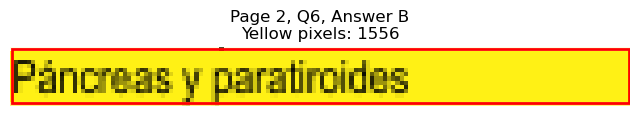

Page 2, Q6 - C: Detected box: x0=82.9, y0=539.5, x1=172.2, y1=552.1
Page 2, Q6, C: Yellow pixels: 141
Page 2, Q6, C: Total non-white pixels: 599
Page 2, Q6, C: Yellow percentage: 23.5%


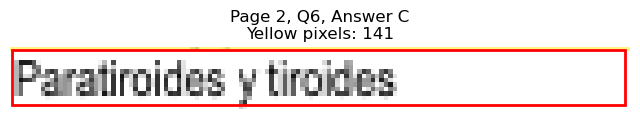

Page 2, Q6 - D: Detected box: x0=334.6, y0=514.3, x1=413.3, y1=526.9
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 389
Page 2, Q6, D: Yellow percentage: 0.0%


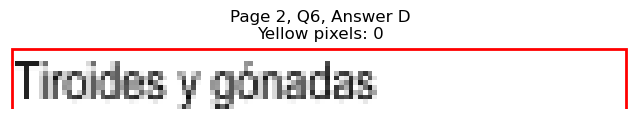

Page 2, Q6 - E: Detected box: x0=334.1, y0=526.9, x1=480.7, y1=539.5
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 747
Page 2, Q6, E: Yellow percentage: 0.0%


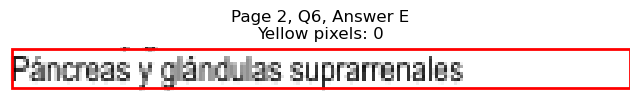


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=82.5, y0=602.6, x1=98.5, y1=615.2
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 71
Page 2, Q7, A: Yellow percentage: 0.0%


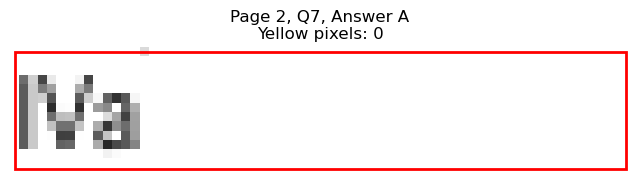

Page 2, Q7 - B: Detected box: x0=82.5, y0=615.2, x1=95.1, y1=627.8
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 57
Page 2, Q7, B: Yellow percentage: 0.0%


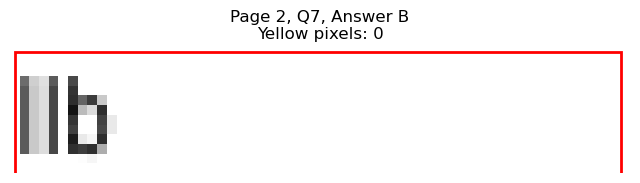

Page 2, Q7 - C: Detected box: x0=82.9, y0=627.9, x1=99.0, y1=640.6
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 70
Page 2, Q7, C: Yellow percentage: 0.0%


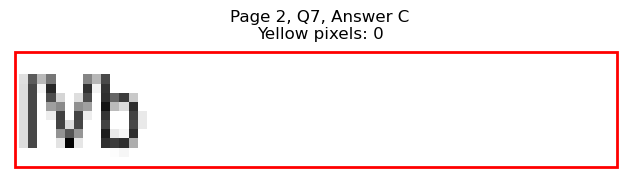

Page 2, Q7 - D: Detected box: x0=334.6, y0=602.6, x1=349.7, y1=615.2
Page 2, Q7, D: Yellow pixels: 797
Page 2, Q7, D: Total non-white pixels: 924
Page 2, Q7, D: Yellow percentage: 86.3%


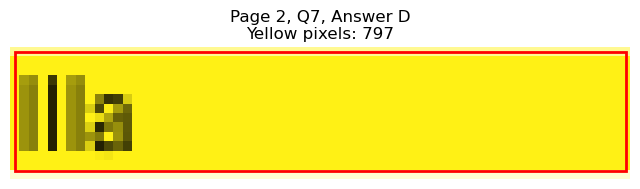

Page 2, Q7 - E: Detected box: x0=334.1, y0=615.2, x1=349.3, y1=627.8
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 128
Page 2, Q7, E: Yellow percentage: 0.0%


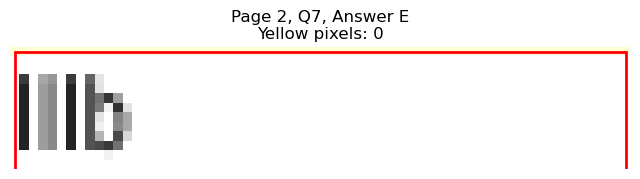


Page 2, Q7 - Selected Answer: D (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=82.5, y0=691.1, x1=133.1, y1=703.7
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 252
Page 2, Q8, A: Yellow percentage: 0.0%


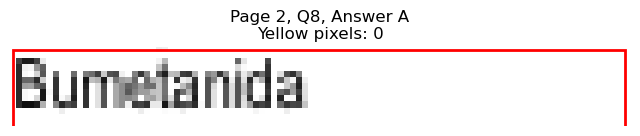

Page 2, Q8 - B: Detected box: x0=82.5, y0=703.7, x1=152.2, y1=716.3
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 375
Page 2, Q8, B: Yellow percentage: 0.0%


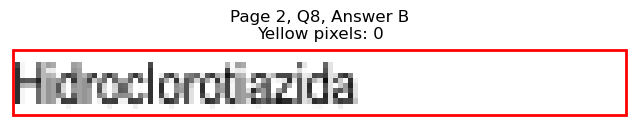

Page 2, Q8 - C: Detected box: x0=82.9, y0=716.3, x1=133.1, y1=728.9
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 231
Page 2, Q8, C: Yellow percentage: 0.0%


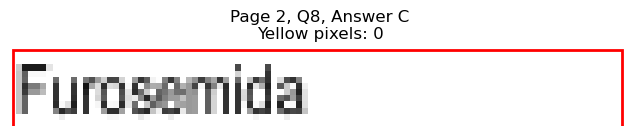

Page 2, Q8 - D: Detected box: x0=334.6, y0=691.1, x1=396.3, y1=703.7
Page 2, Q8, D: Yellow pixels: 1229
Page 2, Q8, D: Total non-white pixels: 1469
Page 2, Q8, D: Yellow percentage: 83.7%


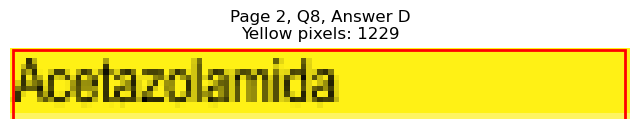

Page 2, Q8 - E: Detected box: x0=334.1, y0=703.7, x1=401.3, y1=716.3
Page 2, Q8, E: Yellow pixels: 118
Page 2, Q8, E: Total non-white pixels: 470
Page 2, Q8, E: Yellow percentage: 25.1%


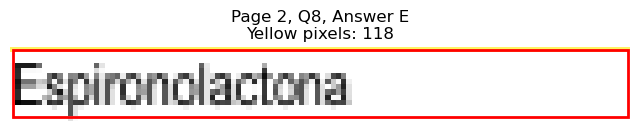


Page 2, Q8 - Selected Answer: D (based on yellow pixel count)





Page 3: Found 7 questions
Page 3, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=167.8, y1=135.6
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 409
Page 3, Q1, A: Yellow percentage: 0.0%


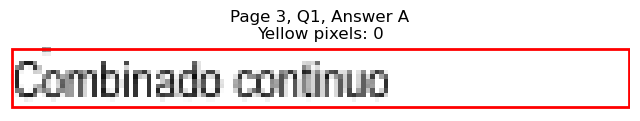

Page 3, Q1 - B: Detected box: x0=82.5, y0=135.5, x1=177.7, y1=148.2
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 497
Page 3, Q1, B: Yellow percentage: 0.0%


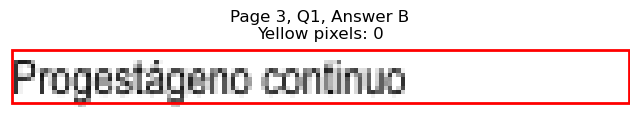

Page 3, Q1 - C: Detected box: x0=82.9, y0=148.2, x1=176.8, y1=160.9
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 489
Page 3, Q1, C: Yellow percentage: 0.0%


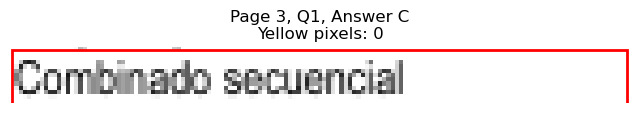

Page 3, Q1 - D: Detected box: x0=334.6, y0=122.9, x1=410.8, y1=135.6
Page 3, Q1, D: Yellow pixels: 127
Page 3, Q1, D: Total non-white pixels: 515
Page 3, Q1, D: Yellow percentage: 24.7%


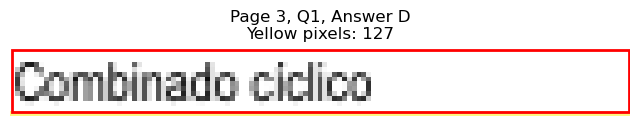

Page 3, Q1 - E: Detected box: x0=334.1, y0=135.5, x1=420.9, y1=148.2
Page 3, Q1, E: Yellow pixels: 1438
Page 3, Q1, E: Total non-white pixels: 1918
Page 3, Q1, E: Yellow percentage: 75.0%


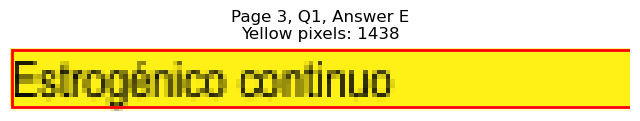


Page 3, Q1 - Selected Answer: E (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=82.5, y0=236.5, x1=169.8, y1=249.2
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 388
Page 3, Q2, A: Yellow percentage: 0.0%


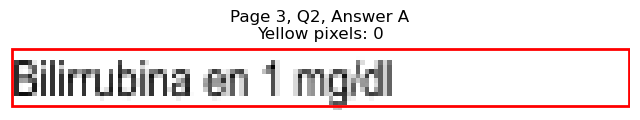

Page 3, Q2 - B: Detected box: x0=82.5, y0=249.1, x1=123.1, y1=261.8
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 296
Page 3, Q2, B: Yellow percentage: 0.0%


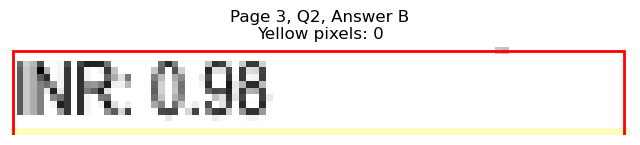

Page 3, Q2 - C: Detected box: x0=82.9, y0=261.7, x1=160.2, y1=274.4
Page 3, Q2, C: Yellow pixels: 1372
Page 3, Q2, C: Total non-white pixels: 1806
Page 3, Q2, C: Yellow percentage: 76.0%


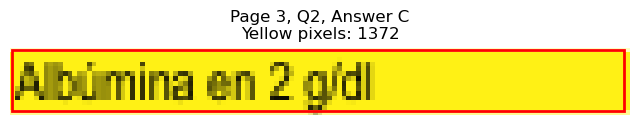

Page 3, Q2 - D: Detected box: x0=334.6, y0=236.5, x1=386.8, y1=249.2
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 222
Page 3, Q2, D: Yellow percentage: 0.0%


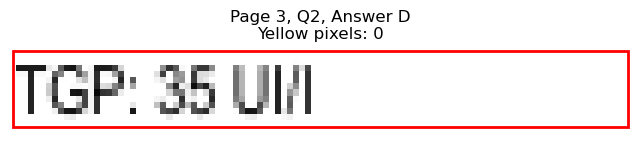

Page 3, Q2 - E: Detected box: x0=334.1, y0=249.1, x1=405.4, y1=261.8
Page 3, Q2, E: Yellow pixels: 0
Page 3, Q2, E: Total non-white pixels: 339
Page 3, Q2, E: Yellow percentage: 0.0%


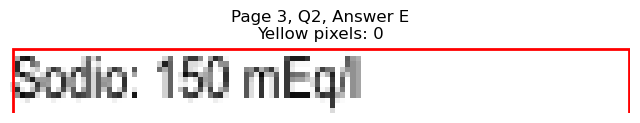


Page 3, Q2 - Selected Answer: C (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=82.5, y0=337.5, x1=233.0, y1=350.1
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 786
Page 3, Q3, A: Yellow percentage: 0.0%


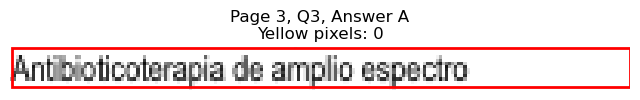

Page 3, Q3 - B: Detected box: x0=82.5, y0=350.2, x1=201.9, y1=362.9
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 591
Page 3, Q3, B: Yellow percentage: 0.0%


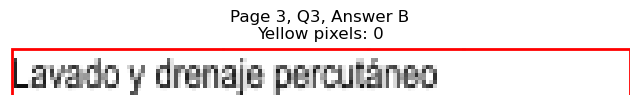

Page 3, Q3 - C: Detected box: x0=82.9, y0=362.8, x1=214.5, y1=375.5
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 670
Page 3, Q3, C: Yellow percentage: 0.0%


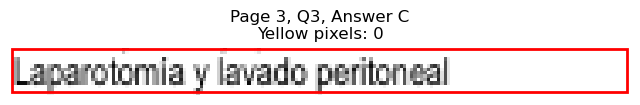

Page 3, Q3 - D: Detected box: x0=334.6, y0=337.5, x1=427.5, y1=350.1
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 473
Page 3, Q3, D: Yellow percentage: 0.0%


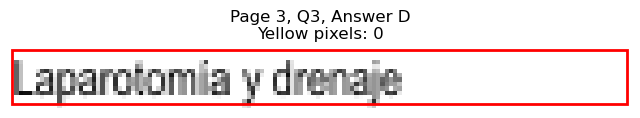

Page 3, Q3 - E: Detected box: x0=334.1, y0=350.2, x1=496.2, y1=362.9
Page 3, Q3, E: Yellow pixels: 1845
Page 3, Q3, E: Total non-white pixels: 2496
Page 3, Q3, E: Yellow percentage: 73.9%


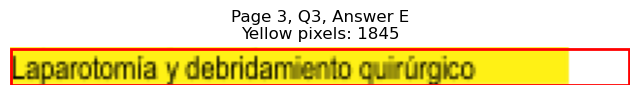


Page 3, Q3 - Selected Answer: E (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=82.5, y0=400.6, x1=242.4, y1=413.3
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 873
Page 3, Q4, A: Yellow percentage: 0.0%


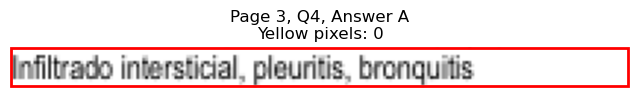

Page 3, Q4 - B: Detected box: x0=82.5, y0=413.3, x1=249.5, y1=426.0
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 875
Page 3, Q4, B: Yellow percentage: 0.0%


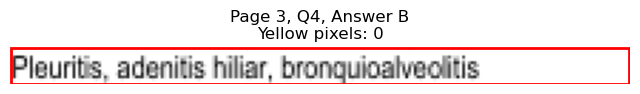

Page 3, Q4 - C: Detected box: x0=82.9, y0=425.9, x1=245.9, y1=438.6
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 859
Page 3, Q4, C: Yellow percentage: 0.0%


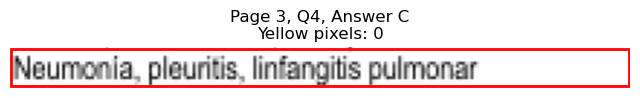

Page 3, Q4 - D: Detected box: x0=334.6, y0=400.6, x1=505.7, y1=413.3
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 845
Page 3, Q4, D: Yellow percentage: 0.0%


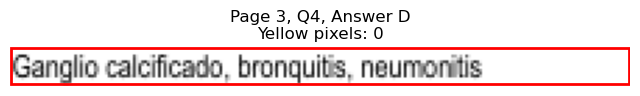

Page 3, Q4 - E: Detected box: x0=334.1, y0=413.3, x1=522.2, y1=426.0
Page 3, Q4, E: Yellow pixels: 1729
Page 3, Q4, E: Total non-white pixels: 2496
Page 3, Q4, E: Yellow percentage: 69.3%


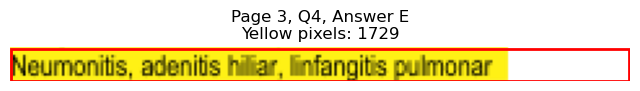


Page 3, Q4 - Selected Answer: E (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=82.5, y0=514.3, x1=204.3, y1=526.9
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 623
Page 3, Q5, A: Yellow percentage: 0.0%


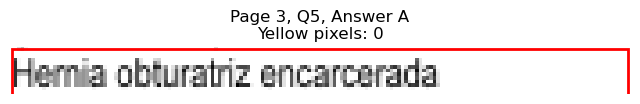

Page 3, Q5 - B: Detected box: x0=82.5, y0=526.9, x1=189.3, y1=539.5
Page 3, Q5, B: Yellow pixels: 158
Page 3, Q5, B: Total non-white pixels: 692
Page 3, Q5, B: Yellow percentage: 22.8%


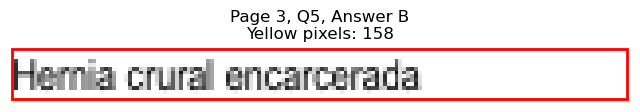

Page 3, Q5 - C: Detected box: x0=82.9, y0=539.5, x1=191.8, y1=552.1
Page 3, Q5, C: Yellow pixels: 1651
Page 3, Q5, C: Total non-white pixels: 2240
Page 3, Q5, C: Yellow percentage: 73.7%


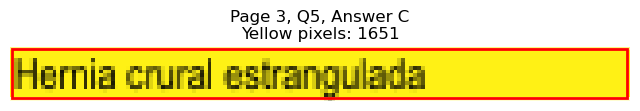

Page 3, Q5 - D: Detected box: x0=334.6, y0=514.3, x1=449.9, y1=526.9
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 592
Page 3, Q5, D: Yellow percentage: 0.0%


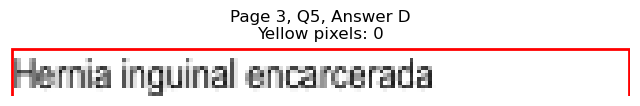

Page 3, Q5 - E: Detected box: x0=334.1, y0=526.9, x1=452.9, y1=539.5
Page 3, Q5, E: Yellow pixels: 0
Page 3, Q5, E: Total non-white pixels: 605
Page 3, Q5, E: Yellow percentage: 0.0%


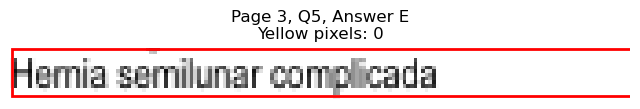


Page 3, Q5 - Selected Answer: C (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=82.5, y0=602.6, x1=175.2, y1=615.2
Page 3, Q6, A: Yellow pixels: 1502
Page 3, Q6, A: Total non-white pixels: 2016
Page 3, Q6, A: Yellow percentage: 74.5%


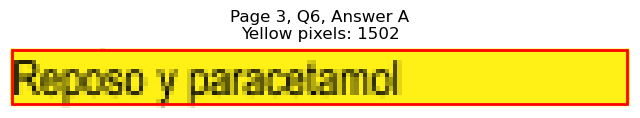

Page 3, Q6 - B: Detected box: x0=82.5, y0=615.2, x1=220.4, y1=627.8
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 917
Page 3, Q6, B: Yellow percentage: 0.0%


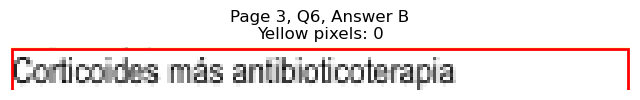

Page 3, Q6 - C: Detected box: x0=82.9, y0=627.9, x1=213.9, y1=640.6
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 666
Page 3, Q6, C: Yellow percentage: 0.0%


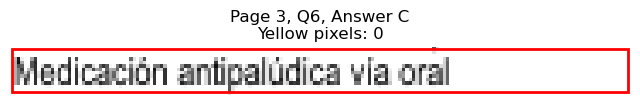

Page 3, Q6 - D: Detected box: x0=334.6, y0=602.6, x1=443.5, y1=615.2
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 561
Page 3, Q6, D: Yellow percentage: 0.0%


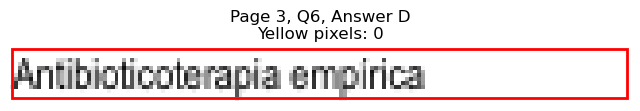

Page 3, Q6 - E: Detected box: x0=334.1, y0=615.2, x1=489.6, y1=627.8
Page 3, Q6, E: Yellow pixels: 0
Page 3, Q6, E: Total non-white pixels: 822
Page 3, Q6, E: Yellow percentage: 0.0%


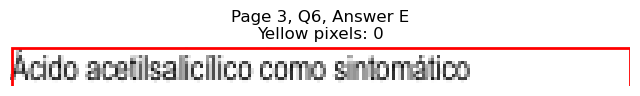


Page 3, Q6 - Selected Answer: A (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=70.8, y0=691.1, x1=79.3, y1=703.7
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 53
Page 3, Q7, A: Yellow percentage: 0.0%


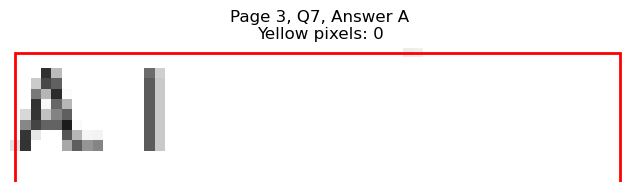

Page 3, Q7 - B: Detected box: x0=82.5, y0=703.7, x1=92.5, y1=716.3
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 48
Page 3, Q7, B: Yellow percentage: 0.0%


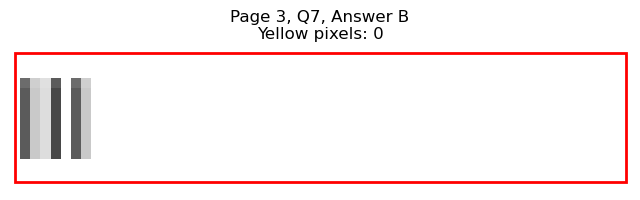

Page 3, Q7 - C: Detected box: x0=70.8, y0=716.3, x1=79.8, y1=728.9
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 62
Page 3, Q7, C: Yellow percentage: 0.0%


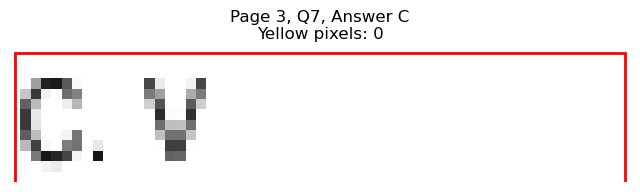

Page 3, Q7 - D: Detected box: x0=334.6, y0=691.1, x1=345.7, y1=703.7
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 106
Page 3, Q7, D: Yellow percentage: 0.0%


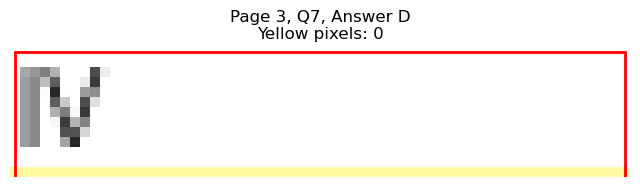

Page 3, Q7 - E: Detected box: x0=322.5, y0=703.7, x1=331.0, y1=716.3
Page 3, Q7, E: Yellow pixels: 670
Page 3, Q7, E: Total non-white pixels: 840
Page 3, Q7, E: Yellow percentage: 79.8%


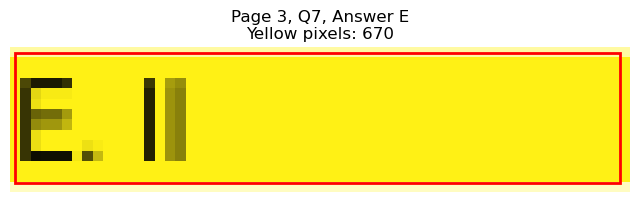


Page 3, Q7 - Selected Answer: E (based on yellow pixel count)





Page 4: Found 8 questions
Page 4, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=416.6, y1=123.0
Page 4, Q1, A: Yellow pixels: 3663
Page 4, Q1, A: Total non-white pixels: 5005
Page 4, Q1, A: Yellow percentage: 73.2%


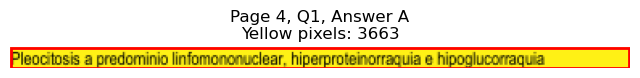

Page 4, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=414.5, y1=135.6
Page 4, Q1, B: Yellow pixels: 370
Page 4, Q1, B: Total non-white pixels: 2114
Page 4, Q1, B: Yellow percentage: 17.5%


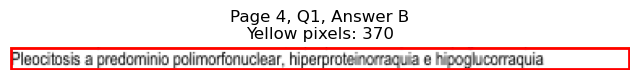

Page 4, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=420.1, y1=148.2
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 1729
Page 4, Q1, C: Yellow percentage: 0.0%


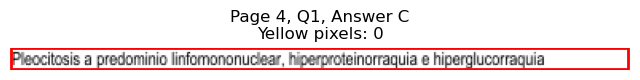

Page 4, Q1 - D: Detected box: x0=82.9, y0=148.2, x1=425.6, y1=160.9
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 1747
Page 4, Q1, D: Yellow percentage: 0.0%


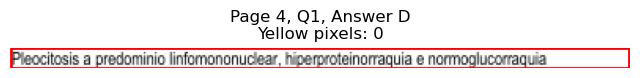

Page 4, Q1 - E: Detected box: x0=82.5, y0=160.8, x1=411.4, y1=173.5
Page 4, Q1, E: Yellow pixels: 0
Page 4, Q1, E: Total non-white pixels: 1733
Page 4, Q1, E: Yellow percentage: 0.0%


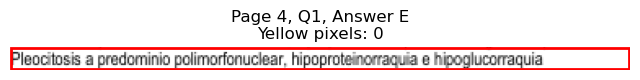


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=82.5, y0=223.9, x1=183.3, y1=236.6
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 511
Page 4, Q2, A: Yellow percentage: 0.0%


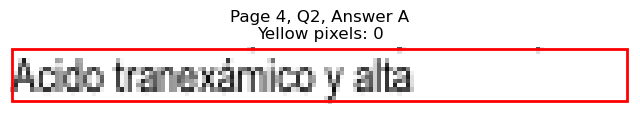

Page 4, Q2 - B: Detected box: x0=82.5, y0=236.5, x1=185.3, y1=249.2
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 510
Page 4, Q2, B: Yellow percentage: 0.0%


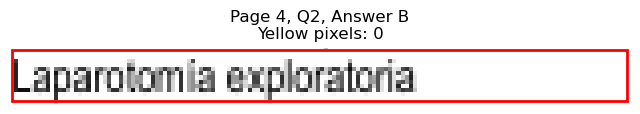

Page 4, Q2 - C: Detected box: x0=82.9, y0=249.1, x1=229.8, y1=261.8
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 742
Page 4, Q2, C: Yellow percentage: 0.0%


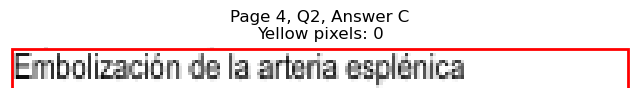

Page 4, Q2 - D: Detected box: x0=334.6, y0=223.9, x1=455.9, y1=236.6
Page 4, Q2, D: Yellow pixels: 1756
Page 4, Q2, D: Total non-white pixels: 2408
Page 4, Q2, D: Yellow percentage: 72.9%


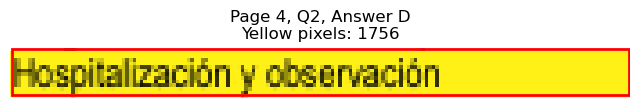

Page 4, Q2 - E: Detected box: x0=334.1, y0=236.5, x1=502.8, y1=249.2
Page 4, Q2, E: Yellow pixels: 191
Page 4, Q2, E: Total non-white pixels: 1037
Page 4, Q2, E: Yellow percentage: 18.4%


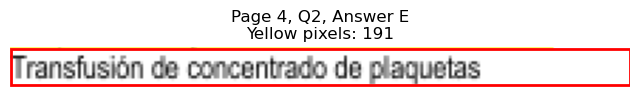


Page 4, Q2 - Selected Answer: D (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=82.5, y0=312.3, x1=209.4, y1=324.9
Page 4, Q3, A: Yellow pixels: 1841
Page 4, Q3, A: Total non-white pixels: 2314
Page 4, Q3, A: Yellow percentage: 79.6%


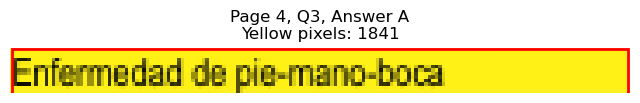

Page 4, Q3 - B: Detected box: x0=82.5, y0=324.9, x1=135.1, y1=337.5
Page 4, Q3, B: Yellow pixels: 103
Page 4, Q3, B: Total non-white pixels: 393
Page 4, Q3, B: Yellow percentage: 26.2%


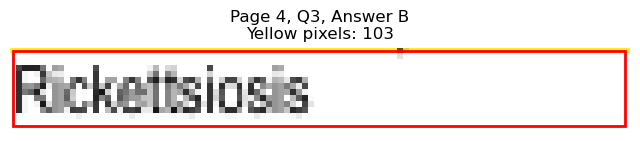

Page 4, Q3 - C: Detected box: x0=82.9, y0=337.5, x1=161.2, y1=350.1
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 405
Page 4, Q3, C: Yellow percentage: 0.0%


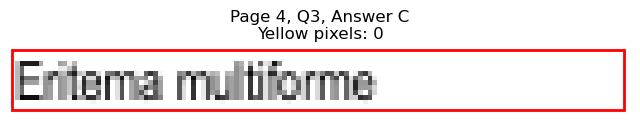

Page 4, Q3 - D: Detected box: x0=334.6, y0=312.3, x1=461.6, y1=324.9
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 601
Page 4, Q3, D: Yellow percentage: 0.0%


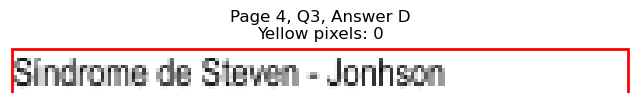

Page 4, Q3 - E: Detected box: x0=334.1, y0=324.9, x1=400.9, y1=337.5
Page 4, Q3, E: Yellow pixels: 0
Page 4, Q3, E: Total non-white pixels: 360
Page 4, Q3, E: Yellow percentage: 0.0%


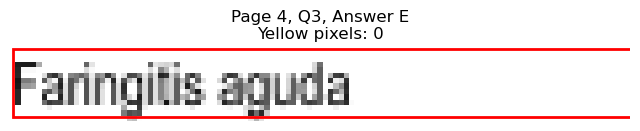


Page 4, Q3 - Selected Answer: A (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=82.5, y0=388.0, x1=132.1, y1=400.7
Page 4, Q4, A: Yellow pixels: 1121
Page 4, Q4, A: Total non-white pixels: 1313
Page 4, Q4, A: Yellow percentage: 85.4%


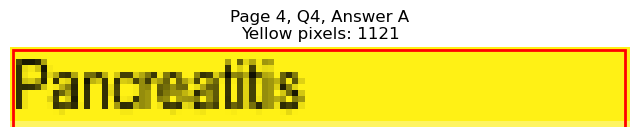

Page 4, Q4 - B: Detected box: x0=82.5, y0=400.6, x1=127.6, y1=413.3
Page 4, Q4, B: Yellow pixels: 96
Page 4, Q4, B: Total non-white pixels: 338
Page 4, Q4, B: Yellow percentage: 28.4%


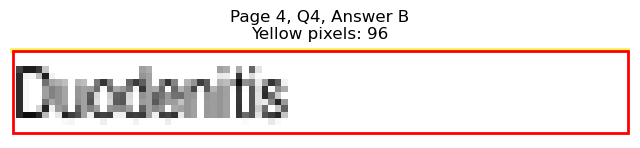

Page 4, Q4 - C: Detected box: x0=82.9, y0=413.3, x1=140.2, y1=426.0
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 280
Page 4, Q4, C: Yellow percentage: 0.0%


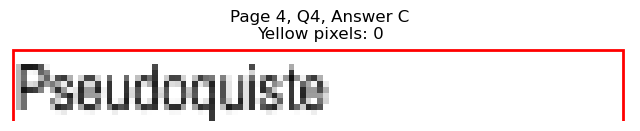

Page 4, Q4 - D: Detected box: x0=334.6, y0=388.0, x1=383.2, y1=400.7
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 252
Page 4, Q4, D: Yellow percentage: 0.0%


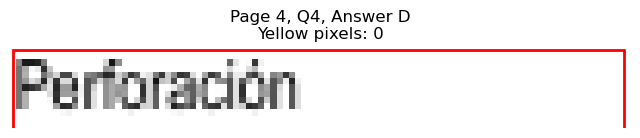

Page 4, Q4 - E: Detected box: x0=334.1, y0=400.6, x1=383.8, y1=413.3
Page 4, Q4, E: Yellow pixels: 0
Page 4, Q4, E: Total non-white pixels: 260
Page 4, Q4, E: Yellow percentage: 0.0%


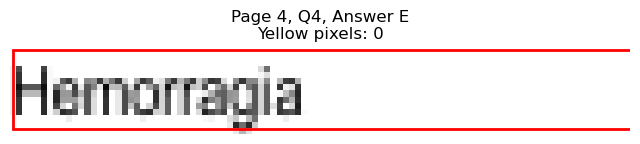


Page 4, Q4 - Selected Answer: A (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=82.5, y0=501.7, x1=164.2, y1=514.3
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 410
Page 4, Q5, A: Yellow percentage: 0.0%


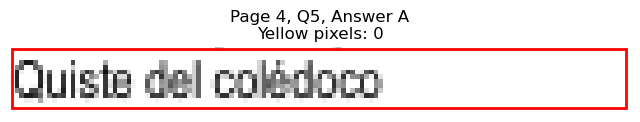

Page 4, Q5 - B: Detected box: x0=82.5, y0=514.3, x1=133.6, y1=526.9
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 262
Page 4, Q5, B: Yellow percentage: 0.0%


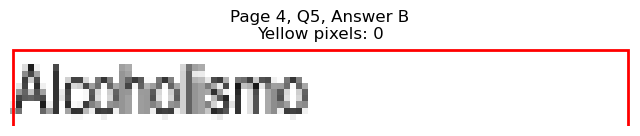

Page 4, Q5 - C: Detected box: x0=82.9, y0=526.9, x1=148.6, y1=539.5
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 349
Page 4, Q5, C: Yellow percentage: 0.0%


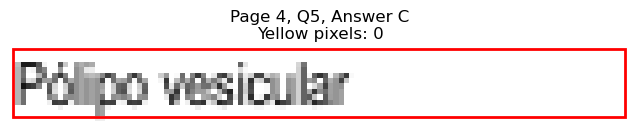

Page 4, Q5 - D: Detected box: x0=334.6, y0=501.7, x1=402.8, y1=514.3
Page 4, Q5, D: Yellow pixels: 1159
Page 4, Q5, D: Total non-white pixels: 1666
Page 4, Q5, D: Yellow percentage: 69.6%


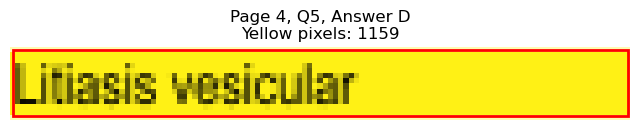

Page 4, Q5 - E: Detected box: x0=334.1, y0=514.3, x1=467.0, y1=526.9
Page 4, Q5, E: Yellow pixels: 0
Page 4, Q5, E: Total non-white pixels: 852
Page 4, Q5, E: Yellow percentage: 0.0%


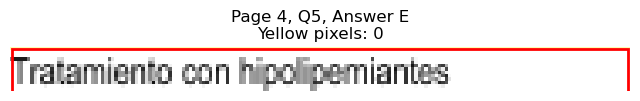


Page 4, Q5 - Selected Answer: D (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=82.5, y0=564.8, x1=206.3, y1=577.4
Page 4, Q6, A: Yellow pixels: 1616
Page 4, Q6, A: Total non-white pixels: 2450
Page 4, Q6, A: Yellow percentage: 66.0%


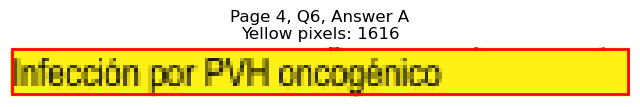

Page 4, Q6 - B: Detected box: x0=82.5, y0=577.4, x1=211.8, y1=590.0
Page 4, Q6, B: Yellow pixels: 3
Page 4, Q6, B: Total non-white pixels: 842
Page 4, Q6, B: Yellow percentage: 0.4%


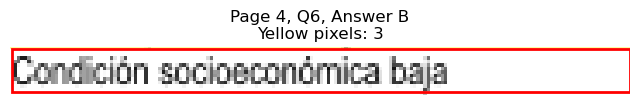

Page 4, Q6 - C: Detected box: x0=82.9, y0=590.0, x1=244.5, y1=602.6
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 795
Page 4, Q6, C: Yellow percentage: 0.0%


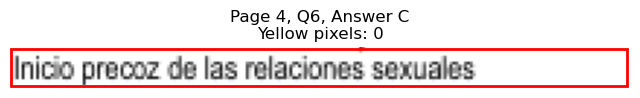

Page 4, Q6 - D: Detected box: x0=334.6, y0=564.8, x1=438.4, y1=577.4
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 509
Page 4, Q6, D: Yellow percentage: 0.0%


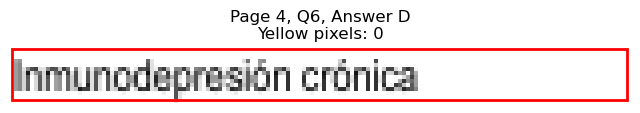

Page 4, Q6 - E: Detected box: x0=334.1, y0=577.4, x1=386.3, y1=590.0
Page 4, Q6, E: Yellow pixels: 0
Page 4, Q6, E: Total non-white pixels: 271
Page 4, Q6, E: Yellow percentage: 0.0%


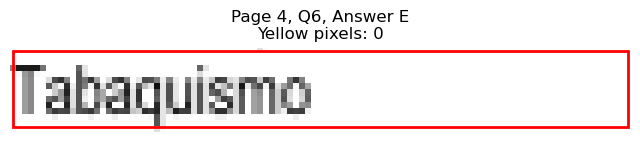


Page 4, Q6 - Selected Answer: A (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=82.5, y0=640.5, x1=100.0, y1=653.2
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 71
Page 4, Q7, A: Yellow percentage: 0.0%


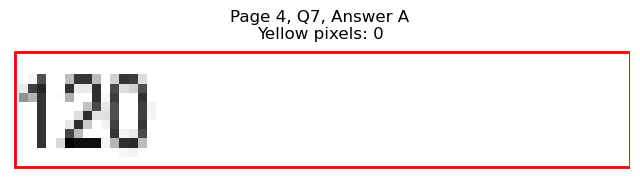

Page 4, Q7 - B: Detected box: x0=82.5, y0=653.1, x1=100.0, y1=665.8
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 141
Page 4, Q7, B: Yellow percentage: 0.0%


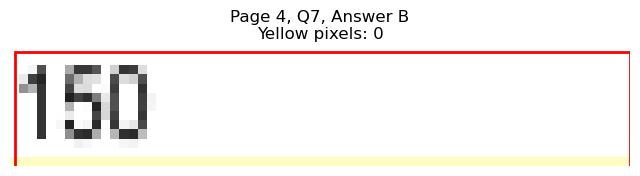

Page 4, Q7 - C: Detected box: x0=82.9, y0=665.7, x1=95.5, y1=678.4
Page 4, Q7, C: Yellow pixels: 709
Page 4, Q7, C: Total non-white pixels: 896
Page 4, Q7, C: Yellow percentage: 79.1%


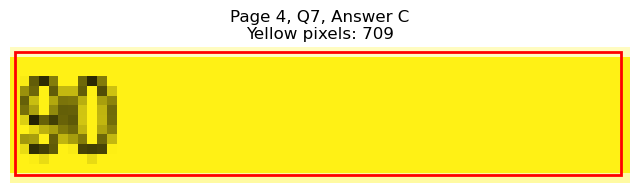

Page 4, Q7 - D: Detected box: x0=334.6, y0=640.5, x1=352.1, y1=653.2
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 79
Page 4, Q7, D: Yellow percentage: 0.0%


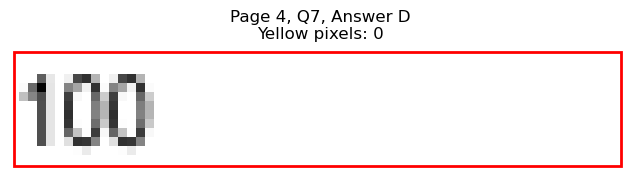

Page 4, Q7 - E: Detected box: x0=334.1, y0=653.1, x1=346.7, y1=665.8
Page 4, Q7, E: Yellow pixels: 0
Page 4, Q7, E: Total non-white pixels: 67
Page 4, Q7, E: Yellow percentage: 0.0%


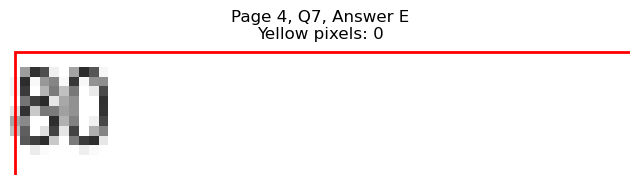


Page 4, Q7 - Selected Answer: C (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=82.5, y0=741.4, x1=142.7, y1=754.1
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 325
Page 4, Q8, A: Yellow percentage: 0.0%


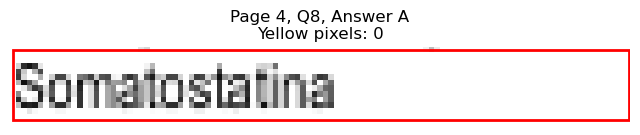

Page 4, Q8 - B: Detected box: x0=82.5, y0=754.0, x1=116.1, y1=766.7
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 150
Page 4, Q8, B: Yellow percentage: 0.0%


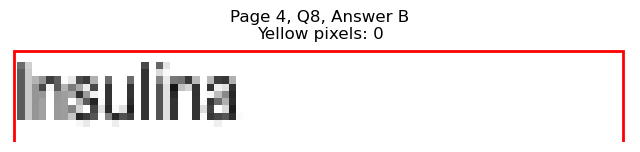

Page 4, Q8 - C: Detected box: x0=82.9, y0=766.8, x1=117.5, y1=779.4
Page 4, Q8, C: Yellow pixels: 900
Page 4, Q8, C: Total non-white pixels: 1204
Page 4, Q8, C: Yellow percentage: 74.8%


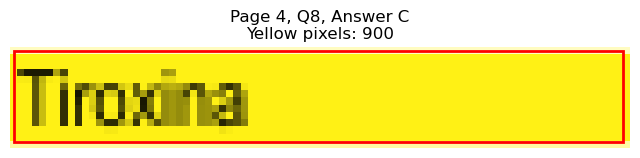

Page 4, Q8 - D: Detected box: x0=334.6, y0=741.4, x1=434.0, y1=754.1
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 522
Page 4, Q8, D: Yellow percentage: 0.0%


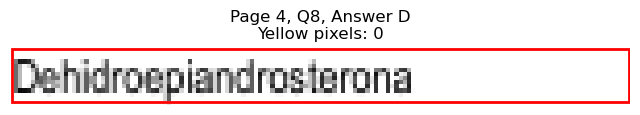

Page 4, Q8 - E: Detected box: x0=334.1, y0=754.0, x1=396.4, y1=766.7
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 321
Page 4, Q8, E: Yellow percentage: 0.0%


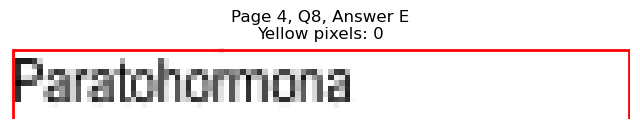


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)





Page 5: Found 8 questions
Page 5, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=197.3, y1=123.0
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 724
Page 5, Q1, A: Yellow percentage: 0.0%


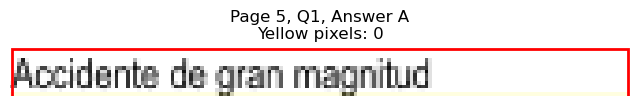

Page 5, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=160.7, y1=135.6
Page 5, Q1, B: Yellow pixels: 1365
Page 5, Q1, B: Total non-white pixels: 1806
Page 5, Q1, B: Yellow percentage: 75.6%


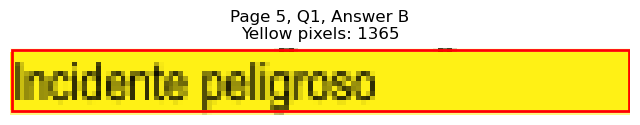

Page 5, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=113.5, y1=148.2
Page 5, Q1, C: Yellow pixels: 80
Page 5, Q1, C: Total non-white pixels: 250
Page 5, Q1, C: Yellow percentage: 32.0%


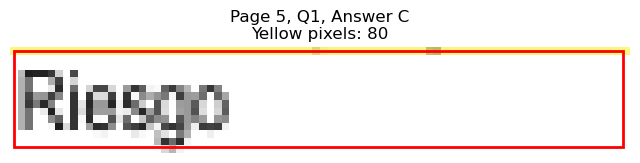

Page 5, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=373.7, y1=123.0
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 212
Page 5, Q1, D: Yellow percentage: 0.0%


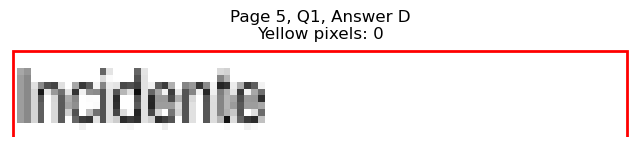

Page 5, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=376.3, y1=135.6
Page 5, Q1, E: Yellow pixels: 0
Page 5, Q1, E: Total non-white pixels: 215
Page 5, Q1, E: Yellow percentage: 0.0%


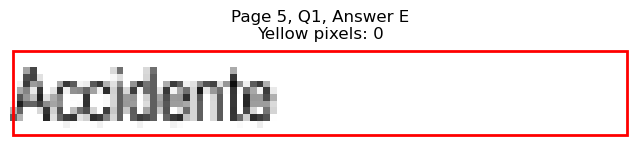


Page 5, Q1 - Selected Answer: B (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=82.5, y0=186.0, x1=201.9, y1=198.7
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 586
Page 5, Q2, A: Yellow percentage: 0.0%


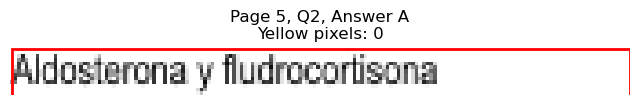

Page 5, Q2 - B: Detected box: x0=82.5, y0=198.6, x1=218.8, y1=211.3
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 695
Page 5, Q2, B: Yellow percentage: 0.0%


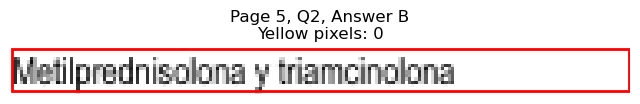

Page 5, Q2 - C: Detected box: x0=82.9, y0=211.3, x1=210.9, y1=224.0
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 600
Page 5, Q2, C: Yellow percentage: 0.0%


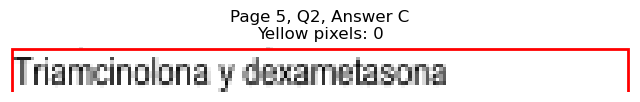

Page 5, Q2 - D: Detected box: x0=334.6, y0=186.0, x1=464.0, y1=198.7
Page 5, Q2, D: Yellow pixels: 1822
Page 5, Q2, D: Total non-white pixels: 2340
Page 5, Q2, D: Yellow percentage: 77.9%


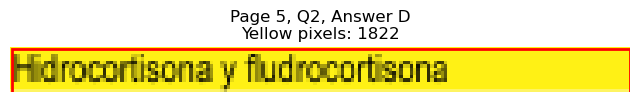

Page 5, Q2 - E: Detected box: x0=334.1, y0=198.6, x1=397.5, y1=211.3
Page 5, Q2, E: Yellow pixels: 113
Page 5, Q2, E: Total non-white pixels: 446
Page 5, Q2, E: Yellow percentage: 25.3%


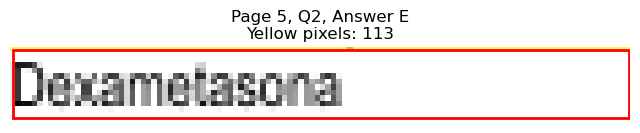


Page 5, Q2 - Selected Answer: D (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=82.5, y0=249.1, x1=145.7, y1=261.8
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 339
Page 5, Q3, A: Yellow percentage: 0.0%


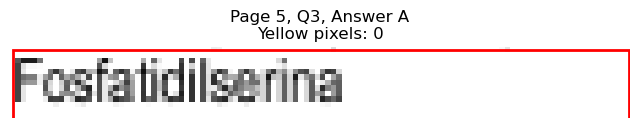

Page 5, Q3 - B: Detected box: x0=82.5, y0=261.7, x1=125.5, y1=274.4
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 228
Page 5, Q3, B: Yellow percentage: 0.0%


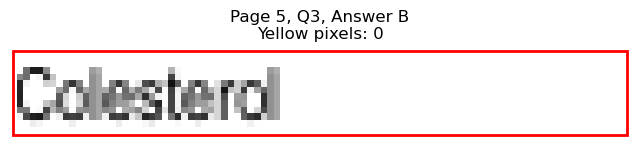

Page 5, Q3 - C: Detected box: x0=82.9, y0=274.5, x1=183.7, y1=287.1
Page 5, Q3, C: Yellow pixels: 1550
Page 5, Q3, C: Total non-white pixels: 2128
Page 5, Q3, C: Yellow percentage: 72.8%


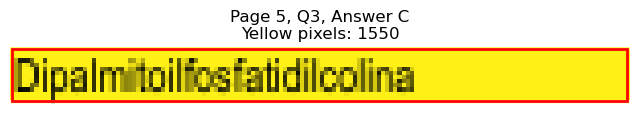

Page 5, Q3 - D: Detected box: x0=334.6, y0=249.1, x1=383.2, y1=261.8
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 264
Page 5, Q3, D: Yellow percentage: 0.0%


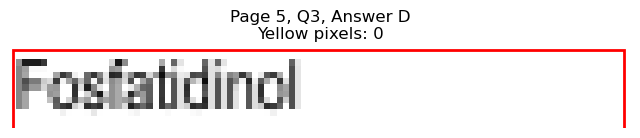

Page 5, Q3 - E: Detected box: x0=334.1, y0=261.7, x1=401.3, y1=274.4
Page 5, Q3, E: Yellow pixels: 0
Page 5, Q3, E: Total non-white pixels: 378
Page 5, Q3, E: Yellow percentage: 0.0%


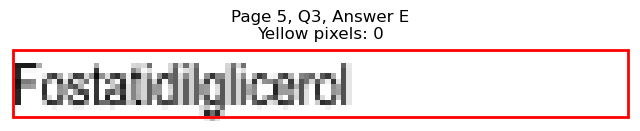


Page 5, Q3 - Selected Answer: C (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=82.5, y0=312.3, x1=201.9, y1=324.9
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 774
Page 5, Q4, A: Yellow percentage: 0.0%


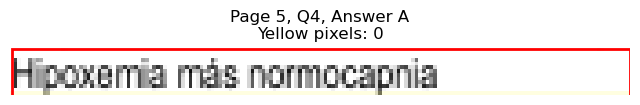

Page 5, Q4 - B: Detected box: x0=82.5, y0=324.9, x1=196.3, y1=337.5
Page 5, Q4, B: Yellow pixels: 1683
Page 5, Q4, B: Total non-white pixels: 2310
Page 5, Q4, B: Yellow percentage: 72.9%


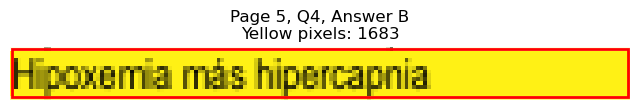

Page 5, Q4 - C: Detected box: x0=82.9, y0=337.5, x1=139.1, y1=350.1
Page 5, Q4, C: Yellow pixels: 108
Page 5, Q4, C: Total non-white pixels: 386
Page 5, Q4, C: Yellow percentage: 28.0%


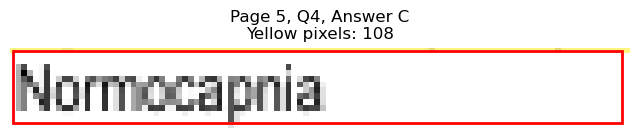

Page 5, Q4 - D: Detected box: x0=334.6, y0=312.3, x1=379.7, y1=324.9
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 232
Page 5, Q4, D: Yellow percentage: 0.0%


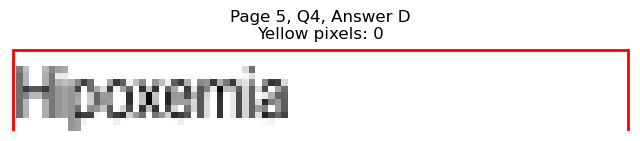

Page 5, Q4 - E: Detected box: x0=334.1, y0=324.9, x1=384.8, y1=337.5
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 281
Page 5, Q4, E: Yellow percentage: 0.0%


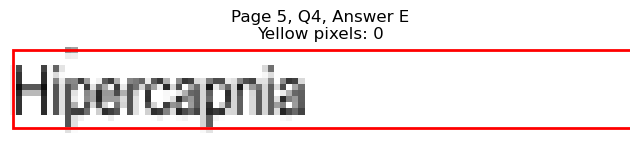


Page 5, Q4 - Selected Answer: B (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=82.5, y0=400.6, x1=91.0, y1=413.3
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 29
Page 5, Q5, A: Yellow percentage: 0.0%


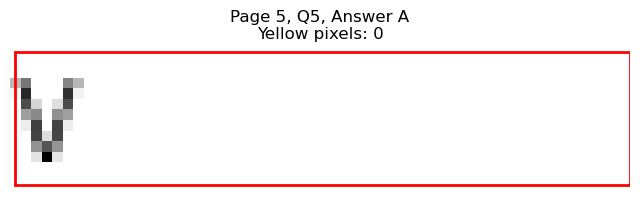

Page 5, Q5 - B: Detected box: x0=82.5, y0=413.3, x1=97.6, y1=426.0
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 76
Page 5, Q5, B: Yellow percentage: 0.0%


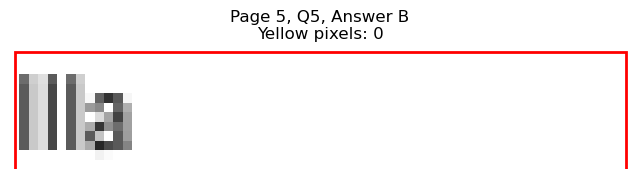

Page 5, Q5 - C: Detected box: x0=70.8, y0=425.9, x1=79.8, y1=438.6
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 68
Page 5, Q5, C: Yellow percentage: 0.0%


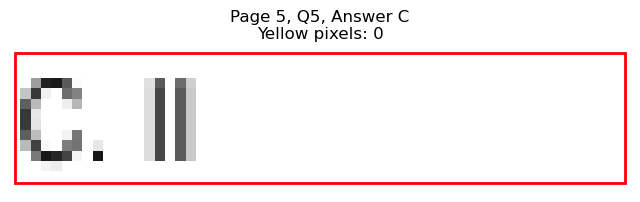

Page 5, Q5 - D: Detected box: x0=334.6, y0=400.6, x1=349.7, y1=413.3
Page 5, Q5, D: Yellow pixels: 727
Page 5, Q5, D: Total non-white pixels: 924
Page 5, Q5, D: Yellow percentage: 78.7%


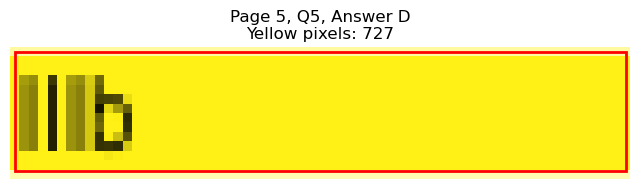

Page 5, Q5 - E: Detected box: x0=334.1, y0=413.3, x1=345.2, y1=426.0
Page 5, Q5, E: Yellow pixels: 0
Page 5, Q5, E: Total non-white pixels: 98
Page 5, Q5, E: Yellow percentage: 0.0%


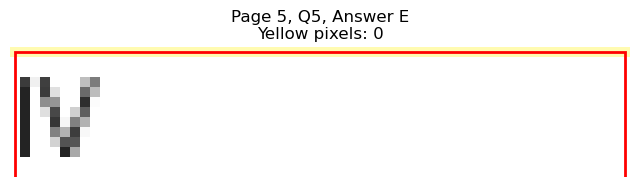


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=82.5, y0=501.7, x1=185.3, y1=514.3
Page 5, Q6, A: Yellow pixels: 154
Page 5, Q6, A: Total non-white pixels: 676
Page 5, Q6, A: Yellow percentage: 22.8%


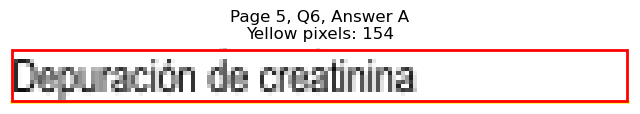

Page 5, Q6 - B: Detected box: x0=82.5, y0=514.3, x1=146.2, y1=526.9
Page 5, Q6, B: Yellow pixels: 1242
Page 5, Q6, B: Total non-white pixels: 1495
Page 5, Q6, B: Yellow percentage: 83.1%


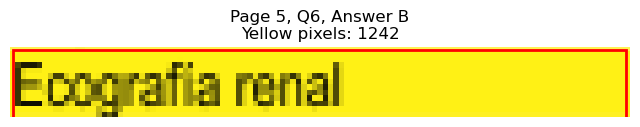

Page 5, Q6 - C: Detected box: x0=82.9, y0=526.9, x1=215.9, y1=539.5
Page 5, Q6, C: Yellow pixels: 180
Page 5, Q6, C: Total non-white pixels: 856
Page 5, Q6, C: Yellow percentage: 21.0%


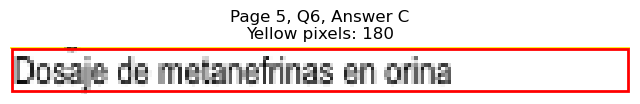

Page 5, Q6 - D: Detected box: x0=334.6, y0=501.7, x1=452.0, y1=514.3
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 565
Page 5, Q6, D: Yellow percentage: 0.0%


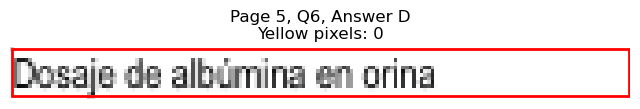

Page 5, Q6 - E: Detected box: x0=334.1, y0=514.3, x1=459.5, y1=526.9
Page 5, Q6, E: Yellow pixels: 0
Page 5, Q6, E: Total non-white pixels: 621
Page 5, Q6, E: Yellow percentage: 0.0%


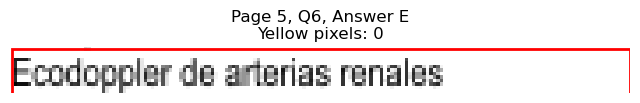


Page 5, Q6 - Selected Answer: B (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=82.5, y0=590.0, x1=142.1, y1=602.6
Page 5, Q7, A: Yellow pixels: 111
Page 5, Q7, A: Total non-white pixels: 404
Page 5, Q7, A: Yellow percentage: 27.5%


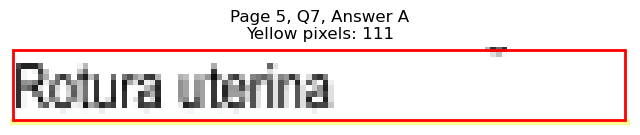

Page 5, Q7 - B: Detected box: x0=82.5, y0=602.6, x1=171.7, y1=615.2
Page 5, Q7, B: Yellow pixels: 1449
Page 5, Q7, B: Total non-white pixels: 1960
Page 5, Q7, B: Yellow percentage: 73.9%


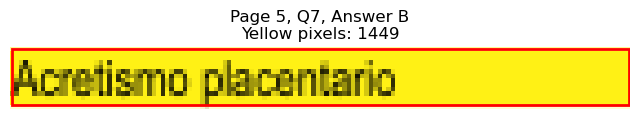

Page 5, Q7 - C: Detected box: x0=82.9, y0=615.2, x1=176.2, y1=627.8
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 635
Page 5, Q7, C: Yellow percentage: 0.0%


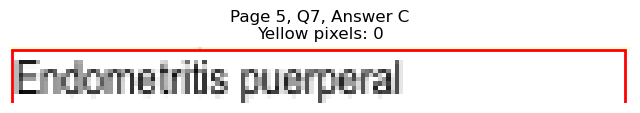

Page 5, Q7 - D: Detected box: x0=334.6, y0=590.0, x1=407.3, y1=602.6
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 375
Page 5, Q7, D: Yellow percentage: 0.0%


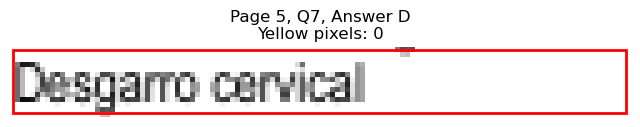

Page 5, Q7 - E: Detected box: x0=334.1, y0=602.6, x1=416.9, y1=615.2
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 430
Page 5, Q7, E: Yellow percentage: 0.0%


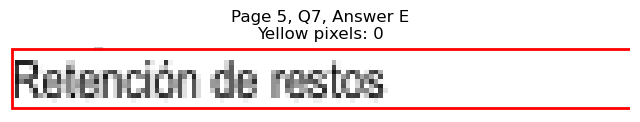


Page 5, Q7 - Selected Answer: B (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=82.5, y0=653.1, x1=94.0, y1=665.8
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 41
Page 5, Q8, A: Yellow percentage: 0.0%


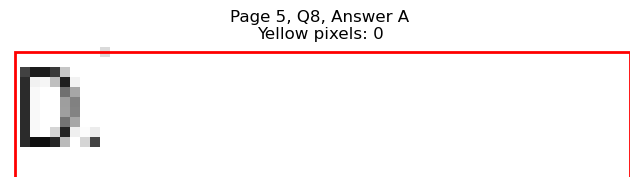

Page 5, Q8 - B: Detected box: x0=82.5, y0=665.7, x1=94.5, y1=678.4
Page 5, Q8, B: Yellow pixels: 63
Page 5, Q8, B: Total non-white pixels: 102
Page 5, Q8, B: Yellow percentage: 61.8%


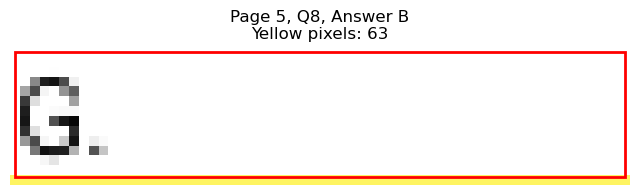

Page 5, Q8 - C: Detected box: x0=82.9, y0=678.3, x1=94.0, y1=691.0
Page 5, Q8, C: Yellow pixels: 774
Page 5, Q8, C: Total non-white pixels: 806
Page 5, Q8, C: Yellow percentage: 96.0%


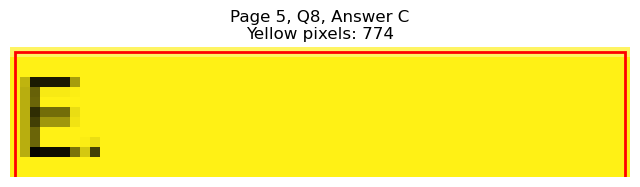

Page 5, Q8 - D: Detected box: x0=334.6, y0=653.1, x1=347.2, y1=665.8
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 50
Page 5, Q8, D: Yellow percentage: 0.0%


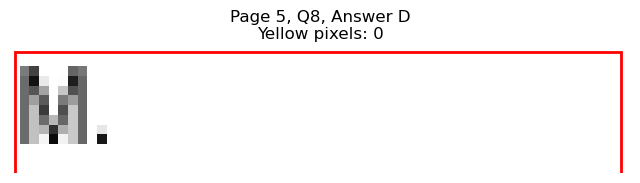

Page 5, Q8 - E: Detected box: x0=334.1, y0=665.7, x1=345.2, y1=678.4
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 34
Page 5, Q8, E: Yellow percentage: 0.0%


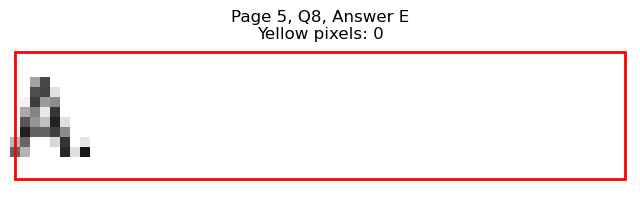


Page 5, Q8 - Selected Answer: C (based on yellow pixel count)





Page 6: Found 7 questions
Page 6, Q1 - A: Detected box: x0=82.5, y0=135.5, x1=215.0, y1=148.2
Page 6, Q1, A: Yellow pixels: 1899
Page 6, Q1, A: Total non-white pixels: 2562
Page 6, Q1, A: Yellow percentage: 74.1%


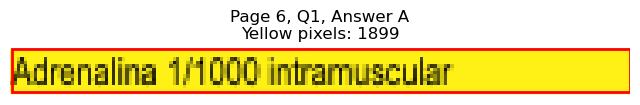

Page 6, Q1 - B: Detected box: x0=82.5, y0=148.2, x1=212.3, y1=160.9
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 859
Page 6, Q1, B: Yellow percentage: 0.0%


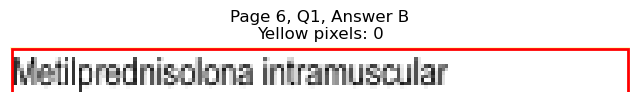

Page 6, Q1 - C: Detected box: x0=82.9, y0=160.8, x1=151.1, y1=173.5
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 327
Page 6, Q1, C: Yellow percentage: 0.0%


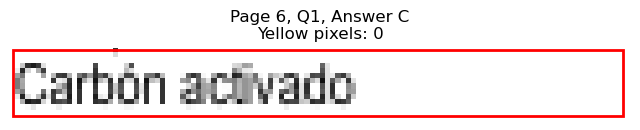

Page 6, Q1 - D: Detected box: x0=334.6, y0=135.5, x1=428.5, y1=148.2
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 494
Page 6, Q1, D: Yellow percentage: 0.0%


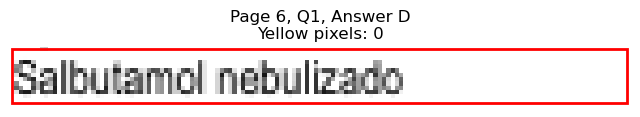

Page 6, Q1 - E: Detected box: x0=334.1, y0=148.2, x1=410.9, y1=160.9
Page 6, Q1, E: Yellow pixels: 0
Page 6, Q1, E: Total non-white pixels: 361
Page 6, Q1, E: Yellow percentage: 0.0%


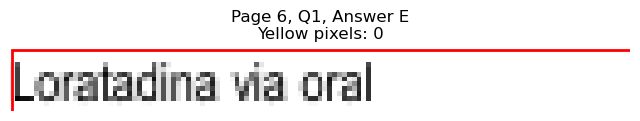


Page 6, Q1 - Selected Answer: A (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=82.5, y0=211.3, x1=129.1, y1=224.0
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 244
Page 6, Q2, A: Yellow percentage: 0.0%


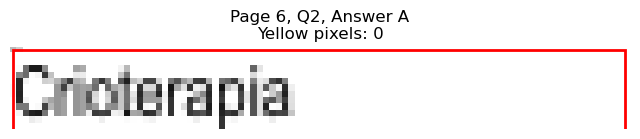

Page 6, Q2 - B: Detected box: x0=82.5, y0=223.9, x1=141.6, y1=236.6
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 293
Page 6, Q2, B: Yellow percentage: 0.0%


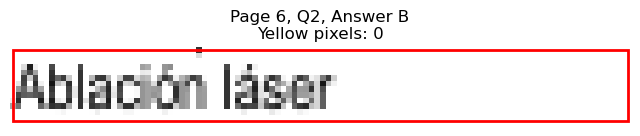

Page 6, Q2 - C: Detected box: x0=82.9, y0=236.5, x1=170.2, y1=249.2
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 447
Page 6, Q2, C: Yellow percentage: 0.0%


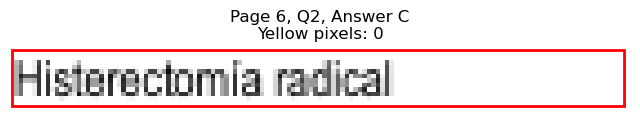

Page 6, Q2 - D: Detected box: x0=334.6, y0=211.3, x1=418.4, y1=224.0
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 559
Page 6, Q2, D: Yellow percentage: 0.0%


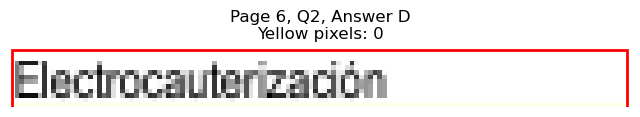

Page 6, Q2 - E: Detected box: x0=334.1, y0=223.9, x1=373.7, y1=236.6
Page 6, Q2, E: Yellow pixels: 1038
Page 6, Q2, E: Total non-white pixels: 1260
Page 6, Q2, E: Yellow percentage: 82.4%


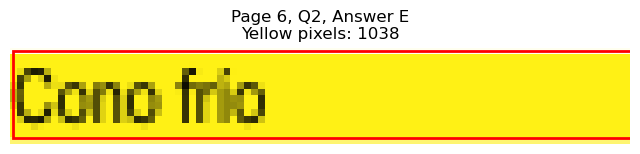


Page 6, Q2 - Selected Answer: E (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=82.5, y0=299.7, x1=155.7, y1=312.3
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 385
Page 6, Q3, A: Yellow percentage: 0.0%


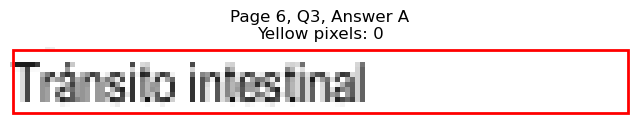

Page 6, Q3 - B: Detected box: x0=82.5, y0=312.3, x1=158.2, y1=324.9
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 377
Page 6, Q3, B: Yellow percentage: 0.0%


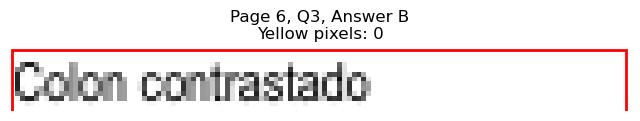

Page 6, Q3 - C: Detected box: x0=82.9, y0=324.9, x1=213.4, y1=337.5
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 663
Page 6, Q3, C: Yellow percentage: 0.0%


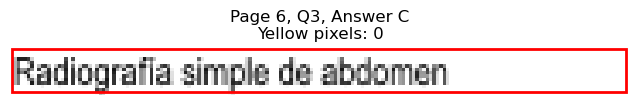

Page 6, Q3 - D: Detected box: x0=334.6, y0=299.7, x1=425.3, y1=312.3
Page 6, Q3, D: Yellow pixels: 142
Page 6, Q3, D: Total non-white pixels: 596
Page 6, Q3, D: Yellow percentage: 23.8%


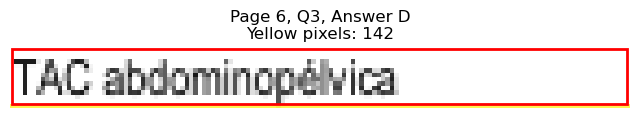

Page 6, Q3 - E: Detected box: x0=334.1, y0=312.3, x1=419.5, y1=324.9
Page 6, Q3, E: Yellow pixels: 1417
Page 6, Q3, E: Total non-white pixels: 1768
Page 6, Q3, E: Yellow percentage: 80.1%


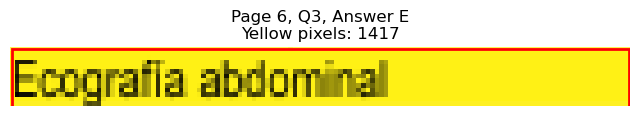


Page 6, Q3 - Selected Answer: E (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=82.5, y0=400.6, x1=105.0, y1=413.3
Page 6, Q4, A: Yellow pixels: 819
Page 6, Q4, A: Total non-white pixels: 1036
Page 6, Q4, A: Yellow percentage: 79.1%


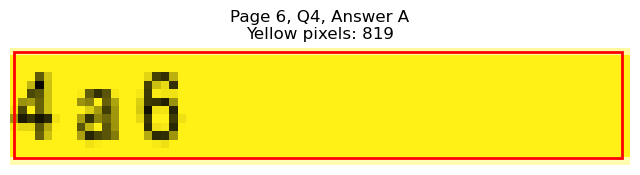

Page 6, Q4 - B: Detected box: x0=82.5, y0=413.3, x1=115.1, y1=426.0
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 201
Page 6, Q4, B: Yellow percentage: 0.0%


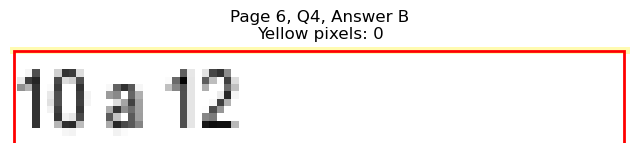

Page 6, Q4 - C: Detected box: x0=82.9, y0=425.9, x1=110.5, y1=438.6
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 110
Page 6, Q4, C: Yellow percentage: 0.0%


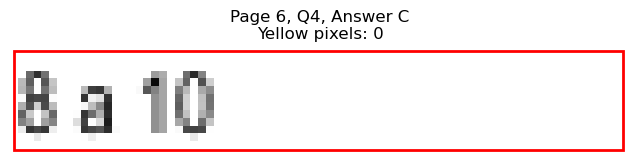

Page 6, Q4 - D: Detected box: x0=334.6, y0=400.6, x1=357.2, y1=413.3
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 73
Page 6, Q4, D: Yellow percentage: 0.0%


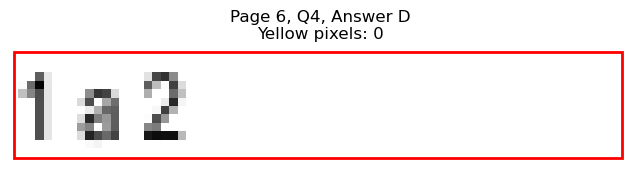

Page 6, Q4 - E: Detected box: x0=334.1, y0=413.3, x1=366.8, y1=426.0
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 124
Page 6, Q4, E: Yellow percentage: 0.0%


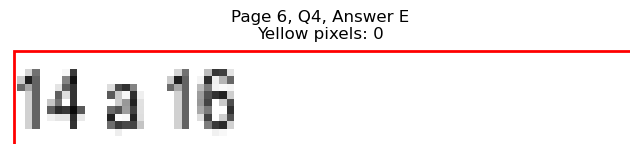


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=82.5, y0=514.3, x1=185.4, y1=526.9
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 497
Page 6, Q5, A: Yellow percentage: 0.0%


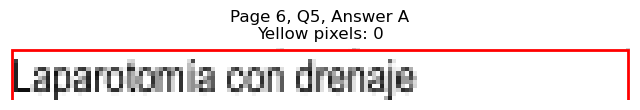

Page 6, Q5 - B: Detected box: x0=82.5, y0=526.9, x1=233.0, y1=539.5
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 787
Page 6, Q5, B: Yellow percentage: 0.0%


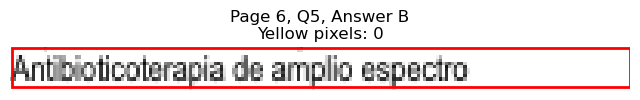

Page 6, Q5 - C: Detected box: x0=82.9, y0=539.5, x1=150.1, y1=552.1
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 351
Page 6, Q5, C: Yellow percentage: 0.0%


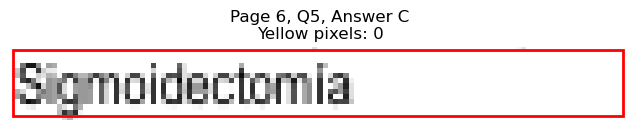

Page 6, Q5 - D: Detected box: x0=334.6, y0=514.3, x1=416.3, y1=526.9
Page 6, Q5, D: Yellow pixels: 1379
Page 6, Q5, D: Total non-white pixels: 1729
Page 6, Q5, D: Yellow percentage: 79.8%


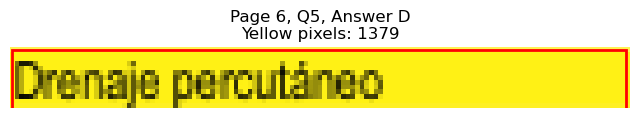

Page 6, Q5 - E: Detected box: x0=334.1, y0=526.9, x1=424.4, y1=539.5
Page 6, Q5, E: Yellow pixels: 138
Page 6, Q5, E: Total non-white pixels: 582
Page 6, Q5, E: Yellow percentage: 23.7%


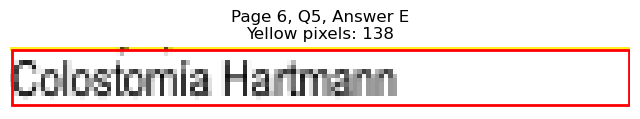


Page 6, Q5 - Selected Answer: D (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=82.5, y0=590.0, x1=191.3, y1=602.6
Page 6, Q6, A: Yellow pixels: 160
Page 6, Q6, A: Total non-white pixels: 718
Page 6, Q6, A: Yellow percentage: 22.3%


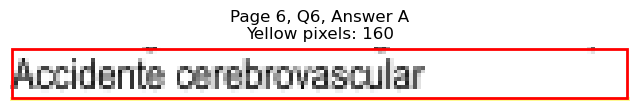

Page 6, Q6 - B: Detected box: x0=82.5, y0=602.6, x1=157.2, y1=615.2
Page 6, Q6, B: Yellow pixels: 1359
Page 6, Q6, B: Total non-white pixels: 1764
Page 6, Q6, B: Yellow percentage: 77.0%


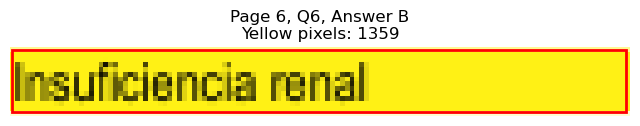

Page 6, Q6 - C: Detected box: x0=82.9, y0=615.2, x1=139.2, y1=627.8
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 378
Page 6, Q6, C: Yellow percentage: 0.0%


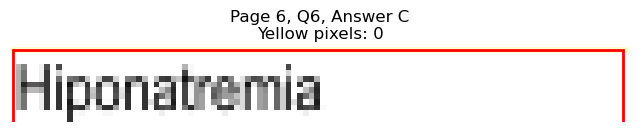

Page 6, Q6 - D: Detected box: x0=334.6, y0=590.0, x1=419.8, y1=602.6
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 433
Page 6, Q6, D: Yellow percentage: 0.0%


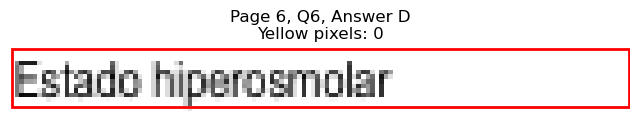

Page 6, Q6 - E: Detected box: x0=334.1, y0=602.6, x1=463.5, y1=615.2
Page 6, Q6, E: Yellow pixels: 0
Page 6, Q6, E: Total non-white pixels: 652
Page 6, Q6, E: Yellow percentage: 0.0%


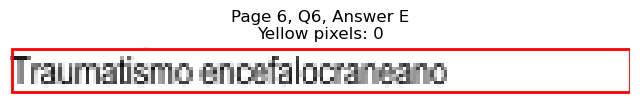


Page 6, Q6 - Selected Answer: B (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=82.5, y0=678.3, x1=150.6, y1=691.0
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 338
Page 6, Q7, A: Yellow percentage: 0.0%


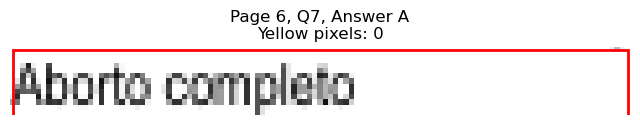

Page 6, Q7 - B: Detected box: x0=82.5, y0=691.1, x1=148.7, y1=703.7
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 301
Page 6, Q7, B: Yellow percentage: 0.0%


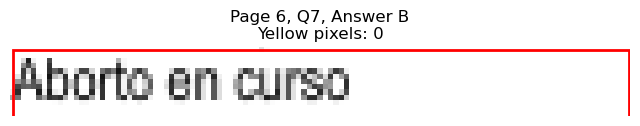

Page 6, Q7 - C: Detected box: x0=82.9, y0=703.7, x1=158.2, y1=716.3
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 385
Page 6, Q7, C: Yellow percentage: 0.0%


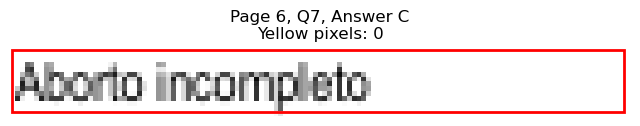

Page 6, Q7 - D: Detected box: x0=334.6, y0=678.3, x1=391.7, y1=691.0
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 271
Page 6, Q7, D: Yellow percentage: 0.0%


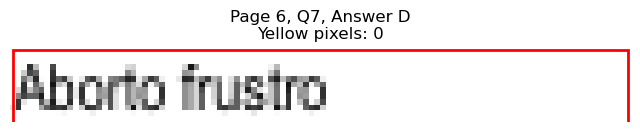

Page 6, Q7 - E: Detected box: x0=334.1, y0=691.1, x1=413.0, y1=703.7
Page 6, Q7, E: Yellow pixels: 1389
Page 6, Q7, E: Total non-white pixels: 1677
Page 6, Q7, E: Yellow percentage: 82.8%


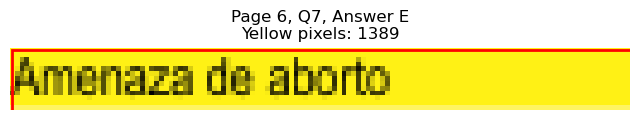


Page 6, Q7 - Selected Answer: E (based on yellow pixel count)





Page 7: Found 7 questions
Page 7, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=152.7, y1=123.0
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 339
Page 7, Q1, A: Yellow percentage: 0.0%


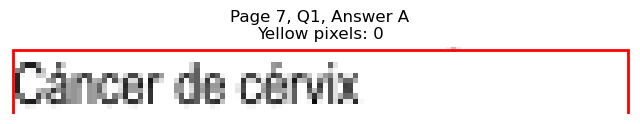

Page 7, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=156.7, y1=135.6
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 359
Page 7, Q1, B: Yellow percentage: 0.0%


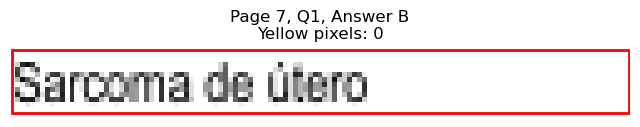

Page 7, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=176.7, y1=148.2
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 458
Page 7, Q1, C: Yellow percentage: 0.0%


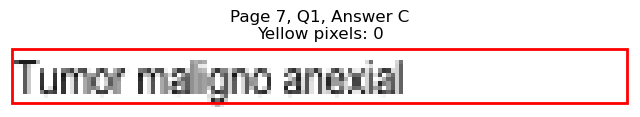

Page 7, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=426.4, y1=123.0
Page 7, Q1, D: Yellow pixels: 1501
Page 7, Q1, D: Total non-white pixels: 1859
Page 7, Q1, D: Yellow percentage: 80.7%


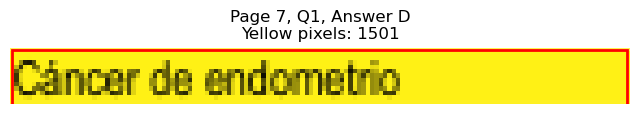

Page 7, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=402.9, y1=135.6
Page 7, Q1, E: Yellow pixels: 119
Page 7, Q1, E: Total non-white pixels: 491
Page 7, Q1, E: Yellow percentage: 24.2%


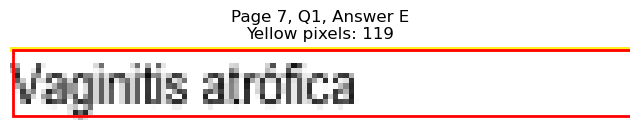


Page 7, Q1 - Selected Answer: D (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=82.5, y0=173.4, x1=159.7, y1=186.1
Page 7, Q2, A: Yellow pixels: 128
Page 7, Q2, A: Total non-white pixels: 527
Page 7, Q2, A: Yellow percentage: 24.3%


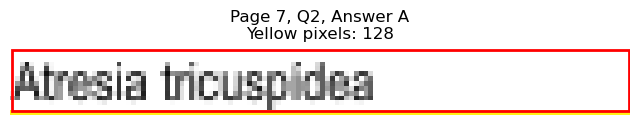

Page 7, Q2 - B: Detected box: x0=82.5, y0=186.0, x1=207.9, y1=198.7
Page 7, Q2, B: Yellow pixels: 1771
Page 7, Q2, B: Total non-white pixels: 2288
Page 7, Q2, B: Yellow percentage: 77.4%


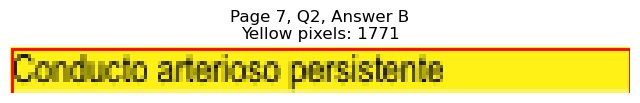

Page 7, Q2 - C: Detected box: x0=82.9, y0=198.6, x1=100.5, y1=211.3
Page 7, Q2, C: Yellow pixels: 69
Page 7, Q2, C: Total non-white pixels: 144
Page 7, Q2, C: Yellow percentage: 47.9%


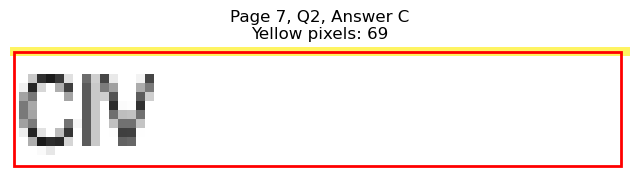

Page 7, Q2 - D: Detected box: x0=334.6, y0=173.4, x1=455.5, y1=186.1
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 584
Page 7, Q2, D: Yellow percentage: 0.0%


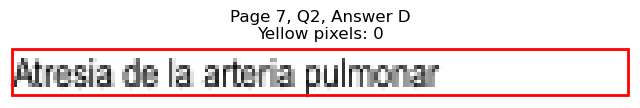

Page 7, Q2 - E: Detected box: x0=334.1, y0=186.0, x1=351.7, y1=198.7
Page 7, Q2, E: Yellow pixels: 0
Page 7, Q2, E: Total non-white pixels: 81
Page 7, Q2, E: Yellow percentage: 0.0%


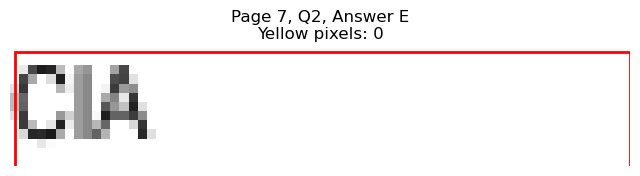


Page 7, Q2 - Selected Answer: B (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=82.5, y0=287.1, x1=146.2, y1=299.7
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 346
Page 7, Q3, A: Yellow percentage: 0.0%


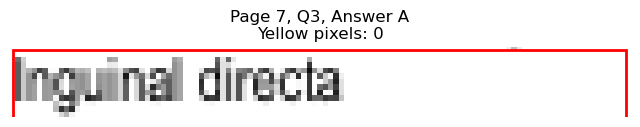

Page 7, Q3 - B: Detected box: x0=82.5, y0=299.7, x1=109.6, y1=312.3
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 135
Page 7, Q3, B: Yellow percentage: 0.0%


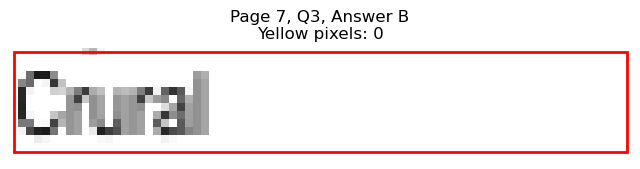

Page 7, Q3 - C: Detected box: x0=82.9, y0=312.3, x1=153.6, y1=324.9
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 339
Page 7, Q3, C: Yellow percentage: 0.0%


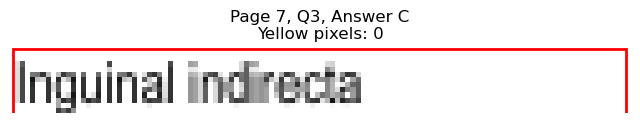

Page 7, Q3 - D: Detected box: x0=334.6, y0=287.1, x1=408.9, y1=299.7
Page 7, Q3, D: Yellow pixels: 1341
Page 7, Q3, D: Total non-white pixels: 1625
Page 7, Q3, D: Yellow percentage: 82.5%


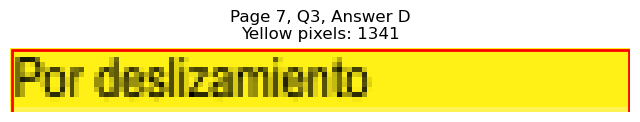

Page 7, Q3 - E: Detected box: x0=334.1, y0=299.7, x1=379.3, y1=312.3
Page 7, Q3, E: Yellow pixels: 96
Page 7, Q3, E: Total non-white pixels: 321
Page 7, Q3, E: Yellow percentage: 29.9%


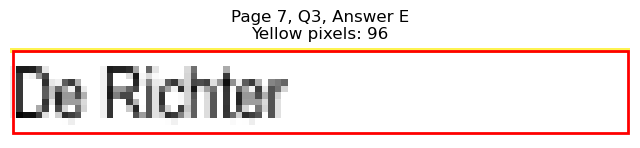


Page 7, Q3 - Selected Answer: D (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=82.5, y0=375.4, x1=132.1, y1=388.1
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 249
Page 7, Q4, A: Yellow percentage: 0.0%


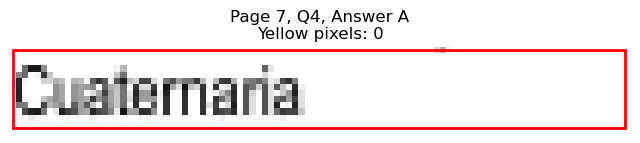

Page 7, Q4 - B: Detected box: x0=82.5, y0=388.0, x1=130.6, y1=400.7
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 257
Page 7, Q4, B: Yellow percentage: 0.0%


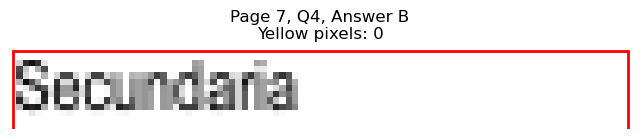

Page 7, Q4 - C: Detected box: x0=82.9, y0=400.6, x1=120.5, y1=413.3
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 189
Page 7, Q4, C: Yellow percentage: 0.0%


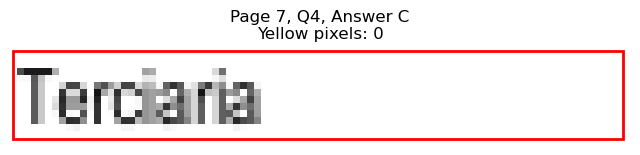

Page 7, Q4 - D: Detected box: x0=334.6, y0=375.4, x1=469.7, y1=388.1
Page 7, Q4, D: Yellow pixels: 186
Page 7, Q4, D: Total non-white pixels: 844
Page 7, Q4, D: Yellow percentage: 22.0%


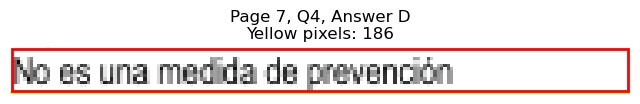

Page 7, Q4 - E: Detected box: x0=334.1, y0=388.0, x1=370.3, y1=400.7
Page 7, Q4, E: Yellow pixels: 997
Page 7, Q4, E: Total non-white pixels: 1131
Page 7, Q4, E: Yellow percentage: 88.2%


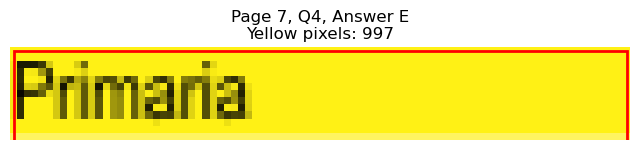


Page 7, Q4 - Selected Answer: E (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=82.5, y0=476.3, x1=202.4, y1=489.0
Page 7, Q5, A: Yellow pixels: 1734
Page 7, Q5, A: Total non-white pixels: 2394
Page 7, Q5, A: Yellow percentage: 72.4%


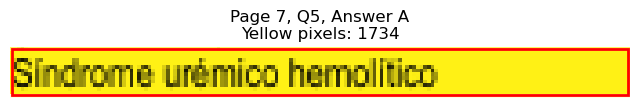

Page 7, Q5 - B: Detected box: x0=82.5, y0=489.1, x1=172.7, y1=501.7
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 610
Page 7, Q5, B: Yellow percentage: 0.0%


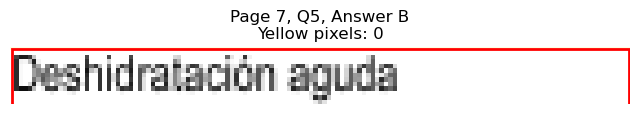

Page 7, Q5 - C: Detected box: x0=82.9, y0=501.7, x1=162.1, y1=514.3
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 399
Page 7, Q5, C: Yellow percentage: 0.0%


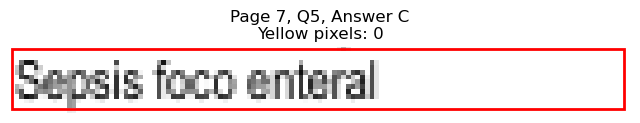

Page 7, Q5 - D: Detected box: x0=334.6, y0=476.3, x1=434.5, y1=489.0
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 520
Page 7, Q5, D: Yellow percentage: 0.0%


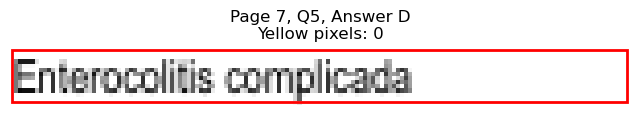

Page 7, Q5 - E: Detected box: x0=334.1, y0=489.1, x1=405.4, y1=501.7
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 362
Page 7, Q5, E: Yellow percentage: 0.0%


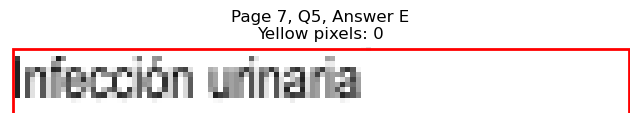


Page 7, Q5 - Selected Answer: A (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=151.9, y0=602.6, x1=223.1, y1=615.2
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 587
Page 7, Q6, A: Yellow percentage: 0.0%


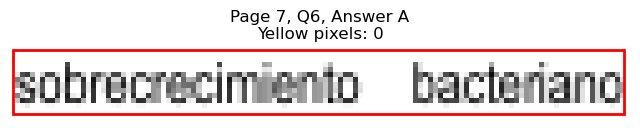

Page 7, Q6 - B: Detected box: x0=82.5, y0=627.9, x1=273.5, y1=640.6
Page 7, Q6, B: Yellow pixels: 3
Page 7, Q6, B: Total non-white pixels: 978
Page 7, Q6, B: Yellow percentage: 0.3%


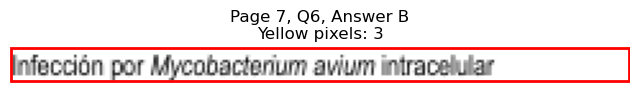

Page 7, Q6 - C: Detected box: x0=82.9, y0=640.5, x1=202.8, y1=653.2
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 622
Page 7, Q6, C: Yellow percentage: 0.0%


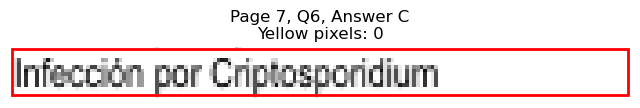

Page 7, Q6 - D: Detected box: x0=334.6, y0=602.6, x1=478.1, y1=615.2
Page 7, Q6, D: Yellow pixels: 192
Page 7, Q6, D: Total non-white pixels: 959
Page 7, Q6, D: Yellow percentage: 20.0%


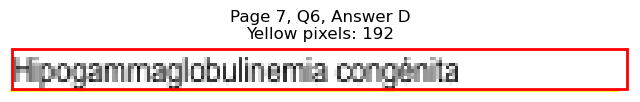

Page 7, Q6 - E: Detected box: x0=334.1, y0=615.2, x1=433.5, y1=627.8
Page 7, Q6, E: Yellow pixels: 1527
Page 7, Q6, E: Total non-white pixels: 1950
Page 7, Q6, E: Yellow percentage: 78.3%


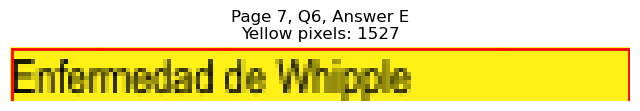


Page 7, Q6 - Selected Answer: E (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=82.5, y0=703.7, x1=176.8, y1=716.3
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 483
Page 7, Q7, A: Yellow percentage: 0.0%


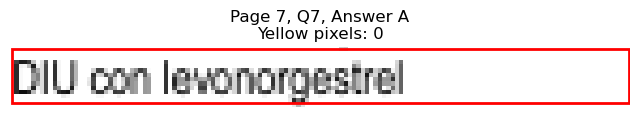

Page 7, Q7 - B: Detected box: x0=82.5, y0=716.3, x1=184.3, y1=728.9
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 546
Page 7, Q7, B: Yellow percentage: 0.0%


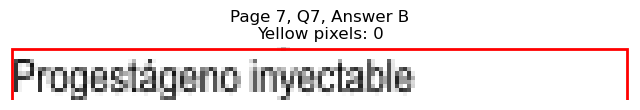

Page 7, Q7 - C: Detected box: x0=82.9, y0=728.9, x1=160.7, y1=741.5
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 405
Page 7, Q7, C: Yellow percentage: 0.0%


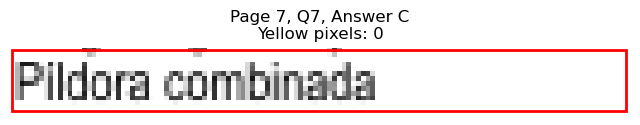

Page 7, Q7 - D: Detected box: x0=334.6, y0=703.7, x1=394.7, y1=716.3
Page 7, Q7, D: Yellow pixels: 1112
Page 7, Q7, D: Total non-white pixels: 1554
Page 7, Q7, D: Yellow percentage: 71.6%


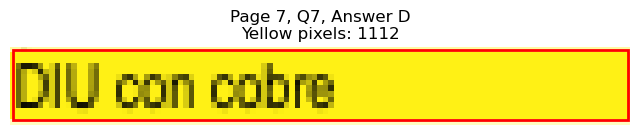

Page 7, Q7 - E: Detected box: x0=334.1, y0=716.3, x1=444.0, y1=728.9
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 729
Page 7, Q7, E: Yellow percentage: 0.0%


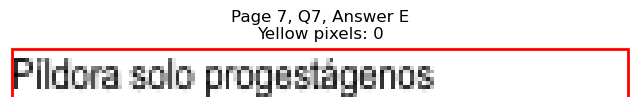


Page 7, Q7 - Selected Answer: D (based on yellow pixel count)





Page 8: Found 8 questions
Page 8, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=164.2, y1=110.4
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 418
Page 8, Q1, A: Yellow percentage: 0.0%


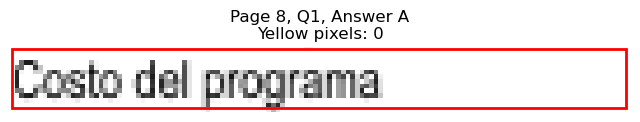

Page 8, Q1 - B: Detected box: x0=82.5, y0=110.3, x1=207.9, y1=123.0
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 623
Page 8, Q1, B: Yellow percentage: 0.0%


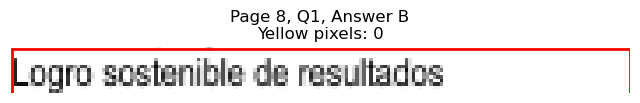

Page 8, Q1 - C: Detected box: x0=82.9, y0=122.9, x1=219.4, y1=135.6
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 711
Page 8, Q1, C: Yellow percentage: 0.0%


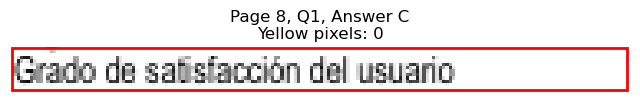

Page 8, Q1 - D: Detected box: x0=334.6, y0=97.7, x1=484.7, y1=110.4
Page 8, Q1, D: Yellow pixels: 1746
Page 8, Q1, D: Total non-white pixels: 2688
Page 8, Q1, D: Yellow percentage: 65.0%


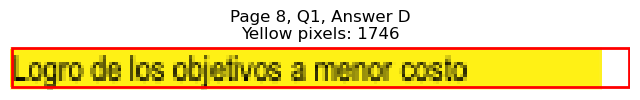

Page 8, Q1 - E: Detected box: x0=334.1, y0=110.3, x1=480.1, y1=123.0
Page 8, Q1, E: Yellow pixels: 1
Page 8, Q1, E: Total non-white pixels: 906
Page 8, Q1, E: Yellow percentage: 0.1%


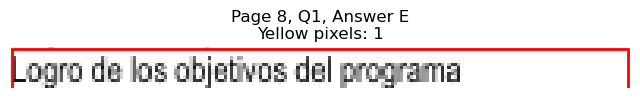


Page 8, Q1 - Selected Answer: D (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=82.5, y0=186.0, x1=124.6, y1=198.7
Page 8, Q2, A: Yellow pixels: 1048
Page 8, Q2, A: Total non-white pixels: 1209
Page 8, Q2, A: Yellow percentage: 86.7%


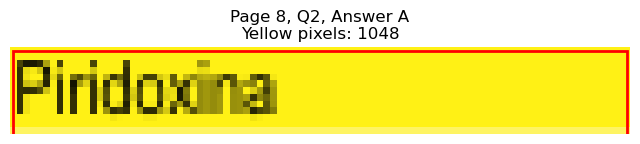

Page 8, Q2 - B: Detected box: x0=82.5, y0=198.6, x1=129.1, y1=211.3
Page 8, Q2, B: Yellow pixels: 98
Page 8, Q2, B: Total non-white pixels: 329
Page 8, Q2, B: Yellow percentage: 29.8%


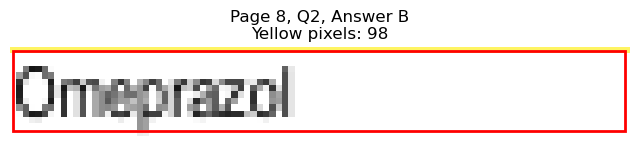

Page 8, Q2 - C: Detected box: x0=82.9, y0=211.3, x1=139.6, y1=224.0
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 296
Page 8, Q2, C: Yellow percentage: 0.0%


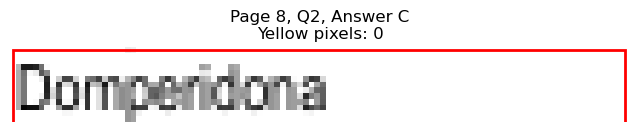

Page 8, Q2 - D: Detected box: x0=334.6, y0=186.0, x1=401.3, y1=198.7
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 361
Page 8, Q2, D: Yellow percentage: 0.0%


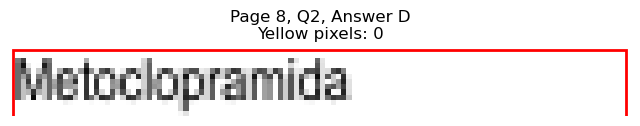

Page 8, Q2 - E: Detected box: x0=334.1, y0=198.6, x1=387.3, y1=211.3
Page 8, Q2, E: Yellow pixels: 0
Page 8, Q2, E: Total non-white pixels: 280
Page 8, Q2, E: Yellow percentage: 0.0%


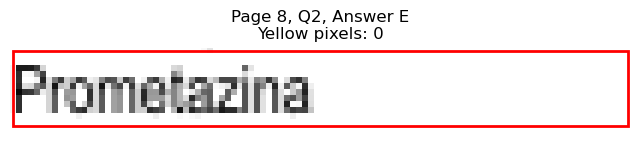


Page 8, Q2 - Selected Answer: A (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=82.5, y0=261.7, x1=229.0, y1=274.4
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 709
Page 8, Q3, A: Yellow percentage: 0.0%


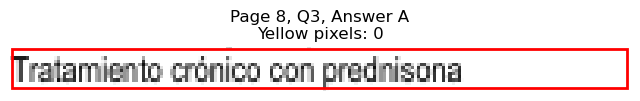

Page 8, Q3 - B: Detected box: x0=82.5, y0=274.5, x1=251.0, y1=287.1
Page 8, Q3, B: Yellow pixels: 1822
Page 8, Q3, B: Total non-white pixels: 2702
Page 8, Q3, B: Yellow percentage: 67.4%


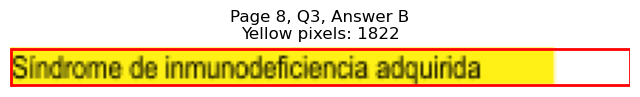

Page 8, Q3 - C: Detected box: x0=82.9, y0=287.1, x1=124.6, y1=299.7
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 295
Page 8, Q3, C: Yellow percentage: 0.0%


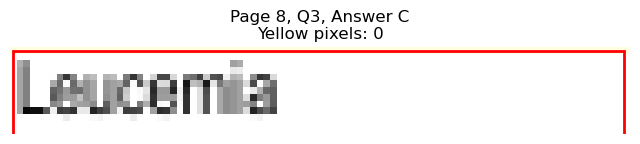

Page 8, Q3 - D: Detected box: x0=334.6, y0=261.7, x1=369.2, y1=274.4
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 170
Page 8, Q3, D: Yellow percentage: 0.0%


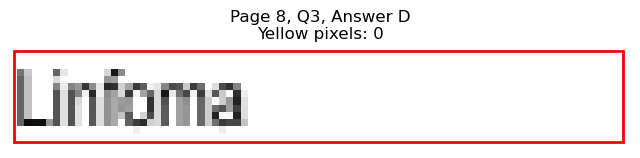

Page 8, Q3 - E: Detected box: x0=334.1, y0=274.5, x1=405.3, y1=287.1
Page 8, Q3, E: Yellow pixels: 0
Page 8, Q3, E: Total non-white pixels: 392
Page 8, Q3, E: Yellow percentage: 0.0%


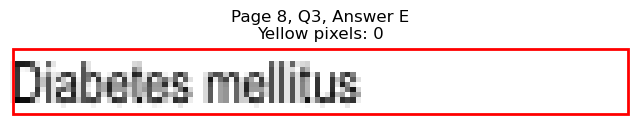


Page 8, Q3 - Selected Answer: B (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=82.5, y0=350.2, x1=134.1, y1=362.9
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 255
Page 8, Q4, A: Yellow percentage: 0.0%


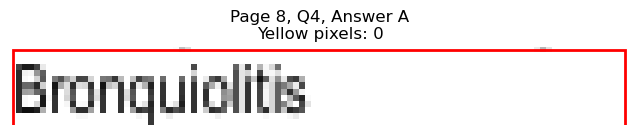

Page 8, Q4 - B: Detected box: x0=82.5, y0=362.8, x1=179.3, y1=375.5
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 527
Page 8, Q4, B: Yellow percentage: 0.0%


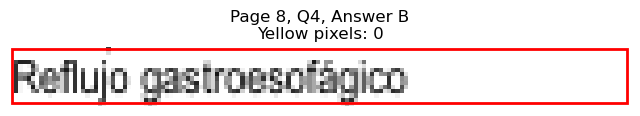

Page 8, Q4 - C: Detected box: x0=82.9, y0=375.4, x1=153.1, y1=388.1
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 389
Page 8, Q4, C: Yellow percentage: 0.0%


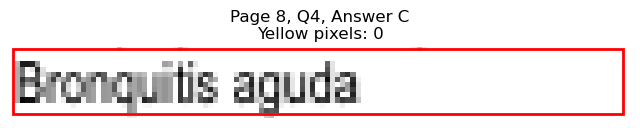

Page 8, Q4 - D: Detected box: x0=334.6, y0=350.2, x1=360.2, y1=362.9
Page 8, Q4, D: Yellow pixels: 906
Page 8, Q4, D: Total non-white pixels: 1001
Page 8, Q4, D: Yellow percentage: 90.5%


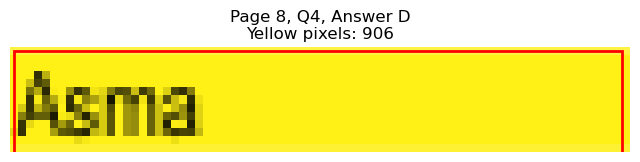

Page 8, Q4 - E: Detected box: x0=334.1, y0=362.8, x1=451.5, y1=375.5
Page 8, Q4, E: Yellow pixels: 168
Page 8, Q4, E: Total non-white pixels: 730
Page 8, Q4, E: Yellow percentage: 23.0%


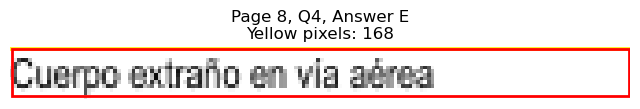


Page 8, Q4 - Selected Answer: D (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=82.5, y0=425.9, x1=185.8, y1=438.6
Page 8, Q5, A: Yellow pixels: 154
Page 8, Q5, A: Total non-white pixels: 695
Page 8, Q5, A: Yellow percentage: 22.2%


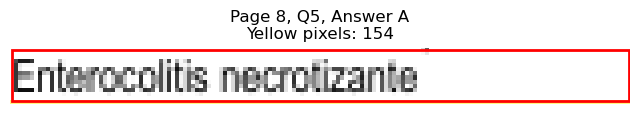

Page 8, Q5 - B: Detected box: x0=82.5, y0=438.5, x1=209.9, y1=451.2
Page 8, Q5, B: Yellow pixels: 1781
Page 8, Q5, B: Total non-white pixels: 2492
Page 8, Q5, B: Yellow percentage: 71.5%


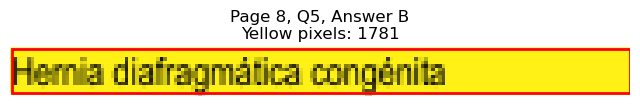

Page 8, Q5 - C: Detected box: x0=82.9, y0=451.1, x1=163.2, y1=463.8
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 550
Page 8, Q5, C: Yellow percentage: 0.0%


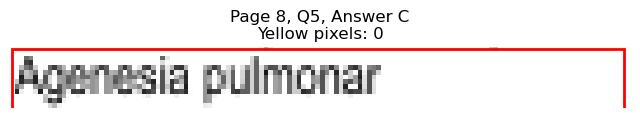

Page 8, Q5 - D: Detected box: x0=334.6, y0=425.9, x1=471.1, y1=438.6
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 691
Page 8, Q5, D: Yellow percentage: 0.0%


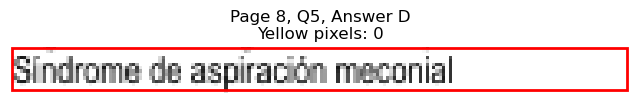

Page 8, Q5 - E: Detected box: x0=334.1, y0=438.5, x1=481.5, y1=451.2
Page 8, Q5, E: Yellow pixels: 0
Page 8, Q5, E: Total non-white pixels: 680
Page 8, Q5, E: Yellow percentage: 0.0%


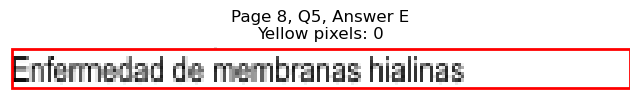


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=82.5, y0=526.9, x1=152.7, y1=539.5
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 357
Page 8, Q6, A: Yellow percentage: 0.0%


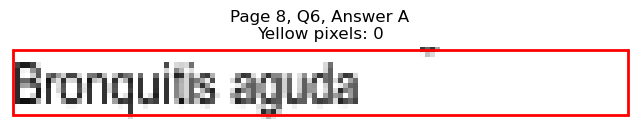

Page 8, Q6 - B: Detected box: x0=82.5, y0=539.5, x1=189.3, y1=552.1
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 550
Page 8, Q6, B: Yellow percentage: 0.0%


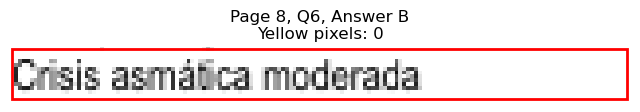

Page 8, Q6 - C: Detected box: x0=82.9, y0=552.2, x1=125.5, y1=564.8
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 204
Page 8, Q6, C: Yellow percentage: 0.0%


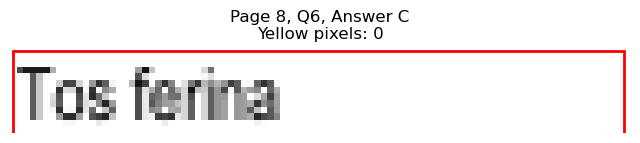

Page 8, Q6 - D: Detected box: x0=334.6, y0=526.9, x1=386.2, y1=539.5
Page 8, Q6, D: Yellow pixels: 1140
Page 8, Q6, D: Total non-white pixels: 1442
Page 8, Q6, D: Yellow percentage: 79.1%


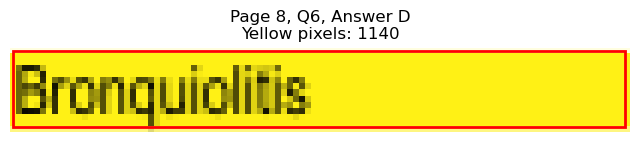

Page 8, Q6 - E: Detected box: x0=334.1, y0=539.5, x1=486.6, y1=552.1
Page 8, Q6, E: Yellow pixels: 192
Page 8, Q6, E: Total non-white pixels: 921
Page 8, Q6, E: Yellow percentage: 20.8%


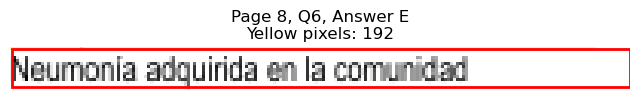


Page 8, Q6 - Selected Answer: D (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=82.5, y0=602.6, x1=109.1, y1=615.2
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 128
Page 8, Q7, A: Yellow percentage: 0.0%


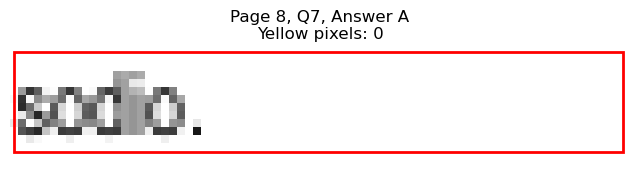

Page 8, Q7 - B: Detected box: x0=82.5, y0=615.2, x1=116.5, y1=627.8
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 168
Page 8, Q7, B: Yellow percentage: 0.0%


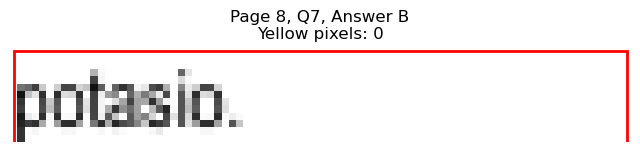

Page 8, Q7 - C: Detected box: x0=82.9, y0=627.9, x1=111.0, y1=640.6
Page 8, Q7, C: Yellow pixels: 946
Page 8, Q7, C: Total non-white pixels: 1120
Page 8, Q7, C: Yellow percentage: 84.5%


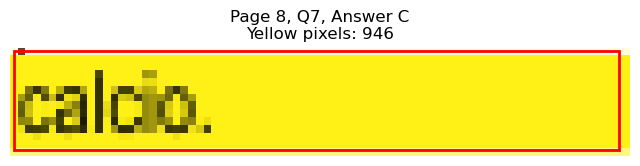

Page 8, Q7 - D: Detected box: x0=334.6, y0=602.6, x1=367.3, y1=615.2
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 156
Page 8, Q7, D: Yellow percentage: 0.0%


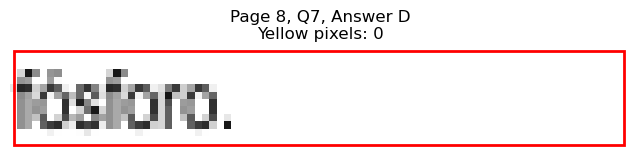

Page 8, Q7 - E: Detected box: x0=334.1, y0=615.2, x1=358.7, y1=627.8
Page 8, Q7, E: Yellow pixels: 0
Page 8, Q7, E: Total non-white pixels: 104
Page 8, Q7, E: Yellow percentage: 0.0%


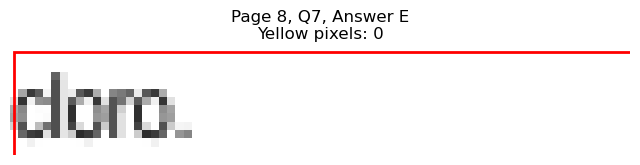


Page 8, Q7 - Selected Answer: C (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=82.5, y0=678.3, x1=120.6, y1=691.0
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 188
Page 8, Q8, A: Yellow percentage: 0.0%


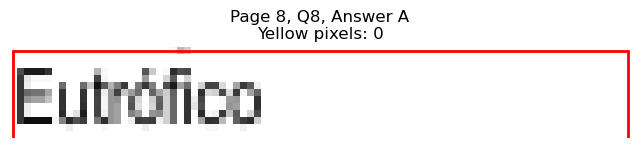

Page 8, Q8 - B: Detected box: x0=82.5, y0=691.1, x1=123.6, y1=703.7
Page 8, Q8, B: Yellow pixels: 1023
Page 8, Q8, B: Total non-white pixels: 1196
Page 8, Q8, B: Yellow percentage: 85.5%


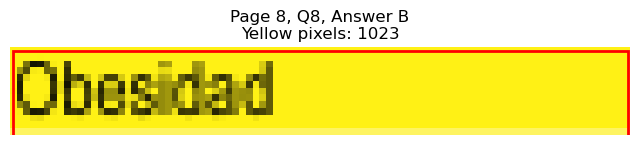

Page 8, Q8 - C: Detected box: x0=82.9, y0=703.7, x1=129.1, y1=716.3
Page 8, Q8, C: Yellow pixels: 98
Page 8, Q8, C: Total non-white pixels: 342
Page 8, Q8, C: Yellow percentage: 28.7%


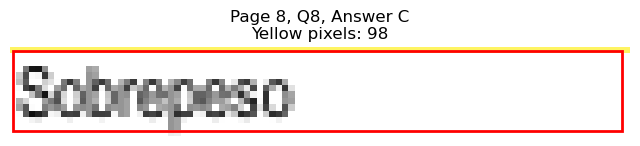

Page 8, Q8 - D: Detected box: x0=334.6, y0=678.3, x1=377.2, y1=691.0
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 216
Page 8, Q8, D: Yellow percentage: 0.0%


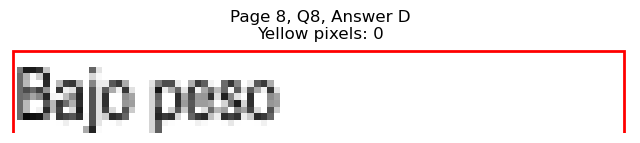

Page 8, Q8 - E: Detected box: x0=334.1, y0=691.1, x1=416.3, y1=703.7
Page 8, Q8, E: Yellow pixels: 0
Page 8, Q8, E: Total non-white pixels: 409
Page 8, Q8, E: Yellow percentage: 0.0%


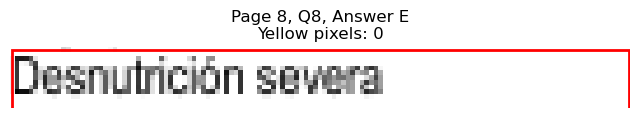


Page 8, Q8 - Selected Answer: B (based on yellow pixel count)





Page 9: Found 7 questions
Page 9, Q1 - A: Detected box: x0=70.8, y0=110.3, x1=79.3, y1=123.0
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 125
Page 9, Q1, A: Yellow percentage: 0.0%


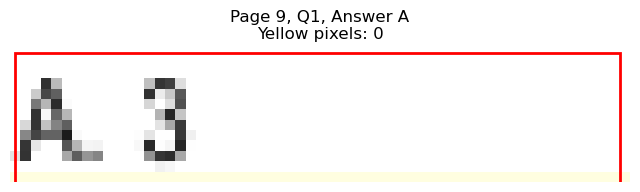

Page 9, Q1 - B: Detected box: x0=70.8, y0=122.9, x1=79.3, y1=135.6
Page 9, Q1, B: Yellow pixels: 729
Page 9, Q1, B: Total non-white pixels: 840
Page 9, Q1, B: Yellow percentage: 86.8%


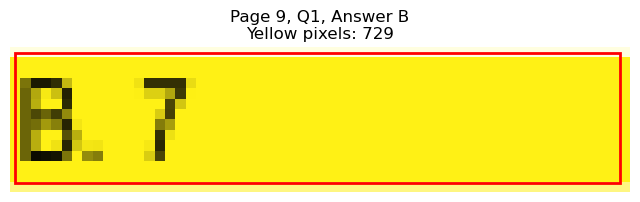

Page 9, Q1 - C: Detected box: x0=70.8, y0=135.5, x1=79.8, y1=148.2
Page 9, Q1, C: Yellow pixels: 60
Page 9, Q1, C: Total non-white pixels: 123
Page 9, Q1, C: Yellow percentage: 48.8%


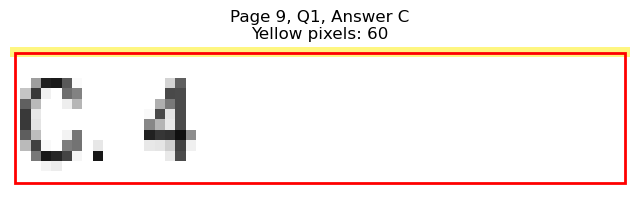

Page 9, Q1 - D: Detected box: x0=322.5, y0=110.3, x1=331.5, y1=123.0
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 66
Page 9, Q1, D: Yellow percentage: 0.0%


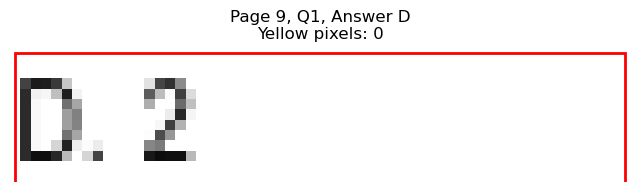

Page 9, Q1 - E: Detected box: x0=322.5, y0=122.9, x1=331.0, y1=135.6
Page 9, Q1, E: Yellow pixels: 0
Page 9, Q1, E: Total non-white pixels: 68
Page 9, Q1, E: Yellow percentage: 0.0%


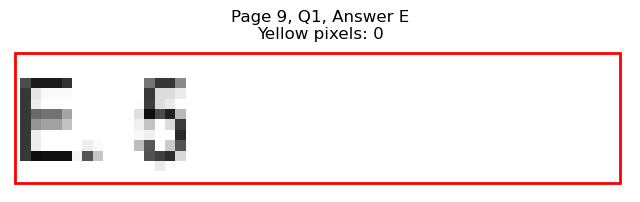


Page 9, Q1 - Selected Answer: B (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=82.5, y0=223.9, x1=152.7, y1=236.6
Page 9, Q2, A: Yellow pixels: 1303
Page 9, Q2, A: Total non-white pixels: 1694
Page 9, Q2, A: Yellow percentage: 76.9%


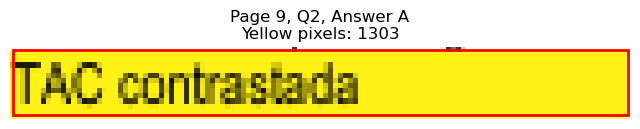

Page 9, Q2 - B: Detected box: x0=82.5, y0=236.5, x1=164.2, y1=249.2
Page 9, Q2, B: Yellow pixels: 133
Page 9, Q2, B: Total non-white pixels: 522
Page 9, Q2, B: Yellow percentage: 25.5%


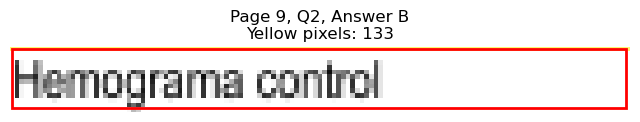

Page 9, Q2 - C: Detected box: x0=82.9, y0=249.1, x1=153.6, y1=261.8
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 359
Page 9, Q2, C: Yellow percentage: 0.0%


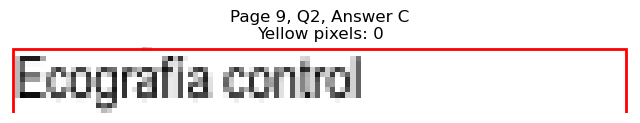

Page 9, Q2 - D: Detected box: x0=334.6, y0=223.9, x1=392.3, y1=236.6
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 289
Page 9, Q2, D: Yellow percentage: 0.0%


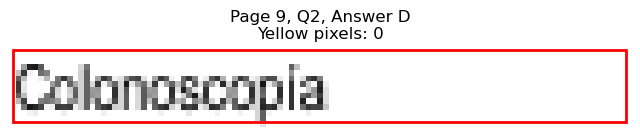

Page 9, Q2 - E: Detected box: x0=334.1, y0=236.5, x1=421.4, y1=249.2
Page 9, Q2, E: Yellow pixels: 0
Page 9, Q2, E: Total non-white pixels: 386
Page 9, Q2, E: Yellow percentage: 0.0%


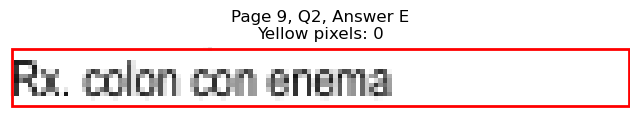


Page 9, Q2 - Selected Answer: A (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=109.4, y0=312.3, x1=175.6, y1=324.9
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 527
Page 9, Q3, A: Yellow percentage: 0.0%


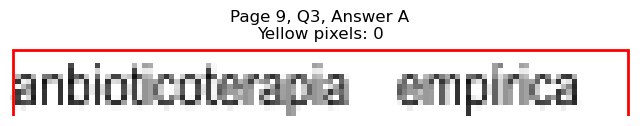

Page 9, Q3 - B: Detected box: x0=82.5, y0=337.5, x1=208.4, y1=350.1
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 644
Page 9, Q3, B: Yellow percentage: 0.0%


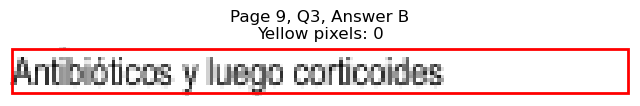

Page 9, Q3 - C: Detected box: x0=82.9, y0=350.2, x1=170.2, y1=362.9
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 434
Page 9, Q3, C: Yellow percentage: 0.0%


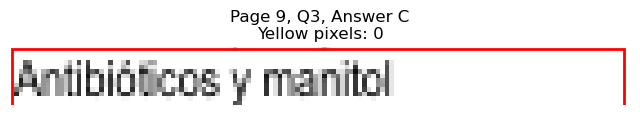

Page 9, Q3 - D: Detected box: x0=334.6, y0=312.3, x1=507.2, y1=324.9
Page 9, Q3, D: Yellow pixels: 1799
Page 9, Q3, D: Total non-white pixels: 2496
Page 9, Q3, D: Yellow percentage: 72.1%


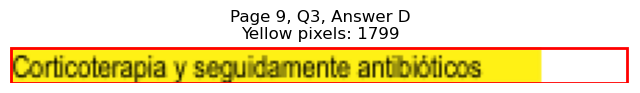

Page 9, Q3 - E: Detected box: x0=334.1, y0=324.9, x1=381.9, y1=337.5
Page 9, Q3, E: Yellow pixels: 91
Page 9, Q3, E: Total non-white pixels: 534
Page 9, Q3, E: Yellow percentage: 17.0%


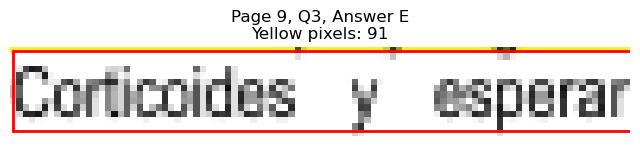


Page 9, Q3 - Selected Answer: D (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=82.5, y0=425.9, x1=123.6, y1=438.6
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 250
Page 9, Q4, A: Yellow percentage: 0.0%


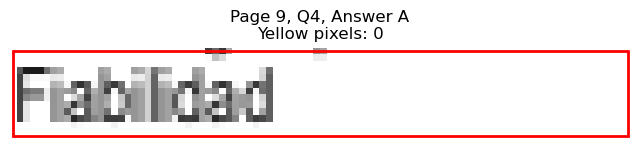

Page 9, Q4 - B: Detected box: x0=82.5, y0=438.5, x1=166.2, y1=451.2
Page 9, Q4, B: Yellow pixels: 135
Page 9, Q4, B: Total non-white pixels: 575
Page 9, Q4, B: Yellow percentage: 23.5%


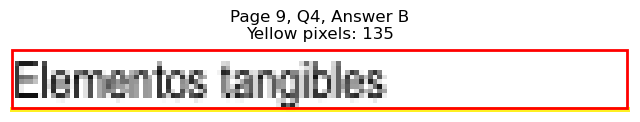

Page 9, Q4 - C: Detected box: x0=82.9, y0=451.1, x1=119.1, y1=463.8
Page 9, Q4, C: Yellow pixels: 1006
Page 9, Q4, C: Total non-white pixels: 1144
Page 9, Q4, C: Yellow percentage: 87.9%


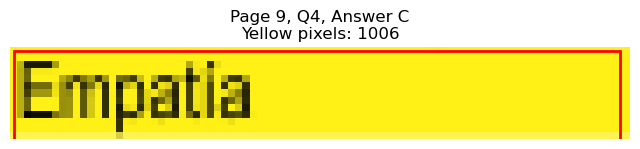

Page 9, Q4 - D: Detected box: x0=334.6, y0=425.9, x1=434.9, y1=438.6
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 516
Page 9, Q4, D: Yellow percentage: 0.0%


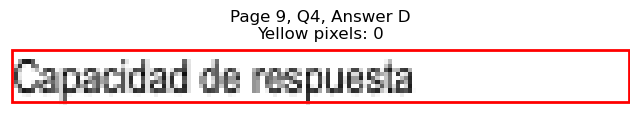

Page 9, Q4 - E: Detected box: x0=334.1, y0=438.5, x1=377.8, y1=451.2
Page 9, Q4, E: Yellow pixels: 0
Page 9, Q4, E: Total non-white pixels: 248
Page 9, Q4, E: Yellow percentage: 0.0%


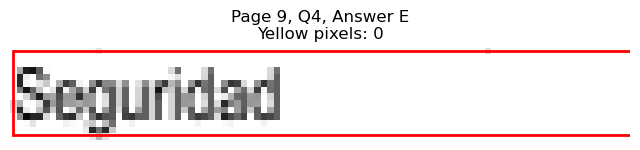


Page 9, Q4 - Selected Answer: C (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=82.5, y0=501.7, x1=275.2, y1=514.3
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 933
Page 9, Q5, A: Yellow percentage: 0.0%


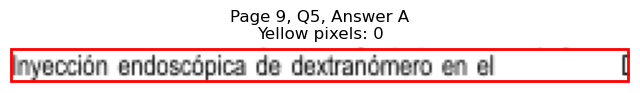

Page 9, Q5 - B: Detected box: x0=82.5, y0=526.9, x1=240.5, y1=539.5
Page 9, Q5, B: Yellow pixels: 192
Page 9, Q5, B: Total non-white pixels: 980
Page 9, Q5, B: Yellow percentage: 19.6%


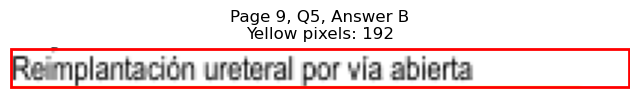

Page 9, Q5 - C: Detected box: x0=82.9, y0=539.5, x1=136.1, y1=552.1
Page 9, Q5, C: Yellow pixels: 1154
Page 9, Q5, C: Total non-white pixels: 1470
Page 9, Q5, C: Yellow percentage: 78.5%


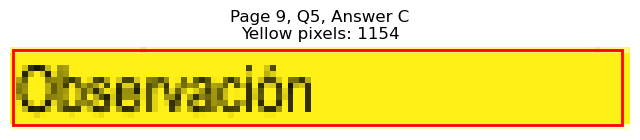

Page 9, Q5 - D: Detected box: x0=334.6, y0=501.7, x1=490.8, y1=514.3
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 806
Page 9, Q5, D: Yellow percentage: 0.0%


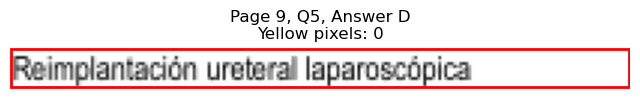

Page 9, Q5 - E: Detected box: x0=334.1, y0=514.3, x1=433.4, y1=526.9
Page 9, Q5, E: Yellow pixels: 0
Page 9, Q5, E: Total non-white pixels: 498
Page 9, Q5, E: Yellow percentage: 0.0%


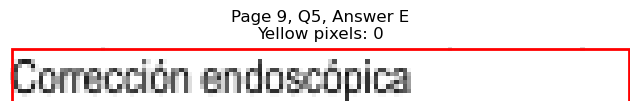


Page 9, Q5 - Selected Answer: C (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=82.5, y0=627.9, x1=145.1, y1=640.6
Page 9, Q6, A: Yellow pixels: 114
Page 9, Q6, A: Total non-white pixels: 449
Page 9, Q6, A: Yellow percentage: 25.4%


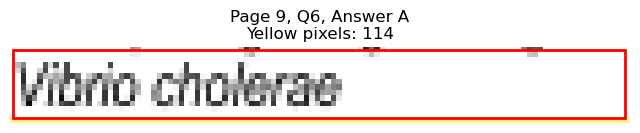

Page 9, Q6 - B: Detected box: x0=82.5, y0=640.5, x1=169.2, y1=653.2
Page 9, Q6, B: Yellow pixels: 1423
Page 9, Q6, B: Total non-white pixels: 1932
Page 9, Q6, B: Yellow percentage: 73.7%


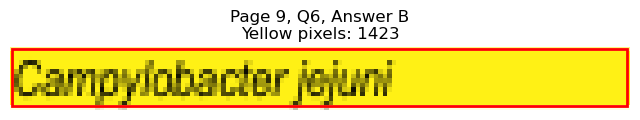

Page 9, Q6 - C: Detected box: x0=82.9, y0=653.1, x1=145.6, y1=665.8
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 338
Page 9, Q6, C: Yellow percentage: 0.0%


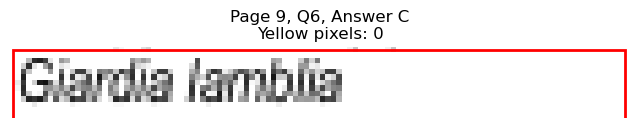

Page 9, Q6 - D: Detected box: x0=334.6, y0=627.9, x1=400.9, y1=640.6
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 353
Page 9, Q6, D: Yellow percentage: 0.0%


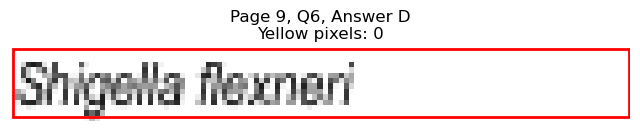

Page 9, Q6 - E: Detected box: x0=334.1, y0=640.5, x1=374.8, y1=653.2
Page 9, Q6, E: Yellow pixels: 0
Page 9, Q6, E: Total non-white pixels: 213
Page 9, Q6, E: Yellow percentage: 0.0%


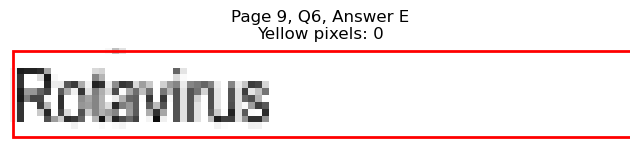


Page 9, Q6 - Selected Answer: B (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=82.5, y0=716.3, x1=201.9, y1=728.9
Page 9, Q7, A: Yellow pixels: 1746
Page 9, Q7, A: Total non-white pixels: 2210
Page 9, Q7, A: Yellow percentage: 79.0%


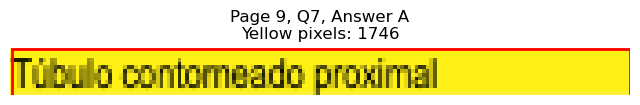

Page 9, Q7 - B: Detected box: x0=82.5, y0=728.9, x1=188.8, y1=741.5
Page 9, Q7, B: Yellow pixels: 156
Page 9, Q7, B: Total non-white pixels: 706
Page 9, Q7, B: Yellow percentage: 22.1%


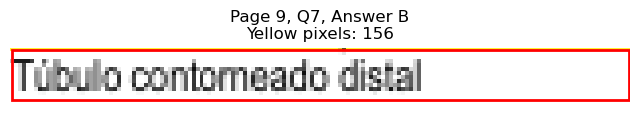

Page 9, Q7 - C: Detected box: x0=82.9, y0=741.4, x1=172.2, y1=754.1
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 424
Page 9, Q7, C: Yellow percentage: 0.0%


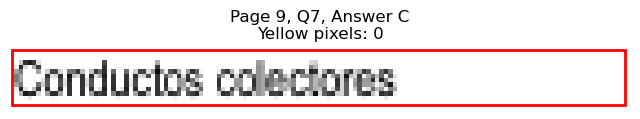

Page 9, Q7 - D: Detected box: x0=334.6, y0=716.3, x1=479.0, y1=728.9
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 699
Page 9, Q7, D: Yellow percentage: 0.0%


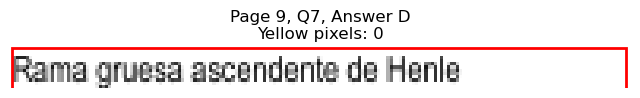

Page 9, Q7 - E: Detected box: x0=334.1, y0=728.9, x1=427.0, y1=741.5
Page 9, Q7, E: Yellow pixels: 0
Page 9, Q7, E: Total non-white pixels: 501
Page 9, Q7, E: Yellow percentage: 0.0%


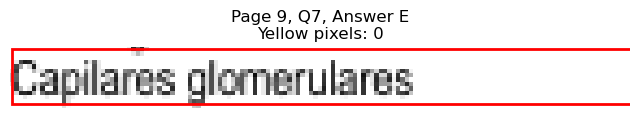


Page 9, Q7 - Selected Answer: A (based on yellow pixel count)





Page 10: Found 7 questions
Page 10, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=169.2, y1=110.4
Page 10, Q1, A: Yellow pixels: 1361
Page 10, Q1, A: Total non-white pixels: 1932
Page 10, Q1, A: Yellow percentage: 70.4%


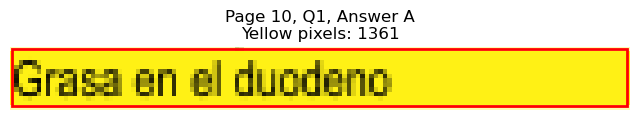

Page 10, Q1 - B: Detected box: x0=82.5, y0=110.3, x1=202.4, y1=123.0
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 745
Page 10, Q1, B: Yellow percentage: 0.0%


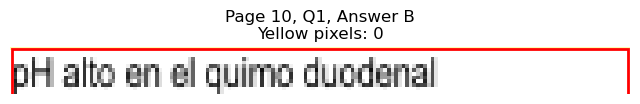

Page 10, Q1 - C: Detected box: x0=82.9, y0=122.9, x1=177.7, y1=135.6
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 459
Page 10, Q1, C: Yellow percentage: 0.0%


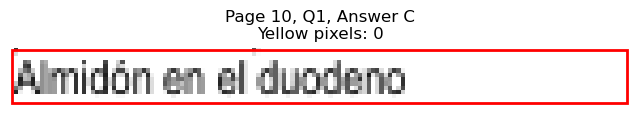

Page 10, Q1 - D: Detected box: x0=334.6, y0=97.7, x1=455.0, y1=110.4
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 587
Page 10, Q1, D: Yellow percentage: 0.0%


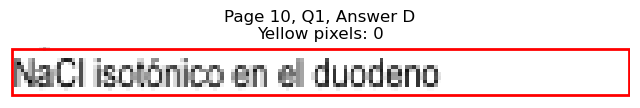

Page 10, Q1 - E: Detected box: x0=334.1, y0=110.3, x1=430.5, y1=123.0
Page 10, Q1, E: Yellow pixels: 0
Page 10, Q1, E: Total non-white pixels: 468
Page 10, Q1, E: Yellow percentage: 0.0%


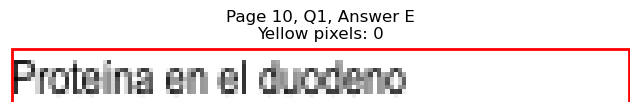


Page 10, Q1 - Selected Answer: A (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=82.5, y0=160.8, x1=242.9, y1=173.5
Page 10, Q2, A: Yellow pixels: 192
Page 10, Q2, A: Total non-white pixels: 1019
Page 10, Q2, A: Yellow percentage: 18.8%


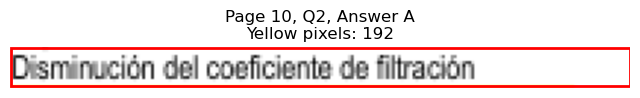

Page 10, Q2 - B: Detected box: x0=82.5, y0=173.4, x1=267.5, y1=186.1
Page 10, Q2, B: Yellow pixels: 1736
Page 10, Q2, B: Total non-white pixels: 2701
Page 10, Q2, B: Yellow percentage: 64.3%


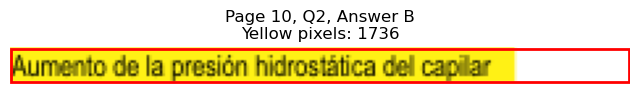

Page 10, Q2 - C: Detected box: x0=82.9, y0=186.0, x1=275.2, y1=198.7
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 1138
Page 10, Q2, C: Yellow percentage: 0.0%


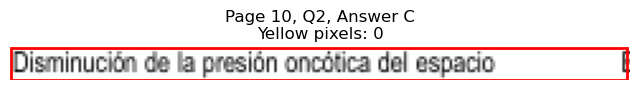

Page 10, Q2 - D: Detected box: x0=334.6, y0=160.8, x1=526.9, y1=173.5
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 939
Page 10, Q2, D: Yellow percentage: 0.0%


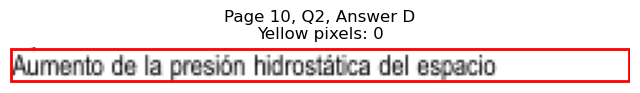

Page 10, Q2 - E: Detected box: x0=334.1, y0=186.0, x1=506.6, y1=198.7
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 871
Page 10, Q2, E: Yellow percentage: 0.0%


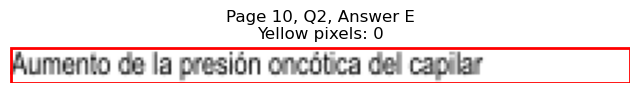


Page 10, Q2 - Selected Answer: B (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=82.5, y0=299.7, x1=157.2, y1=312.3
Page 10, Q3, A: Yellow pixels: 1213
Page 10, Q3, A: Total non-white pixels: 1764
Page 10, Q3, A: Yellow percentage: 68.8%


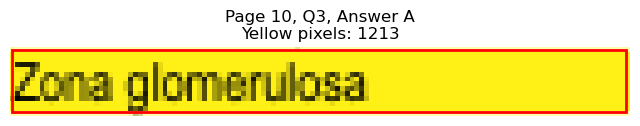

Page 10, Q3 - B: Detected box: x0=82.5, y0=312.3, x1=147.1, y1=324.9
Page 10, Q3, B: Yellow pixels: 1
Page 10, Q3, B: Total non-white pixels: 461
Page 10, Q3, B: Yellow percentage: 0.2%


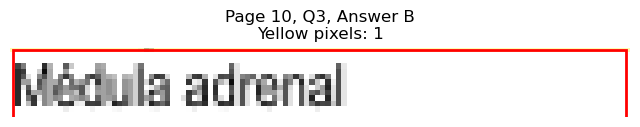

Page 10, Q3 - C: Detected box: x0=82.9, y0=324.9, x1=140.7, y1=337.5
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 275
Page 10, Q3, C: Yellow percentage: 0.0%


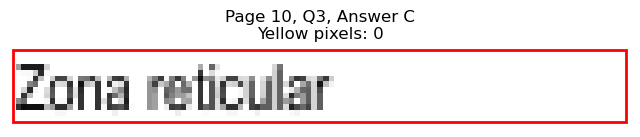

Page 10, Q3 - D: Detected box: x0=334.6, y0=299.7, x1=402.8, y1=312.3
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 362
Page 10, Q3, D: Yellow percentage: 0.0%


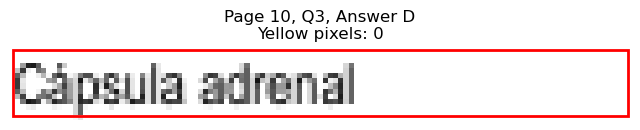

Page 10, Q3 - E: Detected box: x0=334.1, y0=312.3, x1=397.9, y1=324.9
Page 10, Q3, E: Yellow pixels: 0
Page 10, Q3, E: Total non-white pixels: 307
Page 10, Q3, E: Yellow percentage: 0.0%


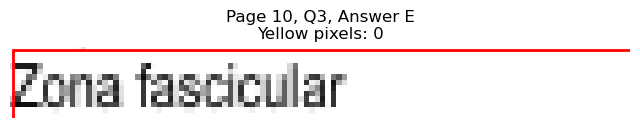


Page 10, Q3 - Selected Answer: A (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=82.5, y0=388.0, x1=204.4, y1=400.7
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 632
Page 10, Q4, A: Yellow percentage: 0.0%


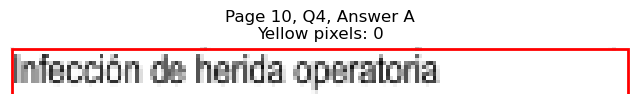

Page 10, Q4 - B: Detected box: x0=82.5, y0=400.6, x1=220.5, y1=413.3
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 714
Page 10, Q4, B: Yellow percentage: 0.0%


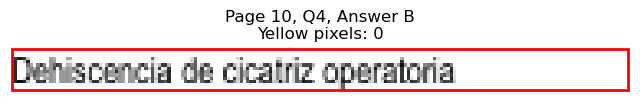

Page 10, Q4 - C: Detected box: x0=82.9, y0=413.3, x1=216.9, y1=426.0
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 673
Page 10, Q4, C: Yellow percentage: 0.0%


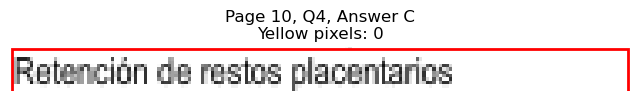

Page 10, Q4 - D: Detected box: x0=334.6, y0=388.0, x1=383.8, y1=400.7
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 361
Page 10, Q4, D: Yellow percentage: 0.0%


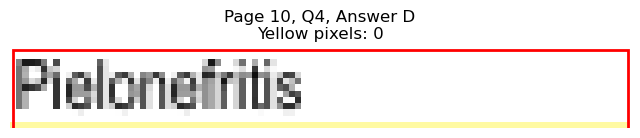

Page 10, Q4 - E: Detected box: x0=334.1, y0=400.6, x1=427.4, y1=413.3
Page 10, Q4, E: Yellow pixels: 1327
Page 10, Q4, E: Total non-white pixels: 2016
Page 10, Q4, E: Yellow percentage: 65.8%


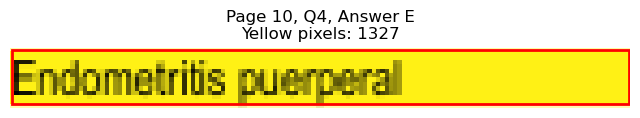


Page 10, Q4 - Selected Answer: E (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=82.5, y0=476.3, x1=156.6, y1=489.0
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 376
Page 10, Q5, A: Yellow percentage: 0.0%


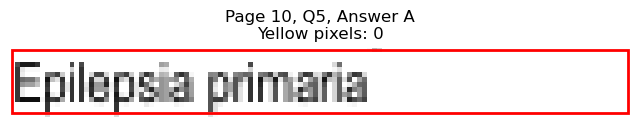

Page 10, Q5 - B: Detected box: x0=82.5, y0=489.1, x1=163.2, y1=501.7
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 550
Page 10, Q5, B: Yellow percentage: 0.0%


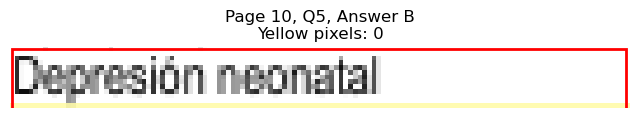

Page 10, Q5 - C: Detected box: x0=82.9, y0=501.7, x1=149.2, y1=514.3
Page 10, Q5, C: Yellow pixels: 1151
Page 10, Q5, C: Total non-white pixels: 1652
Page 10, Q5, C: Yellow percentage: 69.7%


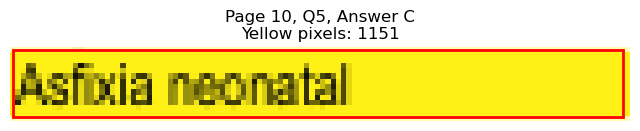

Page 10, Q5 - D: Detected box: x0=334.6, y0=476.3, x1=414.9, y1=489.0
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 440
Page 10, Q5, D: Yellow percentage: 0.0%


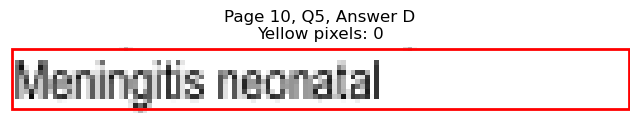

Page 10, Q5 - E: Detected box: x0=334.1, y0=489.1, x1=405.9, y1=501.7
Page 10, Q5, E: Yellow pixels: 0
Page 10, Q5, E: Total non-white pixels: 371
Page 10, Q5, E: Yellow percentage: 0.0%


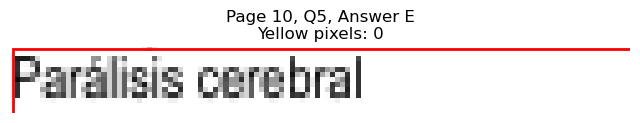


Page 10, Q5 - Selected Answer: C (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=82.5, y0=564.8, x1=155.7, y1=577.4
Page 10, Q6, A: Yellow pixels: 124
Page 10, Q6, A: Total non-white pixels: 484
Page 10, Q6, A: Yellow percentage: 25.6%


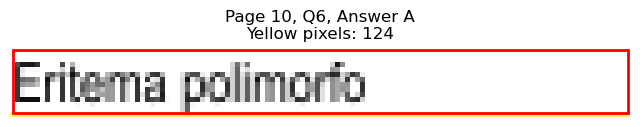

Page 10, Q6 - B: Detected box: x0=82.5, y0=577.4, x1=149.7, y1=590.0
Page 10, Q6, B: Yellow pixels: 1264
Page 10, Q6, B: Total non-white pixels: 1534
Page 10, Q6, B: Yellow percentage: 82.4%


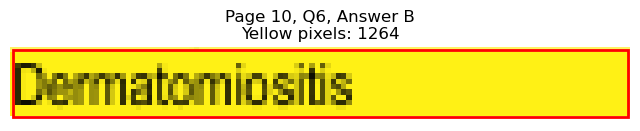

Page 10, Q6 - C: Detected box: x0=82.9, y0=590.0, x1=143.1, y1=602.6
Page 10, Q6, C: Yellow pixels: 112
Page 10, Q6, C: Total non-white pixels: 428
Page 10, Q6, C: Yellow percentage: 26.2%


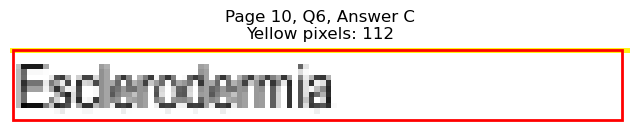

Page 10, Q6 - D: Detected box: x0=334.6, y0=564.8, x1=451.5, y1=577.4
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 601
Page 10, Q6, D: Yellow percentage: 0.0%


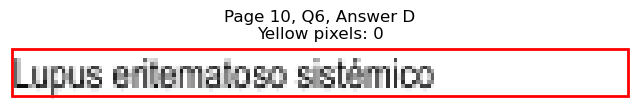

Page 10, Q6 - E: Detected box: x0=334.1, y0=577.4, x1=409.9, y1=590.0
Page 10, Q6, E: Yellow pixels: 0
Page 10, Q6, E: Total non-white pixels: 405
Page 10, Q6, E: Yellow percentage: 0.0%


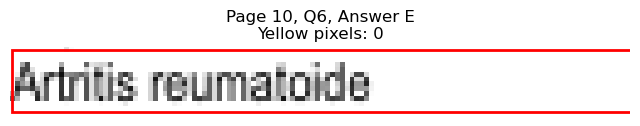


Page 10, Q6 - Selected Answer: B (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=82.5, y0=653.1, x1=138.1, y1=665.8
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 258
Page 10, Q7, A: Yellow percentage: 0.0%


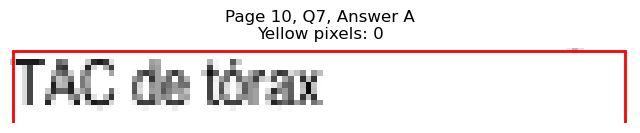

Page 10, Q7 - B: Detected box: x0=82.5, y0=665.7, x1=166.7, y1=678.4
Page 10, Q7, B: Yellow pixels: 135
Page 10, Q7, B: Total non-white pixels: 571
Page 10, Q7, B: Yellow percentage: 23.6%


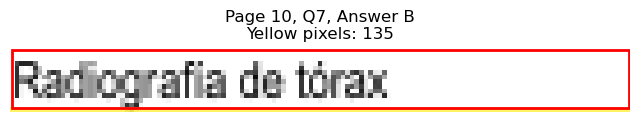

Page 10, Q7 - C: Detected box: x0=82.9, y0=678.3, x1=231.9, y1=691.0
Page 10, Q7, C: Yellow pixels: 1904
Page 10, Q7, C: Total non-white pixels: 2509
Page 10, Q7, C: Yellow percentage: 75.9%


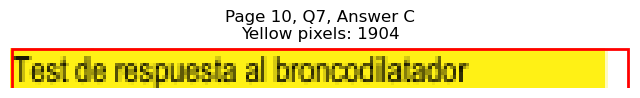

Page 10, Q7 - D: Detected box: x0=334.6, y0=653.1, x1=482.6, y1=665.8
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 756
Page 10, Q7, D: Yellow percentage: 0.0%


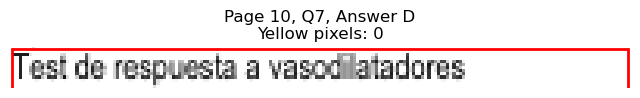

Page 10, Q7 - E: Detected box: x0=334.1, y0=665.7, x1=483.6, y1=678.4
Page 10, Q7, E: Yellow pixels: 0
Page 10, Q7, E: Total non-white pixels: 746
Page 10, Q7, E: Yellow percentage: 0.0%


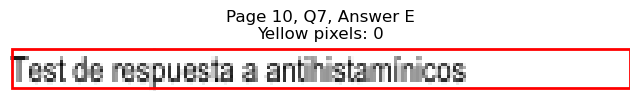


Page 10, Q7 - Selected Answer: C (based on yellow pixel count)





Page 11: Found 7 questions
Page 11, Q1 - A: Detected box: x0=82.5, y0=148.2, x1=229.0, y1=160.9
Page 11, Q1, A: Yellow pixels: 1919
Page 11, Q1, A: Total non-white pixels: 2509
Page 11, Q1, A: Yellow percentage: 76.5%


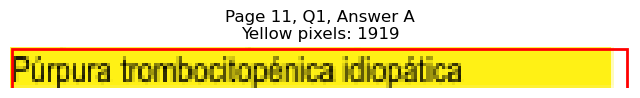

Page 11, Q1 - B: Detected box: x0=82.5, y0=160.8, x1=131.1, y1=173.5
Page 11, Q1, B: Yellow pixels: 98
Page 11, Q1, B: Total non-white pixels: 359
Page 11, Q1, B: Yellow percentage: 27.3%


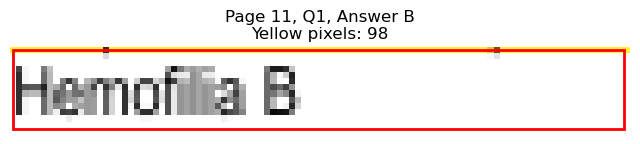

Page 11, Q1 - C: Detected box: x0=82.9, y0=173.4, x1=201.3, y1=186.1
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 603
Page 11, Q1, C: Yellow percentage: 0.0%


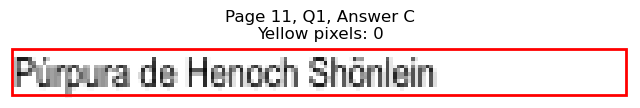

Page 11, Q1 - D: Detected box: x0=334.6, y0=148.2, x1=401.8, y1=160.9
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 332
Page 11, Q1, D: Yellow percentage: 0.0%


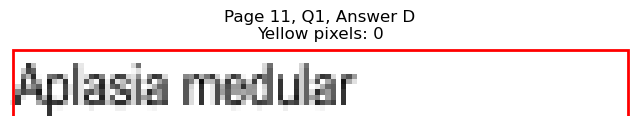

Page 11, Q1 - E: Detected box: x0=334.1, y0=160.8, x1=425.5, y1=173.5
Page 11, Q1, E: Yellow pixels: 0
Page 11, Q1, E: Total non-white pixels: 487
Page 11, Q1, E: Yellow percentage: 0.0%


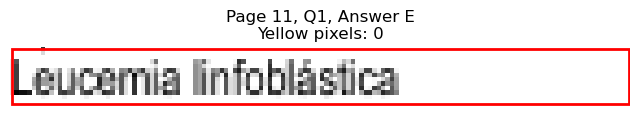


Page 11, Q1 - Selected Answer: A (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=82.5, y0=249.1, x1=211.5, y1=261.8
Page 11, Q2, A: Yellow pixels: 0
Page 11, Q2, A: Total non-white pixels: 655
Page 11, Q2, A: Yellow percentage: 0.0%


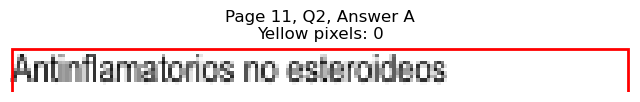

Page 11, Q2 - B: Detected box: x0=82.5, y0=261.7, x1=182.3, y1=274.4
Page 11, Q2, B: Yellow pixels: 0
Page 11, Q2, B: Total non-white pixels: 516
Page 11, Q2, B: Yellow percentage: 0.0%


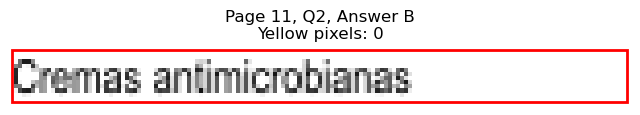

Page 11, Q2 - C: Detected box: x0=82.9, y0=274.5, x1=213.9, y1=287.1
Page 11, Q2, C: Yellow pixels: 1865
Page 11, Q2, C: Total non-white pixels: 2548
Page 11, Q2, C: Yellow percentage: 73.2%


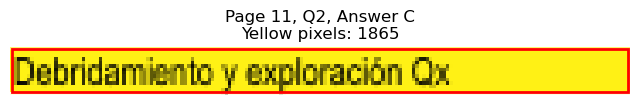

Page 11, Q2 - D: Detected box: x0=334.6, y0=249.1, x1=464.0, y1=261.8
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 665
Page 11, Q2, D: Yellow percentage: 0.0%


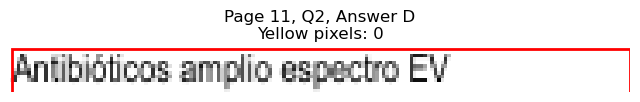

Page 11, Q2 - E: Detected box: x0=334.1, y0=261.7, x1=415.9, y1=274.4
Page 11, Q2, E: Yellow pixels: 0
Page 11, Q2, E: Total non-white pixels: 431
Page 11, Q2, E: Yellow percentage: 0.0%


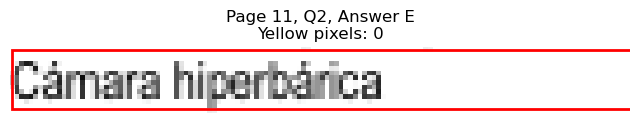


Page 11, Q2 - Selected Answer: C (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=82.5, y0=350.2, x1=138.6, y1=362.9
Page 11, Q3, A: Yellow pixels: 0
Page 11, Q3, A: Total non-white pixels: 279
Page 11, Q3, A: Yellow percentage: 0.0%


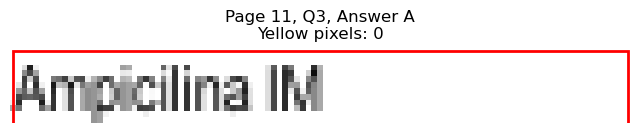

Page 11, Q3 - B: Detected box: x0=82.5, y0=362.8, x1=140.7, y1=375.5
Page 11, Q3, B: Yellow pixels: 109
Page 11, Q3, B: Total non-white pixels: 383
Page 11, Q3, B: Yellow percentage: 28.5%


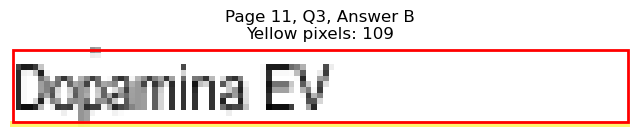

Page 11, Q3 - C: Detected box: x0=82.9, y0=375.4, x1=176.8, y1=388.1
Page 11, Q3, C: Yellow pixels: 1501
Page 11, Q3, C: Total non-white pixels: 2030
Page 11, Q3, C: Yellow percentage: 73.9%


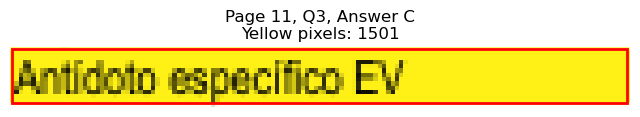

Page 11, Q3 - D: Detected box: x0=334.6, y0=350.2, x1=401.3, y1=362.9
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 338
Page 11, Q3, D: Yellow percentage: 0.0%


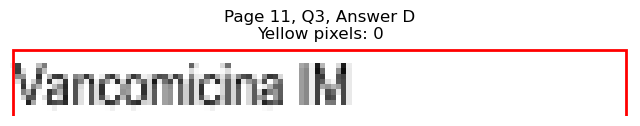

Page 11, Q3 - E: Detected box: x0=334.1, y0=362.8, x1=388.9, y1=375.5
Page 11, Q3, E: Yellow pixels: 0
Page 11, Q3, E: Total non-white pixels: 276
Page 11, Q3, E: Yellow percentage: 0.0%


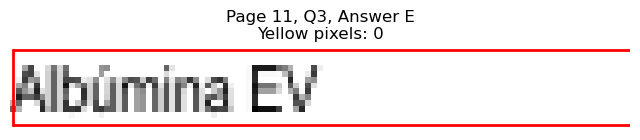


Page 11, Q3 - Selected Answer: C (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=82.5, y0=425.9, x1=123.6, y1=438.6
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 225
Page 11, Q4, A: Yellow percentage: 0.0%


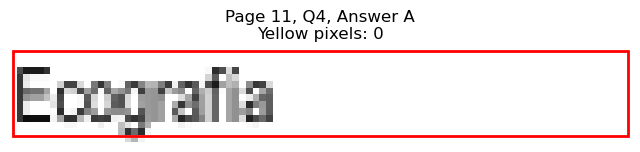

Page 11, Q4 - B: Detected box: x0=82.5, y0=438.5, x1=147.1, y1=451.2
Page 11, Q4, B: Yellow pixels: 0
Page 11, Q4, B: Total non-white pixels: 332
Page 11, Q4, B: Yellow percentage: 0.0%


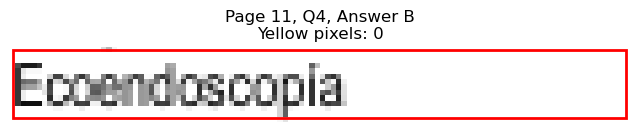

Page 11, Q4 - C: Detected box: x0=82.9, y0=451.1, x1=150.6, y1=463.8
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 316
Page 11, Q4, C: Yellow percentage: 0.0%


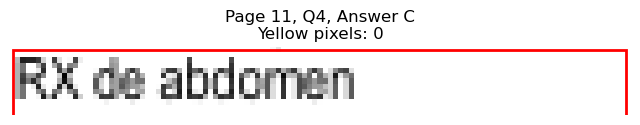

Page 11, Q4 - D: Detected box: x0=334.6, y0=425.9, x1=416.8, y1=438.6
Page 11, Q4, D: Yellow pixels: 1396
Page 11, Q4, D: Total non-white pixels: 1862
Page 11, Q4, D: Yellow percentage: 75.0%


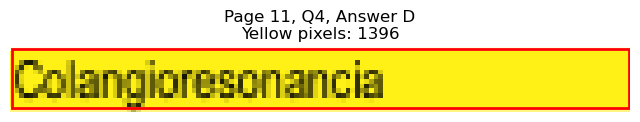

Page 11, Q4 - E: Detected box: x0=334.1, y0=438.5, x1=361.7, y1=451.2
Page 11, Q4, E: Yellow pixels: 77
Page 11, Q4, E: Total non-white pixels: 215
Page 11, Q4, E: Yellow percentage: 35.8%


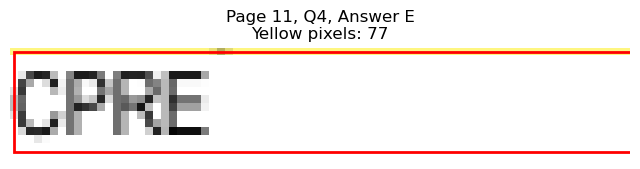


Page 11, Q4 - Selected Answer: D (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=82.5, y0=514.3, x1=275.2, y1=526.9
Page 11, Q5, A: Yellow pixels: 0
Page 11, Q5, A: Total non-white pixels: 929
Page 11, Q5, A: Yellow percentage: 0.0%


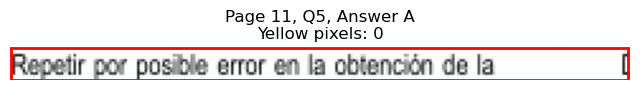

Page 11, Q5 - B: Detected box: x0=82.5, y0=539.5, x1=275.2, y1=552.1
Page 11, Q5, B: Yellow pixels: 1786
Page 11, Q5, B: Total non-white pixels: 2723
Page 11, Q5, B: Yellow percentage: 65.6%


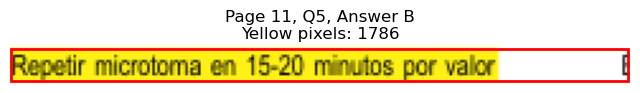

Page 11, Q5 - C: Detected box: x0=160.9, y0=564.8, x1=202.9, y1=577.4
Page 11, Q5, C: Yellow pixels: 93
Page 11, Q5, C: Total non-white pixels: 491
Page 11, Q5, C: Yellow percentage: 18.9%


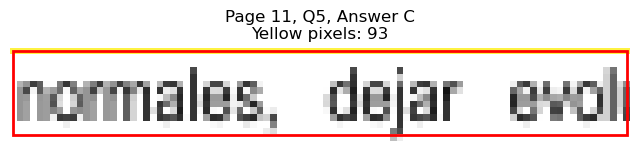

Page 11, Q5 - D: Detected box: x0=334.6, y0=514.3, x1=526.9, y1=526.9
Page 11, Q5, D: Yellow pixels: 0
Page 11, Q5, D: Total non-white pixels: 847
Page 11, Q5, D: Yellow percentage: 0.0%


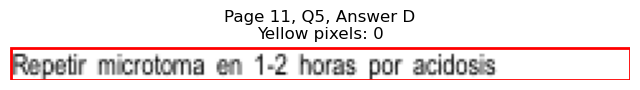

Page 11, Q5 - E: Detected box: x0=334.1, y0=539.5, x1=479.6, y1=552.1
Page 11, Q5, E: Yellow pixels: 0
Page 11, Q5, E: Total non-white pixels: 741
Page 11, Q5, E: Yellow percentage: 0.0%


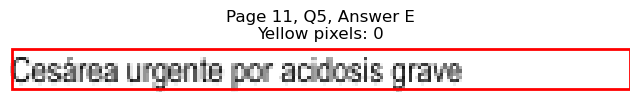


Page 11, Q5 - Selected Answer: B (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=82.5, y0=640.5, x1=178.8, y1=653.2
Page 11, Q6, A: Yellow pixels: 1534
Page 11, Q6, A: Total non-white pixels: 2058
Page 11, Q6, A: Yellow percentage: 74.5%


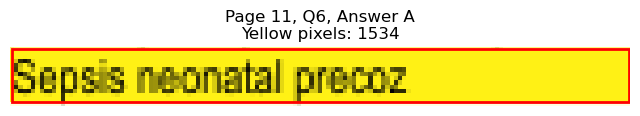

Page 11, Q6 - B: Detected box: x0=82.5, y0=653.1, x1=170.8, y1=665.8
Page 11, Q6, B: Yellow pixels: 0
Page 11, Q6, B: Total non-white pixels: 457
Page 11, Q6, B: Yellow percentage: 0.0%


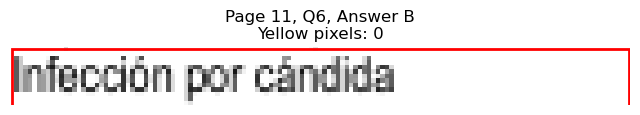

Page 11, Q6 - C: Detected box: x0=82.9, y0=665.7, x1=148.7, y1=678.4
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 354
Page 11, Q6, C: Yellow percentage: 0.0%


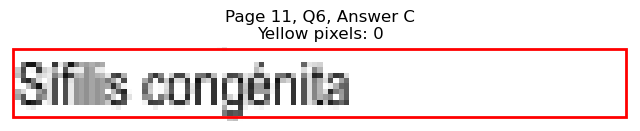

Page 11, Q6 - D: Detected box: x0=334.6, y0=640.5, x1=426.9, y1=653.2
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 482
Page 11, Q6, D: Yellow percentage: 0.0%


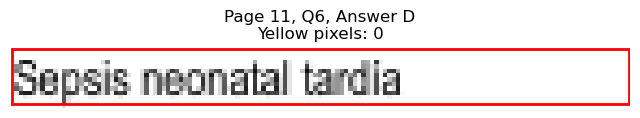

Page 11, Q6 - E: Detected box: x0=334.1, y0=653.1, x1=411.9, y1=665.8
Page 11, Q6, E: Yellow pixels: 0
Page 11, Q6, E: Total non-white pixels: 394
Page 11, Q6, E: Yellow percentage: 0.0%


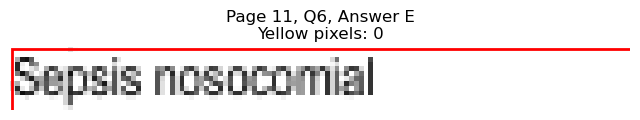


Page 11, Q6 - Selected Answer: A (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=70.8, y0=703.7, x1=79.3, y1=716.3
Page 11, Q7, A: Yellow pixels: 673
Page 11, Q7, A: Total non-white pixels: 840
Page 11, Q7, A: Yellow percentage: 80.1%


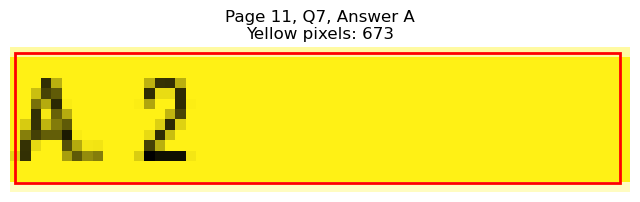

Page 11, Q7 - B: Detected box: x0=70.8, y0=716.3, x1=79.3, y1=728.9
Page 11, Q7, B: Yellow pixels: 0
Page 11, Q7, B: Total non-white pixels: 131
Page 11, Q7, B: Yellow percentage: 0.0%


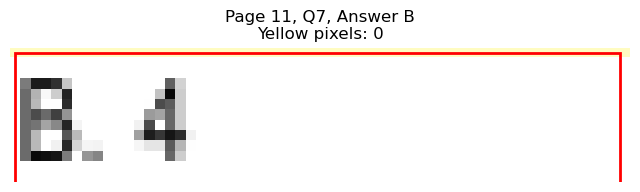

Page 11, Q7 - C: Detected box: x0=70.8, y0=728.9, x1=79.8, y1=741.5
Page 11, Q7, C: Yellow pixels: 0
Page 11, Q7, C: Total non-white pixels: 66
Page 11, Q7, C: Yellow percentage: 0.0%


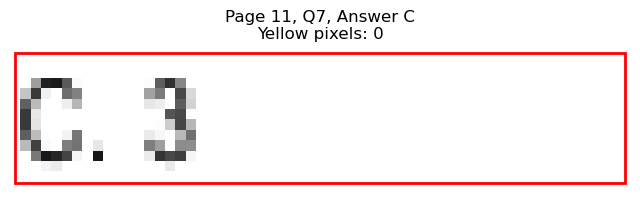

Page 11, Q7 - D: Detected box: x0=322.5, y0=703.7, x1=331.5, y1=716.3
Page 11, Q7, D: Yellow pixels: 0
Page 11, Q7, D: Total non-white pixels: 59
Page 11, Q7, D: Yellow percentage: 0.0%


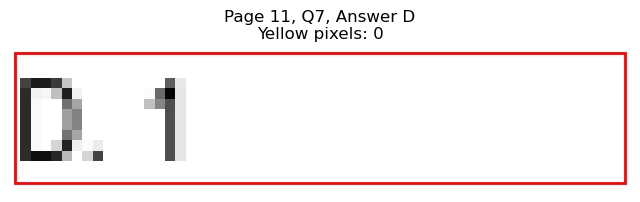

Page 11, Q7 - E: Detected box: x0=322.5, y0=716.3, x1=331.0, y1=728.9
Page 11, Q7, E: Yellow pixels: 0
Page 11, Q7, E: Total non-white pixels: 68
Page 11, Q7, E: Yellow percentage: 0.0%


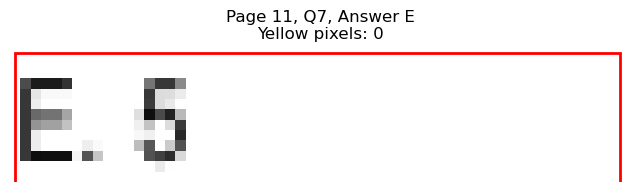


Page 11, Q7 - Selected Answer: A (based on yellow pixel count)





Page 12: Found 8 questions
Page 12, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=156.1, y1=135.6
Page 12, Q1, A: Yellow pixels: 0
Page 12, Q1, A: Total non-white pixels: 405
Page 12, Q1, A: Yellow percentage: 0.0%


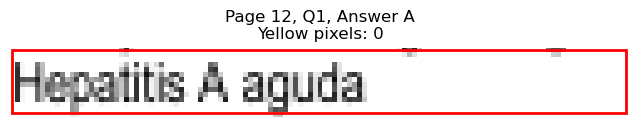

Page 12, Q1 - B: Detected box: x0=82.5, y0=135.5, x1=190.8, y1=148.2
Page 12, Q1, B: Yellow pixels: 0
Page 12, Q1, B: Total non-white pixels: 520
Page 12, Q1, B: Yellow percentage: 0.0%


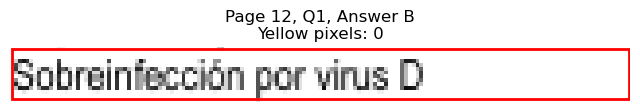

Page 12, Q1 - C: Detected box: x0=82.9, y0=148.2, x1=174.3, y1=160.9
Page 12, Q1, C: Yellow pixels: 0
Page 12, Q1, C: Total non-white pixels: 474
Page 12, Q1, C: Yellow percentage: 0.0%


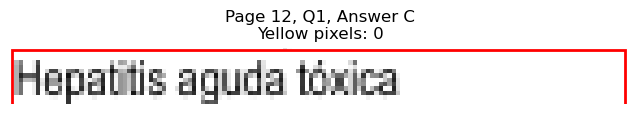

Page 12, Q1 - D: Detected box: x0=334.6, y0=122.9, x1=408.3, y1=135.6
Page 12, Q1, D: Yellow pixels: 1311
Page 12, Q1, D: Total non-white pixels: 1750
Page 12, Q1, D: Yellow percentage: 74.9%


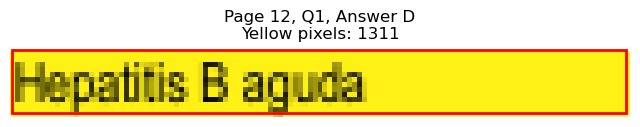

Page 12, Q1 - E: Detected box: x0=334.1, y0=135.5, x1=412.0, y1=148.2
Page 12, Q1, E: Yellow pixels: 127
Page 12, Q1, E: Total non-white pixels: 531
Page 12, Q1, E: Yellow percentage: 23.9%


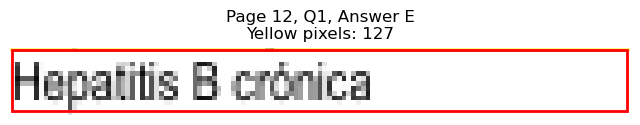


Page 12, Q1 - Selected Answer: D (based on yellow pixel count)




Page 12, Q2 - A: Detected box: x0=82.5, y0=198.6, x1=130.6, y1=211.3
Page 12, Q2, A: Yellow pixels: 985
Page 12, Q2, A: Total non-white pixels: 1386
Page 12, Q2, A: Yellow percentage: 71.1%


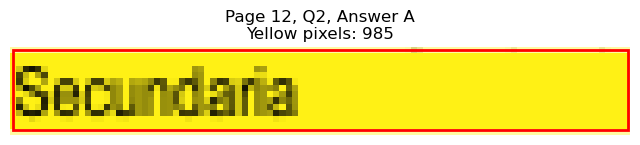

Page 12, Q2 - B: Detected box: x0=82.5, y0=211.3, x1=132.1, y1=224.0
Page 12, Q2, B: Yellow pixels: 0
Page 12, Q2, B: Total non-white pixels: 347
Page 12, Q2, B: Yellow percentage: 0.0%


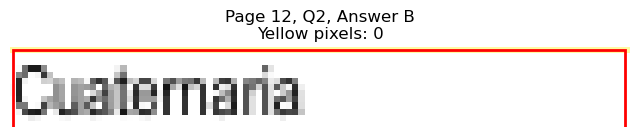

Page 12, Q2 - C: Detected box: x0=82.9, y0=223.9, x1=119.1, y1=236.6
Page 12, Q2, C: Yellow pixels: 0
Page 12, Q2, C: Total non-white pixels: 167
Page 12, Q2, C: Yellow percentage: 0.0%


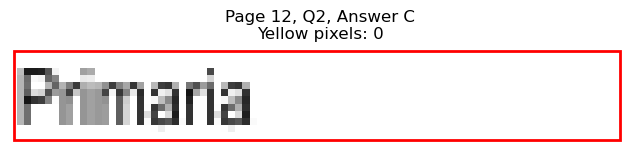

Page 12, Q2 - D: Detected box: x0=334.6, y0=198.6, x1=377.7, y1=211.3
Page 12, Q2, D: Yellow pixels: 0
Page 12, Q2, D: Total non-white pixels: 221
Page 12, Q2, D: Yellow percentage: 0.0%


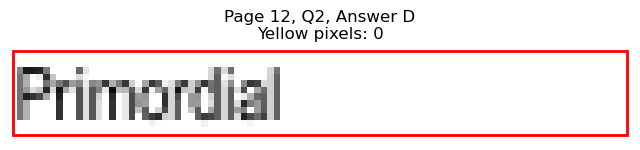

Page 12, Q2 - E: Detected box: x0=334.1, y0=211.3, x1=371.7, y1=224.0
Page 12, Q2, E: Yellow pixels: 0
Page 12, Q2, E: Total non-white pixels: 186
Page 12, Q2, E: Yellow percentage: 0.0%


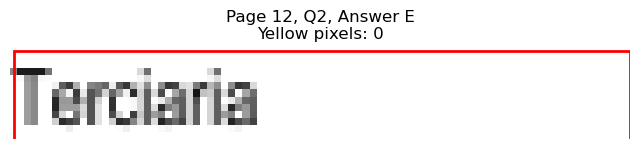


Page 12, Q2 - Selected Answer: A (based on yellow pixel count)




Page 12, Q3 - A: Detected box: x0=82.5, y0=274.5, x1=222.9, y1=287.1
Page 12, Q3, A: Yellow pixels: 0
Page 12, Q3, A: Total non-white pixels: 662
Page 12, Q3, A: Yellow percentage: 0.0%


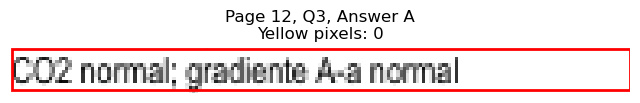

Page 12, Q3 - B: Detected box: x0=82.5, y0=287.1, x1=242.4, y1=299.7
Page 12, Q3, B: Yellow pixels: 0
Page 12, Q3, B: Total non-white pixels: 796
Page 12, Q3, B: Yellow percentage: 0.0%


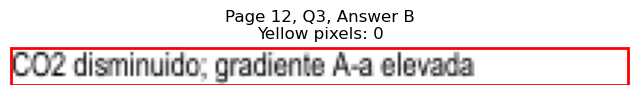

Page 12, Q3 - C: Detected box: x0=82.9, y0=299.7, x1=227.4, y1=312.3
Page 12, Q3, C: Yellow pixels: 0
Page 12, Q3, C: Total non-white pixels: 714
Page 12, Q3, C: Yellow percentage: 0.0%


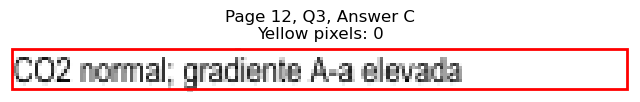

Page 12, Q3 - D: Detected box: x0=334.6, y0=274.5, x1=483.1, y1=287.1
Page 12, Q3, D: Yellow pixels: 192
Page 12, Q3, D: Total non-white pixels: 914
Page 12, Q3, D: Yellow percentage: 21.0%


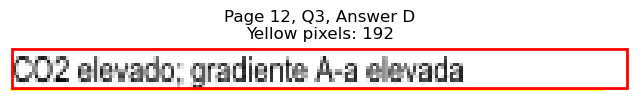

Page 12, Q3 - E: Detected box: x0=334.1, y0=287.1, x1=478.7, y1=299.7
Page 12, Q3, E: Yellow pixels: 1936
Page 12, Q3, E: Total non-white pixels: 2496
Page 12, Q3, E: Yellow percentage: 77.6%


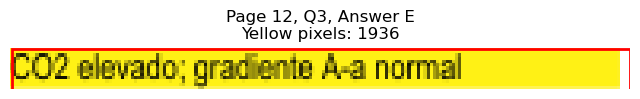


Page 12, Q3 - Selected Answer: E (based on yellow pixel count)




Page 12, Q4 - A: Detected box: x0=82.5, y0=350.2, x1=114.6, y1=362.9
Page 12, Q4, A: Yellow pixels: 0
Page 12, Q4, A: Total non-white pixels: 131
Page 12, Q4, A: Yellow percentage: 0.0%


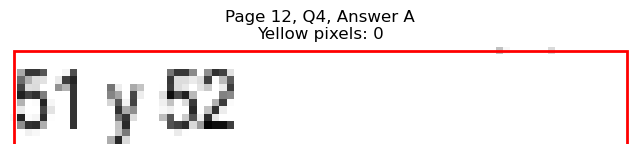

Page 12, Q4 - B: Detected box: x0=82.5, y0=362.8, x1=114.6, y1=375.5
Page 12, Q4, B: Yellow pixels: 83
Page 12, Q4, B: Total non-white pixels: 230
Page 12, Q4, B: Yellow percentage: 36.1%


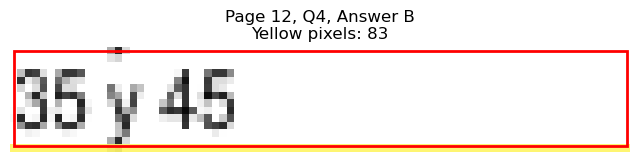

Page 12, Q4 - C: Detected box: x0=82.9, y0=375.4, x1=110.1, y1=388.1
Page 12, Q4, C: Yellow pixels: 958
Page 12, Q4, C: Total non-white pixels: 1106
Page 12, Q4, C: Yellow percentage: 86.6%


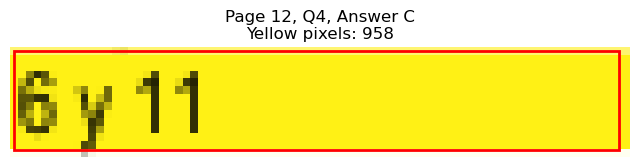

Page 12, Q4 - D: Detected box: x0=334.6, y0=350.2, x1=366.8, y1=362.9
Page 12, Q4, D: Yellow pixels: 0
Page 12, Q4, D: Total non-white pixels: 136
Page 12, Q4, D: Yellow percentage: 0.0%


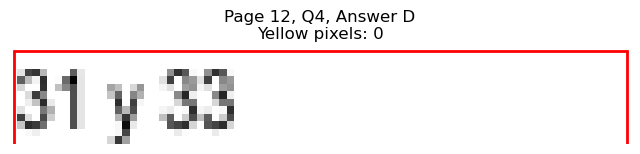

Page 12, Q4 - E: Detected box: x0=334.1, y0=362.8, x1=366.3, y1=375.5
Page 12, Q4, E: Yellow pixels: 0
Page 12, Q4, E: Total non-white pixels: 136
Page 12, Q4, E: Yellow percentage: 0.0%


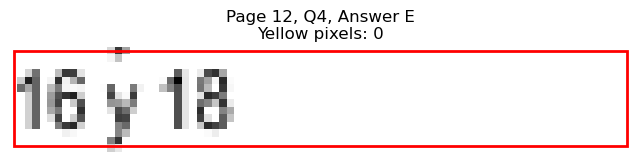


Page 12, Q4 - Selected Answer: C (based on yellow pixel count)




Page 12, Q5 - A: Detected box: x0=82.5, y0=451.1, x1=156.7, y1=463.8
Page 12, Q5, A: Yellow pixels: 0
Page 12, Q5, A: Total non-white pixels: 401
Page 12, Q5, A: Yellow percentage: 0.0%


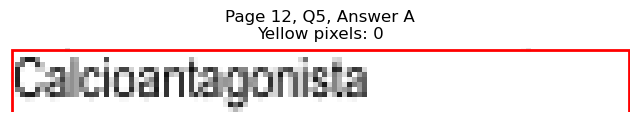

Page 12, Q5 - B: Detected box: x0=82.5, y0=463.7, x1=194.8, y1=476.4
Page 12, Q5, B: Yellow pixels: 0
Page 12, Q5, B: Total non-white pixels: 589
Page 12, Q5, B: Yellow percentage: 0.0%


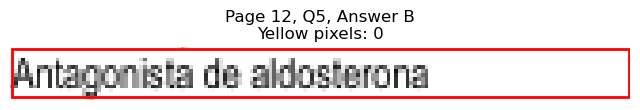

Page 12, Q5 - C: Detected box: x0=82.9, y0=476.3, x1=156.6, y1=489.0
Page 12, Q5, C: Yellow pixels: 0
Page 12, Q5, C: Total non-white pixels: 365
Page 12, Q5, C: Yellow percentage: 0.0%


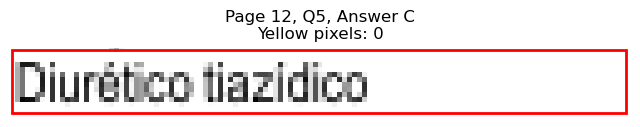

Page 12, Q5 - D: Detected box: x0=334.6, y0=451.1, x1=438.4, y1=463.8
Page 12, Q5, D: Yellow pixels: 0
Page 12, Q5, D: Total non-white pixels: 703
Page 12, Q5, D: Yellow percentage: 0.0%


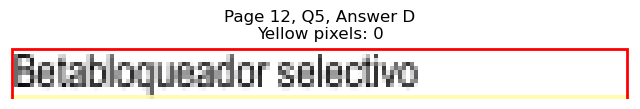

Page 12, Q5 - E: Detected box: x0=334.1, y0=463.7, x1=506.7, y1=476.4
Page 12, Q5, E: Yellow pixels: 1612
Page 12, Q5, E: Total non-white pixels: 2688
Page 12, Q5, E: Yellow percentage: 60.0%


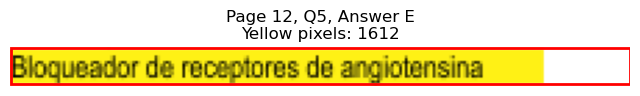


Page 12, Q5 - Selected Answer: E (based on yellow pixel count)




Page 12, Q6 - A: Detected box: x0=82.5, y0=526.9, x1=116.1, y1=539.5
Page 12, Q6, A: Yellow pixels: 85
Page 12, Q6, A: Total non-white pixels: 241
Page 12, Q6, A: Yellow percentage: 35.3%


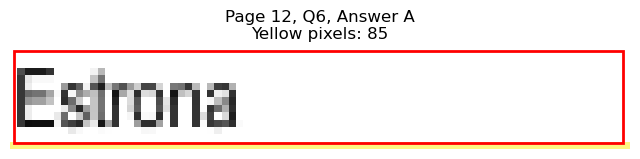

Page 12, Q6 - B: Detected box: x0=82.5, y0=539.5, x1=133.6, y1=552.1
Page 12, Q6, B: Yellow pixels: 1129
Page 12, Q6, B: Total non-white pixels: 1428
Page 12, Q6, B: Yellow percentage: 79.1%


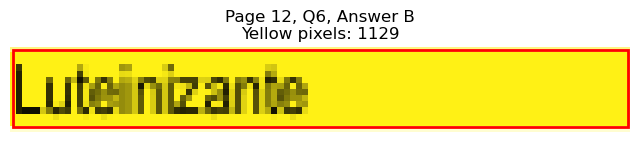

Page 12, Q6 - C: Detected box: x0=82.9, y0=552.2, x1=117.0, y1=564.8
Page 12, Q6, C: Yellow pixels: 0
Page 12, Q6, C: Total non-white pixels: 242
Page 12, Q6, C: Yellow percentage: 0.0%


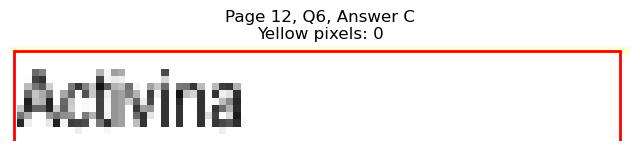

Page 12, Q6 - D: Detected box: x0=334.6, y0=526.9, x1=378.3, y1=539.5
Page 12, Q6, D: Yellow pixels: 0
Page 12, Q6, D: Total non-white pixels: 238
Page 12, Q6, D: Yellow percentage: 0.0%


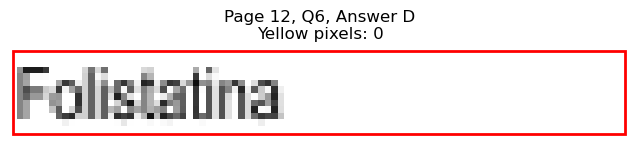

Page 12, Q6 - E: Detected box: x0=334.1, y0=539.5, x1=390.8, y1=552.1
Page 12, Q6, E: Yellow pixels: 0
Page 12, Q6, E: Total non-white pixels: 302
Page 12, Q6, E: Yellow percentage: 0.0%


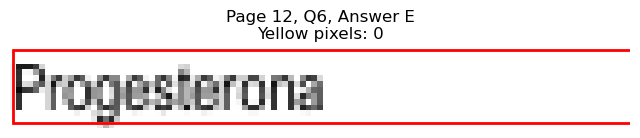


Page 12, Q6 - Selected Answer: B (based on yellow pixel count)




Page 12, Q7 - A: Detected box: x0=82.5, y0=602.6, x1=173.8, y1=615.2
Page 12, Q7, A: Yellow pixels: 1492
Page 12, Q7, A: Total non-white pixels: 1988
Page 12, Q7, A: Yellow percentage: 75.1%


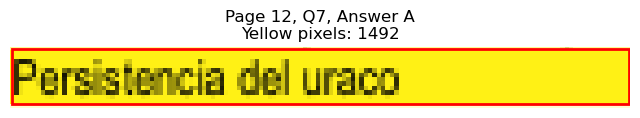

Page 12, Q7 - B: Detected box: x0=82.5, y0=615.2, x1=117.6, y1=627.8
Page 12, Q7, B: Yellow pixels: 0
Page 12, Q7, B: Total non-white pixels: 266
Page 12, Q7, B: Yellow percentage: 0.0%


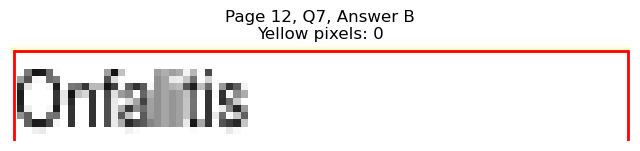

Page 12, Q7 - C: Detected box: x0=82.9, y0=627.9, x1=140.1, y1=640.6
Page 12, Q7, C: Yellow pixels: 0
Page 12, Q7, C: Total non-white pixels: 312
Page 12, Q7, C: Yellow percentage: 0.0%


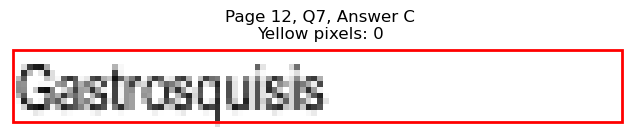

Page 12, Q7 - D: Detected box: x0=334.6, y0=602.6, x1=400.9, y1=615.2
Page 12, Q7, D: Yellow pixels: 0
Page 12, Q7, D: Total non-white pixels: 361
Page 12, Q7, D: Yellow percentage: 0.0%


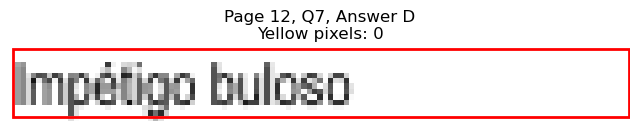

Page 12, Q7 - E: Detected box: x0=334.1, y0=615.2, x1=515.7, y1=627.8
Page 12, Q7, E: Yellow pixels: 0
Page 12, Q7, E: Total non-white pixels: 937
Page 12, Q7, E: Yellow percentage: 0.0%


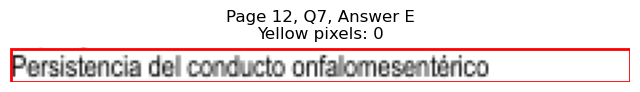


Page 12, Q7 - Selected Answer: A (based on yellow pixel count)




Page 12, Q8 - A: Detected box: x0=82.5, y0=691.1, x1=189.7, y1=703.7
Page 12, Q8, A: Yellow pixels: 0
Page 12, Q8, A: Total non-white pixels: 554
Page 12, Q8, A: Yellow percentage: 0.0%


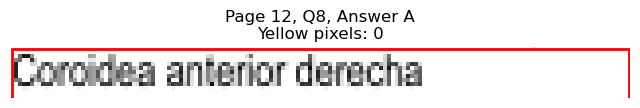

Page 12, Q8 - B: Detected box: x0=82.5, y0=703.7, x1=191.8, y1=716.3
Page 12, Q8, B: Yellow pixels: 160
Page 12, Q8, B: Total non-white pixels: 731
Page 12, Q8, B: Yellow percentage: 21.9%


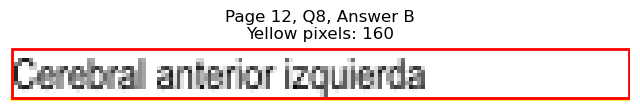

Page 12, Q8 - C: Detected box: x0=82.9, y0=716.3, x1=157.8, y1=728.9
Page 12, Q8, C: Yellow pixels: 1345
Page 12, Q8, C: Total non-white pixels: 1638
Page 12, Q8, C: Yellow percentage: 82.1%


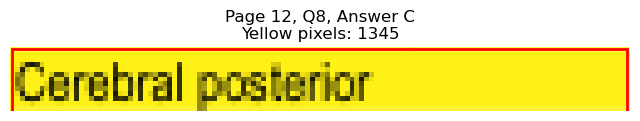

Page 12, Q8 - D: Detected box: x0=334.6, y0=691.1, x1=437.9, y1=703.7
Page 12, Q8, D: Yellow pixels: 0
Page 12, Q8, D: Total non-white pixels: 516
Page 12, Q8, D: Yellow percentage: 0.0%


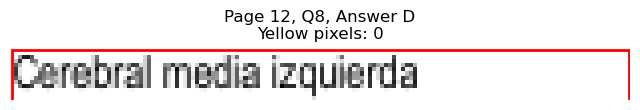

Page 12, Q8 - E: Detected box: x0=334.1, y0=703.7, x1=430.9, y1=716.3
Page 12, Q8, E: Yellow pixels: 0
Page 12, Q8, E: Total non-white pixels: 506
Page 12, Q8, E: Yellow percentage: 0.0%


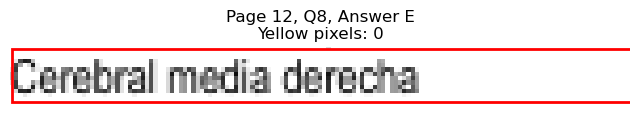


Page 12, Q8 - Selected Answer: C (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Mujer de 50 años, acude a consulta por present...
1   Mujer de 42 años con antecedente de diabetes, ...
2   Mujer de 35 años, G5 P 5005, puérpera de 1 hor...
3   Niño de 14 años, acude por tos seca de una sem...
4   Mujer de 64 años que hace 4 horas presenta rec...
..                                                ...
85  Gestante de 24 años, en el segundo trimestre d...
86  Mujer de 50 años, diagnosticada de diabetes me...
87  ¿Qué hormona es imprescindible para que pueda ...
88  Recién nacido presenta salida persistente de l...
89  Varón de 62 años con antecedente de fibrilació...

[90 rows x 1 columns]

In [8]:
answers_df

option_A                     option_B  \
0                         RMN                Fistulografía   
1                  Insulinoma                  Glucagonoma   
2                Coagulopatía             Desgarro vaginal   
3                Azitromicina                      Codeína   
4       IV y hemorroidectomía         III y escleroterapia   
..                        ...                          ...   
85                    51 y 52                      35 y 45   
86          Calcioantagonista   Antagonista de aldosterona   
87                    Estrona                 Luteinizante   
88     Persistencia del uraco                    Onfalitis   
89  Coroidea anterior derecha  Cerebral anterior izquierda   

                            option_C                  option_D  \
0                 Ecografía endoanal        Regla de Goodasall   
1                         Gastrinoma           Somatostatinoma   
2   Retención de restos placentarios            Rotura uterina   
3                     Ciprofloxacina                Salbutamol   
4   II y ligadura con banda elástica         III y crioterapia   
..                               ...                       ...   
85                            6 y 11                   31 y 33   
86               Diurético tiazídico  Betabloqueador selectivo   
87                          Activina               Folistatina   
88                     Gastrosquisis           Impétigo buloso   
89                Cerebral posterior  Cerebral media izquierda   

                                       option_E  
0                                 TAC de pelvis  
1                                       Linfoma  
2                                Atonía uterina  
3                                  Dexametasoma  
4           IV y ablación por rayos infrarrojos  
..                                          ...  
85                                      16 y 18  
86     Bloqueador de receptores de angiotensina  
87                                 Progesterona  
88  Persistencia del conducto onfalomesentérico  
89                       Cerebral media derecha  

[90 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               D
1               B
2               E
3               A
4               A
..            ...
85              C
86              E
87              B
88              A
89              C

[90 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   Mujer de 50 años, acude a consulta por present...   
1   Mujer de 42 años con antecedente de diabetes, ...   
2   Mujer de 35 años, G5 P 5005, puérpera de 1 hor...   
3   Niño de 14 años, acude por tos seca de una sem...   
4   Mujer de 64 años que hace 4 horas presenta rec...   
..                                                ...   
85  Gestante de 24 años, en el segundo trimestre d...   
86  Mujer de 50 años, diagnosticada de diabetes me...   
87  ¿Qué hormona es imprescindible para que pueda ...   
88  Recién nacido presenta salida persistente de l...   
89  Varón de 62 años con antecedente de fibrilació...   

                     option_A                     option_B  \
0                         RMN                Fistulografía   
1                  Insulinoma                  Glucagonoma   
2                Coagulopatía             Desgarro vaginal   
3                Azitromicina                      Codeína   
4       IV y hemorroidectomía         III y escleroterapia   
..                        ...                          ...   
85                    51 y 52                      35 y 45   
86          Calcioantagonista   Antagonista de aldosterona   
87                    Estrona                 Luteinizante   
88     Persistencia del uraco                    Onfalitis   
89  Coroidea anterior derecha  Cerebral anterior izquierda   

                            option_C                  option_D  \
0                 Ecografía endoanal        Regla de Goodasall   
1                         Gastrinoma           Somatostatinoma   
2   Retención de restos placentarios            Rotura uterina   
3                     Ciprofloxacina                Salbutamol   
4   II y ligadura con banda elástica         III y crioterapia   
..                               ...                       ...   
85                            6 y 11                   31 y 33   
86               Diurético tiazídico  Betabloqueador selectivo   
87                          Activina               Folistatina   
88                     Gastrosquisis           Impétigo buloso   
89                Cerebral posterior  Cerebral media izquierda   

                                       option_E correct_answer  
0                                 TAC de pelvis              D  
1                                       Linfoma              B  
2                                Atonía uterina              E  
3                                  Dexametasoma              A  
4           IV y ablación por rayos infrarrojos              A  
..                                          ...            ...  
85                                      16 y 18              C  
86     Bloqueador de receptores de angiotensina              E  
87                                 Progesterona              B  
88  Persistencia del conducto onfalomesentérico              A  
89                       Cerebral media derecha              C  

[90 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2020/PRUEBA B.csv
